In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward, done = env.step(action_user, action_mod, target_loc, curr_loc)
        
        return new_loc, reward, done

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.9 0.1]
 [0.2 0.7]
 [0.  0.1]
 [0.6 0. ]
 [0.3 0. ]
 [0.6 0.2]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

In [5]:
state = [0.1,0.1,0.3,0.3]
state = np.array(state)
next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
print(next_state, reward,done)

user_agent.replay_buffer.print()

print(user_agent.model(np.array([state])))

[0.1, 0.2, 0.3, 0.3] 1 0
deque([array([0.1, 0.1, 0.3, 0.3])], maxlen=1024)
deque([3], maxlen=1024)
deque([1], maxlen=1024)
deque([[0.1, 0.2, 0.3, 0.3]], maxlen=1024)
deque([0], maxlen=1024)
tf.Tensor([[-0.03934988  0.03145487 -0.02199761  0.03426342]], shape=(1, 4), dtype=float32)


  0%|                                                                             | 115/100000 [00:00<17:19, 96.08it/s]

Updated Weights
Mean Reward = -1.2277227722772277
17


  0%|▏                                                                            | 218/100000 [00:02<17:28, 95.16it/s]

Updated Weights
Mean Reward = -0.35
16


  0%|▏                                                                            | 303/100000 [00:03<21:58, 75.64it/s]

Updated Weights
Mean Reward = -0.12
19


  0%|▎                                                                            | 409/100000 [00:04<29:27, 56.35it/s]

Updated Weights
Mean Reward = 1.41
21


  0%|▍                                                                            | 495/100000 [00:06<27:27, 60.41it/s]

Updated Weights
Mean Reward = 1.23
24


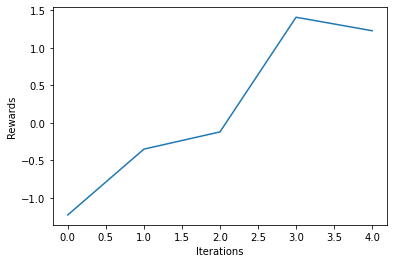

  1%|▍                                                                            | 610/100000 [00:08<27:17, 60.71it/s]

Updated Weights
Mean Reward = 2.2
28


  1%|▌                                                                            | 707/100000 [00:10<27:01, 61.25it/s]

Updated Weights
Mean Reward = 2.72
38


  1%|▌                                                                            | 806/100000 [00:12<36:11, 45.69it/s]

Updated Weights
Mean Reward = 3.86
39


  1%|▋                                                                            | 907/100000 [00:14<32:23, 51.00it/s]

Updated Weights
Mean Reward = 3.62
40


  1%|▊                                                                            | 999/100000 [00:15<28:18, 58.27it/s]

Updated Weights
Mean Reward = 5.64
48


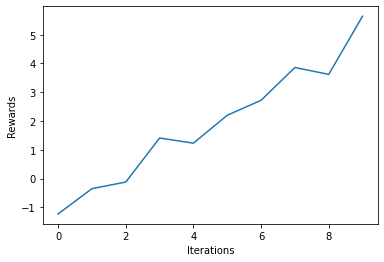

  1%|▊                                                                           | 1109/100000 [00:18<37:49, 43.57it/s]

Updated Weights
Mean Reward = 2.95
37


  1%|▉                                                                           | 1207/100000 [00:20<43:10, 38.14it/s]

Updated Weights
Mean Reward = 2.43
32


  1%|▉                                                                           | 1309/100000 [00:23<34:05, 48.25it/s]

Updated Weights
Mean Reward = 2.39
36


  1%|█                                                                           | 1405/100000 [00:25<40:11, 40.88it/s]

Updated Weights
Mean Reward = 3.39
43


  1%|█▏                                                                          | 1496/100000 [00:27<36:54, 44.49it/s]

Updated Weights
Mean Reward = 3.93
38


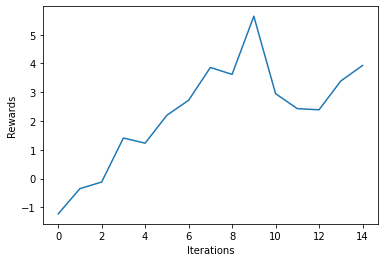

  2%|█▏                                                                          | 1604/100000 [00:30<41:06, 39.89it/s]

Updated Weights
Mean Reward = 5.26
44


  2%|█▎                                                                          | 1706/100000 [00:33<43:30, 37.66it/s]

Updated Weights
Mean Reward = 1.2
31


  2%|█▍                                                                          | 1810/100000 [00:36<34:33, 47.35it/s]

Updated Weights
Mean Reward = 3.78
44


  2%|█▍                                                                          | 1907/100000 [00:38<37:00, 44.17it/s]

Updated Weights
Mean Reward = 4.72
56


  2%|█▌                                                                          | 1995/100000 [00:40<40:35, 40.25it/s]

Updated Weights
Mean Reward = 3.33
37


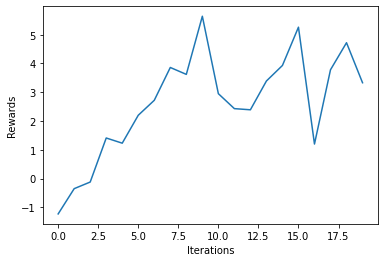

  2%|█▌                                                                          | 2104/100000 [00:43<42:22, 38.50it/s]

Updated Weights
Mean Reward = 1.32
27


  2%|█▋                                                                          | 2205/100000 [00:45<42:00, 38.80it/s]

Updated Weights
Mean Reward = 2.77
29


  2%|█▊                                                                          | 2308/100000 [00:48<42:49, 38.01it/s]

Updated Weights
Mean Reward = 1.44
36


  2%|█▊                                                                          | 2407/100000 [00:50<41:25, 39.26it/s]

Updated Weights
Mean Reward = 5.48
52


  2%|█▉                                                                          | 2500/100000 [00:53<45:14, 35.92it/s]

Updated Weights
Mean Reward = 3.04
31


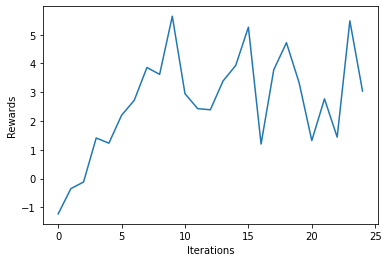

  3%|█▉                                                                          | 2610/100000 [00:56<41:01, 39.56it/s]

Updated Weights
Mean Reward = 3.78
33


  3%|██                                                                          | 2706/100000 [00:59<39:40, 40.86it/s]

Updated Weights
Mean Reward = 2.94
42


  3%|██▏                                                                         | 2806/100000 [01:01<45:18, 35.75it/s]

Updated Weights
Mean Reward = 2.76
45


  3%|██▏                                                                         | 2904/100000 [01:04<37:27, 43.19it/s]

Updated Weights
Mean Reward = 3.31
38


  3%|██▎                                                                         | 2999/100000 [01:06<41:27, 38.99it/s]

Updated Weights
Mean Reward = 0.43
36


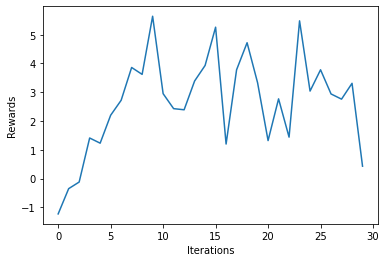

  3%|██▎                                                                         | 3105/100000 [01:10<50:02, 32.27it/s]

Updated Weights
Mean Reward = 3.59
30


  3%|██▍                                                                         | 3208/100000 [01:13<44:30, 36.25it/s]

Updated Weights
Mean Reward = 3.89
29


  3%|██▌                                                                         | 3305/100000 [01:15<49:12, 32.75it/s]

Updated Weights
Mean Reward = 3.56
51


  3%|██▌                                                                         | 3404/100000 [01:18<48:01, 33.52it/s]

Updated Weights
Mean Reward = 6.81
40


  3%|██▋                                                                         | 3497/100000 [01:21<39:37, 40.59it/s]

Updated Weights
Mean Reward = 1.28
33


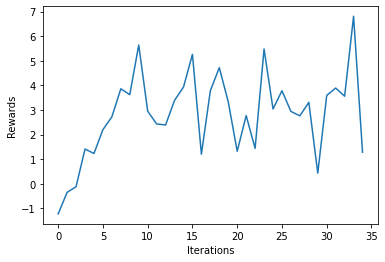

  4%|██▋                                                                         | 3604/100000 [01:24<53:22, 30.10it/s]

Updated Weights
Mean Reward = 3.18
30


  4%|██▊                                                                         | 3706/100000 [01:27<49:07, 32.67it/s]

Updated Weights
Mean Reward = 1.79
25


  4%|██▉                                                                         | 3806/100000 [01:30<54:49, 29.24it/s]

Updated Weights
Mean Reward = 1.48
30


  4%|██▉                                                                       | 3904/100000 [01:34<1:14:12, 21.58it/s]

Updated Weights
Mean Reward = 3.19
30


  4%|██▉                                                                       | 3998/100000 [01:38<1:04:38, 24.76it/s]

Updated Weights
Mean Reward = 4.41
23


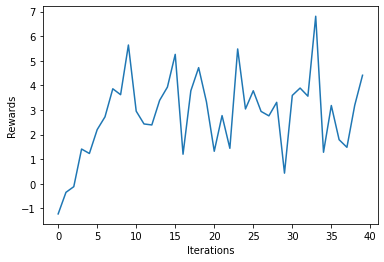

  4%|███                                                                         | 4106/100000 [01:41<52:55, 30.20it/s]

Updated Weights
Mean Reward = 3.21
22


  4%|███▏                                                                        | 4204/100000 [01:45<59:06, 27.01it/s]

Updated Weights
Mean Reward = 3.95
27


  4%|███▎                                                                        | 4305/100000 [01:49<53:19, 29.91it/s]

Updated Weights
Mean Reward = 5.32
23


  4%|███▎                                                                        | 4404/100000 [01:52<58:30, 27.23it/s]

Updated Weights
Mean Reward = 4.76
30


  4%|███▍                                                                        | 4499/100000 [01:55<53:21, 29.83it/s]

Updated Weights
Mean Reward = 2.24
21


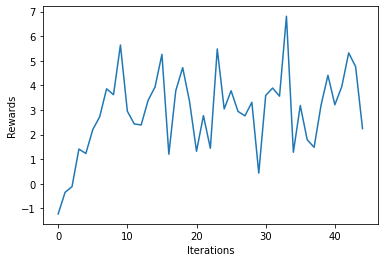

  5%|███▍                                                                      | 4604/100000 [01:59<1:01:37, 25.80it/s]

Updated Weights
Mean Reward = 1.46
28


  5%|███▌                                                                        | 4703/100000 [02:02<50:15, 31.60it/s]

Updated Weights
Mean Reward = 3.73
24


  5%|███▋                                                                        | 4804/100000 [02:06<58:56, 26.92it/s]

Updated Weights
Mean Reward = 3.59
19


  5%|███▋                                                                        | 4904/100000 [02:09<49:44, 31.87it/s]

Updated Weights
Mean Reward = 5.94
31


  5%|███▊                                                                        | 4999/100000 [02:12<55:27, 28.55it/s]

Updated Weights
Mean Reward = 5.18
28


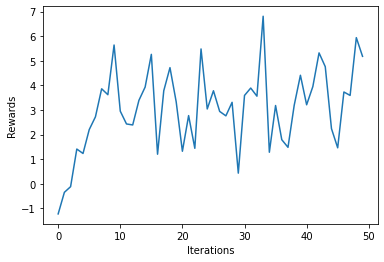

  5%|███▉                                                                        | 5106/100000 [02:16<51:15, 30.85it/s]

Updated Weights
Mean Reward = 4.19
28


  5%|███▉                                                                        | 5205/100000 [02:20<57:58, 27.25it/s]

Updated Weights
Mean Reward = 4.28
26


  5%|███▉                                                                      | 5305/100000 [02:23<1:00:00, 26.30it/s]

Updated Weights
Mean Reward = 2.88
21


  5%|███▉                                                                      | 5404/100000 [02:27<1:04:27, 24.46it/s]

Updated Weights
Mean Reward = 4.78
18


  5%|████▏                                                                       | 5499/100000 [02:30<58:16, 27.03it/s]

Updated Weights
Mean Reward = 4.59
20


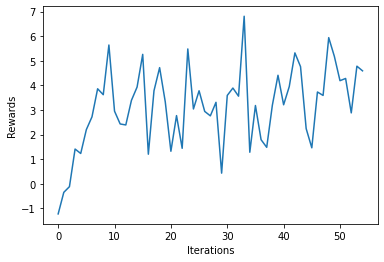

  6%|████▎                                                                       | 5607/100000 [02:34<47:41, 32.99it/s]

Updated Weights
Mean Reward = 5.26
32


  6%|████▎                                                                       | 5705/100000 [02:37<47:47, 32.89it/s]

Updated Weights
Mean Reward = 4.71
30


  6%|████▍                                                                       | 5805/100000 [02:41<56:59, 27.55it/s]

Updated Weights
Mean Reward = 3.8
28


  6%|████▍                                                                       | 5904/100000 [02:44<51:37, 30.37it/s]

Updated Weights
Mean Reward = 1.0
17


  6%|████▌                                                                       | 5998/100000 [02:47<50:40, 30.92it/s]

Updated Weights
Mean Reward = 6.14
31


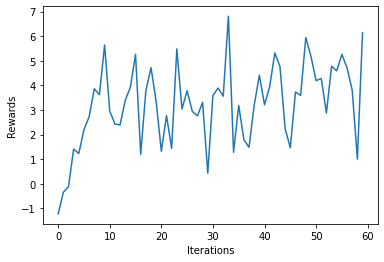

  6%|████▋                                                                       | 6106/100000 [02:51<57:43, 27.11it/s]

Updated Weights
Mean Reward = 3.86
22


  6%|████▋                                                                       | 6206/100000 [02:55<47:51, 32.66it/s]

Updated Weights
Mean Reward = 4.58
22


  6%|████▊                                                                       | 6305/100000 [02:58<49:26, 31.58it/s]

Updated Weights
Mean Reward = 4.14
33


  6%|████▋                                                                     | 6406/100000 [03:02<1:00:33, 25.76it/s]

Updated Weights
Mean Reward = -1.05
18


  6%|████▊                                                                     | 6499/100000 [03:05<1:06:02, 23.60it/s]

Updated Weights
Mean Reward = 5.48
22


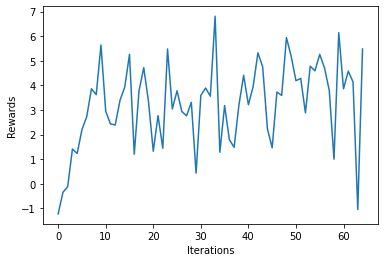

  7%|█████                                                                       | 6605/100000 [03:09<56:39, 27.47it/s]

Updated Weights
Mean Reward = 5.23
24


  7%|█████                                                                       | 6707/100000 [03:13<54:54, 28.32it/s]

Updated Weights
Mean Reward = 3.7
14


  7%|█████▏                                                                      | 6804/100000 [03:17<53:24, 29.08it/s]

Updated Weights
Mean Reward = 4.95
22


  7%|█████                                                                     | 6904/100000 [03:20<1:00:23, 25.69it/s]

Updated Weights
Mean Reward = 3.97
20


  7%|█████▎                                                                      | 6999/100000 [03:24<55:50, 27.76it/s]

Updated Weights
Mean Reward = 1.49
22


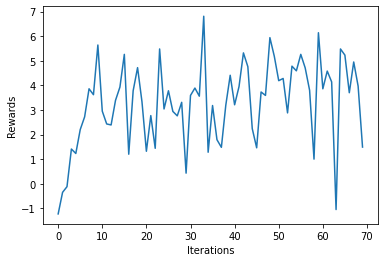

  7%|█████▎                                                                    | 7105/100000 [03:28<1:00:33, 25.57it/s]

Updated Weights
Mean Reward = 4.51
19


  7%|█████▍                                                                      | 7206/100000 [03:31<54:34, 28.34it/s]

Updated Weights
Mean Reward = 4.04
19


  7%|█████▍                                                                    | 7304/100000 [03:35<1:00:09, 25.68it/s]

Updated Weights
Mean Reward = 2.68
20


  7%|█████▋                                                                      | 7403/100000 [03:38<48:47, 31.63it/s]

Updated Weights
Mean Reward = 5.01
26


  7%|█████▋                                                                      | 7499/100000 [03:42<56:14, 27.41it/s]

Updated Weights
Mean Reward = 4.71
25


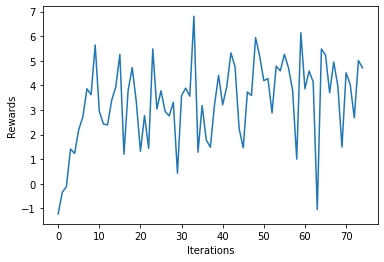

  8%|█████▊                                                                      | 7605/100000 [03:46<57:21, 26.84it/s]

Updated Weights
Mean Reward = 4.07
22


  8%|█████▊                                                                      | 7706/100000 [03:49<52:36, 29.24it/s]

Updated Weights
Mean Reward = 5.66
22


  8%|█████▉                                                                      | 7808/100000 [03:53<48:53, 31.42it/s]

Updated Weights
Mean Reward = 4.12
25


  8%|██████                                                                      | 7906/100000 [03:56<52:20, 29.33it/s]

Updated Weights
Mean Reward = 4.31
31


  8%|██████                                                                      | 8000/100000 [03:59<47:25, 32.33it/s]

Updated Weights
Mean Reward = 4.68
33


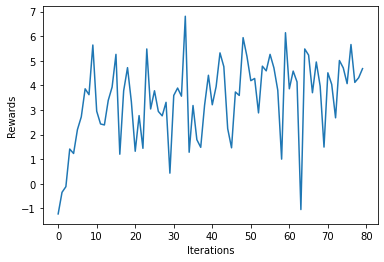

  8%|██████▏                                                                     | 8108/100000 [04:03<48:15, 31.74it/s]

Updated Weights
Mean Reward = 4.95
27


  8%|██████▏                                                                     | 8207/100000 [04:06<48:42, 31.41it/s]

Updated Weights
Mean Reward = 5.29
30


  8%|██████▎                                                                     | 8306/100000 [04:10<48:45, 31.35it/s]

Updated Weights
Mean Reward = 1.99
25


  8%|██████▍                                                                     | 8404/100000 [04:13<55:15, 27.63it/s]

Updated Weights
Mean Reward = 4.35
30


  8%|██████▍                                                                     | 8498/100000 [04:16<49:25, 30.86it/s]

Updated Weights
Mean Reward = 5.68
29


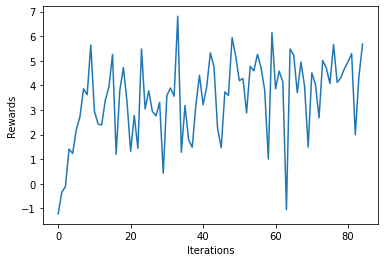

  9%|██████▌                                                                     | 8605/100000 [04:20<56:39, 26.88it/s]

Updated Weights
Mean Reward = 5.54
23


  9%|██████▌                                                                     | 8704/100000 [04:23<51:01, 29.82it/s]

Updated Weights
Mean Reward = 5.9
30


  9%|██████▋                                                                     | 8806/100000 [04:27<56:44, 26.78it/s]

Updated Weights
Mean Reward = 2.79
28


  9%|██████▊                                                                     | 8905/100000 [04:30<51:53, 29.26it/s]

Updated Weights
Mean Reward = 4.06
21


  9%|██████▋                                                                   | 9000/100000 [04:34<1:00:54, 24.90it/s]

Updated Weights
Mean Reward = 3.9
19


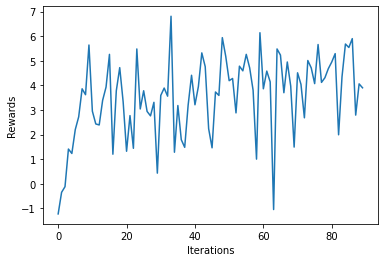

  9%|██████▉                                                                     | 9105/100000 [04:38<55:34, 27.26it/s]

Updated Weights
Mean Reward = 4.08
34


  9%|██████▉                                                                     | 9204/100000 [04:41<55:32, 27.25it/s]

Updated Weights
Mean Reward = 3.87
28


  9%|███████                                                                     | 9305/100000 [04:45<58:23, 25.89it/s]

Updated Weights
Mean Reward = 4.79
24


  9%|███████▏                                                                    | 9404/100000 [04:48<55:15, 27.33it/s]

Updated Weights
Mean Reward = 4.91
25


  9%|███████▏                                                                    | 9497/100000 [04:51<46:13, 32.63it/s]

Updated Weights
Mean Reward = 6.46
28


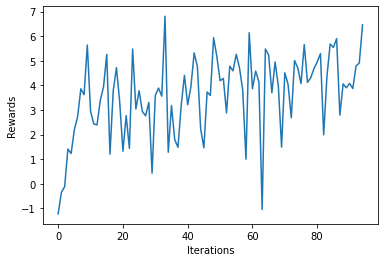

 10%|███████▎                                                                    | 9605/100000 [04:55<52:10, 28.88it/s]

Updated Weights
Mean Reward = 2.99
22


 10%|███████▍                                                                    | 9705/100000 [04:58<53:39, 28.05it/s]

Updated Weights
Mean Reward = 5.25
29


 10%|███████▍                                                                    | 9807/100000 [05:02<49:30, 30.36it/s]

Updated Weights
Mean Reward = 3.27
25


 10%|███████▌                                                                    | 9905/100000 [05:06<55:58, 26.83it/s]

Updated Weights
Mean Reward = 1.35
26


 10%|███████▌                                                                    | 9998/100000 [05:09<58:30, 25.64it/s]

Updated Weights
Mean Reward = 2.96
18


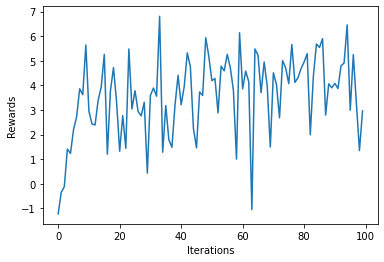

 10%|███████▌                                                                   | 10105/100000 [05:13<58:38, 25.55it/s]

Updated Weights
Mean Reward = 5.49
28


 10%|███████▋                                                                   | 10204/100000 [05:16<47:57, 31.21it/s]

Updated Weights
Mean Reward = 4.45
26


 10%|███████▋                                                                   | 10305/100000 [05:20<52:19, 28.57it/s]

Updated Weights
Mean Reward = 3.72
22


 10%|███████▊                                                                   | 10406/100000 [05:23<47:33, 31.40it/s]

Updated Weights
Mean Reward = 5.41
25


 10%|███████▊                                                                   | 10498/100000 [05:26<50:42, 29.42it/s]

Updated Weights
Mean Reward = 4.44
28


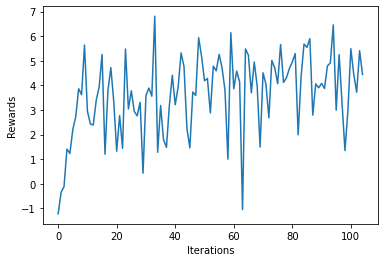

 11%|███████▉                                                                   | 10606/100000 [05:30<55:09, 27.01it/s]

Updated Weights
Mean Reward = 6.77
27


 11%|████████                                                                   | 10704/100000 [05:34<48:53, 30.44it/s]

Updated Weights
Mean Reward = 5.81
28


 11%|████████                                                                   | 10804/100000 [05:37<49:08, 30.25it/s]

Updated Weights
Mean Reward = 4.72
26


 11%|████████▏                                                                  | 10906/100000 [05:41<56:20, 26.35it/s]

Updated Weights
Mean Reward = 4.7
22


 11%|████████▏                                                                  | 10997/100000 [05:44<46:02, 32.22it/s]

Updated Weights
Mean Reward = 7.52
39


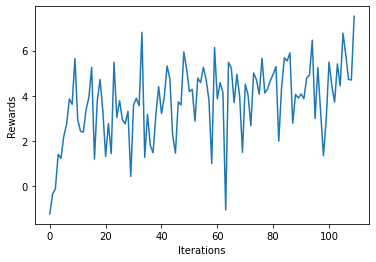

 11%|████████                                                                 | 11103/100000 [05:48<1:04:27, 22.99it/s]

Updated Weights
Mean Reward = 4.19
15


 11%|████████▍                                                                  | 11206/100000 [05:52<50:20, 29.40it/s]

Updated Weights
Mean Reward = 4.68
25


 11%|████████▍                                                                  | 11307/100000 [05:55<54:58, 26.89it/s]

Updated Weights
Mean Reward = 4.48
27


 11%|████████▌                                                                  | 11406/100000 [05:59<48:07, 30.68it/s]

Updated Weights
Mean Reward = 6.68
26


 12%|████████▋                                                                  | 11500/100000 [06:02<53:56, 27.35it/s]

Updated Weights
Mean Reward = 3.23
23


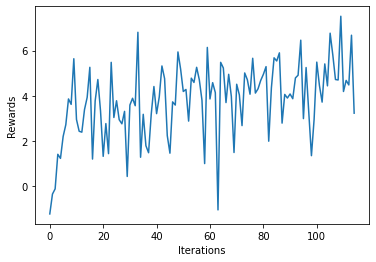

 12%|████████▋                                                                  | 11604/100000 [06:06<43:37, 33.78it/s]

Updated Weights
Mean Reward = 4.29
26


 12%|████████▊                                                                  | 11707/100000 [06:09<52:55, 27.80it/s]

Updated Weights
Mean Reward = 3.96
22


 12%|████████▊                                                                  | 11806/100000 [06:13<52:46, 27.85it/s]

Updated Weights
Mean Reward = 6.43
32


 12%|████████▉                                                                  | 11908/100000 [06:16<45:40, 32.15it/s]

Updated Weights
Mean Reward = 6.36
30


 12%|████████▉                                                                  | 11999/100000 [06:19<45:57, 31.91it/s]

Updated Weights
Mean Reward = 6.24
27


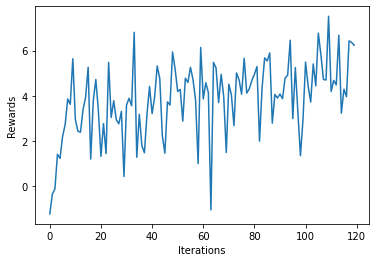

 12%|█████████                                                                  | 12105/100000 [06:23<50:43, 28.87it/s]

Updated Weights
Mean Reward = 5.36
26


 12%|█████████▏                                                                 | 12205/100000 [06:27<55:01, 26.59it/s]

Updated Weights
Mean Reward = 5.01
22


 12%|█████████▏                                                                 | 12305/100000 [06:30<45:51, 31.87it/s]

Updated Weights
Mean Reward = 7.63
39


 12%|█████████▎                                                                 | 12405/100000 [06:34<50:53, 28.69it/s]

Updated Weights
Mean Reward = 3.54
16


 12%|█████████▎                                                                 | 12497/100000 [06:37<53:52, 27.07it/s]

Updated Weights
Mean Reward = 6.58
30


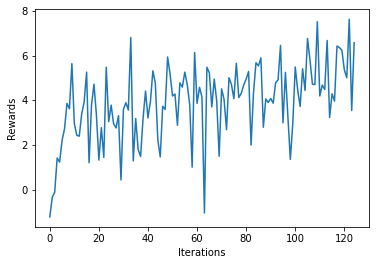

 13%|█████████▍                                                                 | 12604/100000 [06:41<48:56, 29.76it/s]

Updated Weights
Mean Reward = 5.82
32


 13%|█████████▌                                                                 | 12705/100000 [06:44<52:46, 27.57it/s]

Updated Weights
Mean Reward = 4.61
20


 13%|█████████▌                                                                 | 12806/100000 [06:48<51:58, 27.96it/s]

Updated Weights
Mean Reward = 5.58
20


 13%|█████████▋                                                                 | 12907/100000 [06:51<48:01, 30.22it/s]

Updated Weights
Mean Reward = 5.63
25


 13%|█████████▋                                                                 | 12999/100000 [06:55<50:56, 28.47it/s]

Updated Weights
Mean Reward = 3.56
21


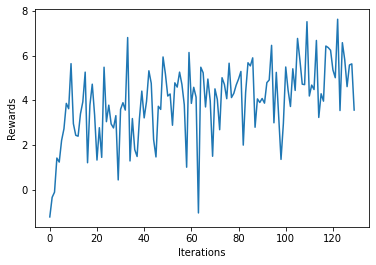

 13%|█████████▊                                                                 | 13106/100000 [06:59<55:26, 26.12it/s]

Updated Weights
Mean Reward = 5.98
23


 13%|█████████▉                                                                 | 13204/100000 [07:02<55:08, 26.24it/s]

Updated Weights
Mean Reward = 6.49
30


 13%|█████████▉                                                                 | 13308/100000 [07:06<46:52, 30.83it/s]

Updated Weights
Mean Reward = 6.23
29


 13%|██████████                                                                 | 13405/100000 [07:09<53:27, 27.00it/s]

Updated Weights
Mean Reward = 5.44
32


 14%|██████████▏                                                                | 13500/100000 [07:12<47:37, 30.27it/s]

Updated Weights
Mean Reward = 6.17
31


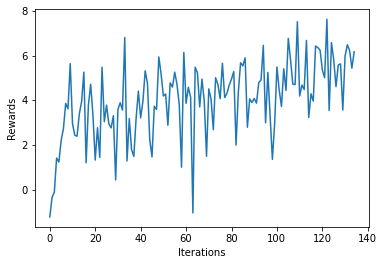

 14%|██████████▏                                                                | 13603/100000 [07:16<47:35, 30.26it/s]

Updated Weights
Mean Reward = 5.25
29


 14%|██████████▎                                                                | 13703/100000 [07:19<50:13, 28.64it/s]

Updated Weights
Mean Reward = 4.8
22


 14%|██████████▎                                                                | 13807/100000 [07:23<46:31, 30.87it/s]

Updated Weights
Mean Reward = 5.39
24


 14%|██████████▍                                                                | 13905/100000 [07:26<52:21, 27.41it/s]

Updated Weights
Mean Reward = 6.78
29


 14%|██████████▍                                                                | 13998/100000 [07:30<55:03, 26.03it/s]

Updated Weights
Mean Reward = 5.37
27


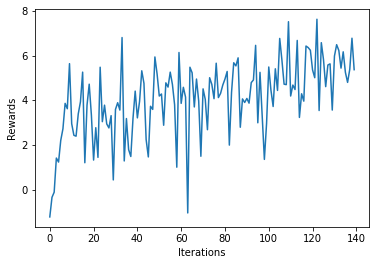

 14%|██████████▌                                                                | 14105/100000 [07:34<55:38, 25.73it/s]

Updated Weights
Mean Reward = 4.7
24


 14%|██████████▋                                                                | 14206/100000 [07:37<45:36, 31.36it/s]

Updated Weights
Mean Reward = 4.65
21


 14%|██████████▋                                                                | 14304/100000 [07:40<47:12, 30.26it/s]

Updated Weights
Mean Reward = 7.31
36


 14%|██████████▊                                                                | 14404/100000 [07:44<52:39, 27.09it/s]

Updated Weights
Mean Reward = 1.01
16


 14%|██████████▊                                                                | 14498/100000 [07:48<51:29, 27.68it/s]

Updated Weights
Mean Reward = 3.3
14


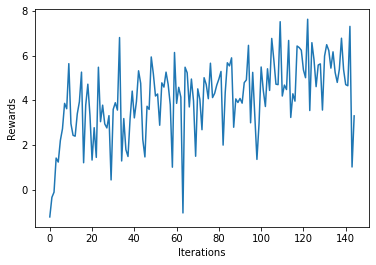

 15%|██████████▉                                                                | 14603/100000 [07:52<49:34, 28.71it/s]

Updated Weights
Mean Reward = 4.14
17


 15%|███████████                                                                | 14705/100000 [07:55<54:32, 26.06it/s]

Updated Weights
Mean Reward = 4.93
17


 15%|███████████                                                                | 14806/100000 [07:59<53:04, 26.75it/s]

Updated Weights
Mean Reward = 4.62
11


 15%|███████████▏                                                               | 14904/100000 [08:02<48:42, 29.12it/s]

Updated Weights
Mean Reward = 7.29
28


 15%|███████████▏                                                               | 14999/100000 [08:06<50:41, 27.95it/s]

Updated Weights
Mean Reward = 7.53
34


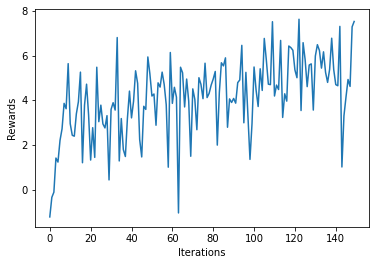

 15%|███████████▎                                                               | 15106/100000 [08:09<50:50, 27.83it/s]

Updated Weights
Mean Reward = 6.99
35


 15%|███████████▍                                                               | 15206/100000 [08:13<51:30, 27.44it/s]

Updated Weights
Mean Reward = 6.17
31


 15%|███████████▍                                                               | 15305/100000 [08:16<48:44, 28.96it/s]

Updated Weights
Mean Reward = 2.01
19


 15%|███████████▌                                                               | 15405/100000 [08:19<49:27, 28.51it/s]

Updated Weights
Mean Reward = 6.47
30


 15%|███████████▌                                                               | 15499/100000 [08:23<53:24, 26.37it/s]

Updated Weights
Mean Reward = 4.95
28


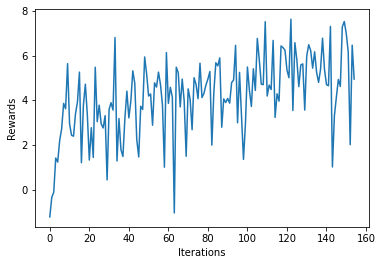

 16%|███████████▋                                                               | 15607/100000 [08:26<43:05, 32.64it/s]

Updated Weights
Mean Reward = 6.14
35


 16%|███████████▊                                                               | 15705/100000 [08:29<47:02, 29.86it/s]

Updated Weights
Mean Reward = 6.86
37


 16%|███████████▊                                                               | 15806/100000 [08:33<41:21, 33.92it/s]

Updated Weights
Mean Reward = 4.45
31


 16%|███████████▉                                                               | 15905/100000 [08:36<45:23, 30.87it/s]

Updated Weights
Mean Reward = 7.06
33


 16%|███████████▉                                                               | 15999/100000 [08:39<56:13, 24.90it/s]

Updated Weights
Mean Reward = 6.36
29


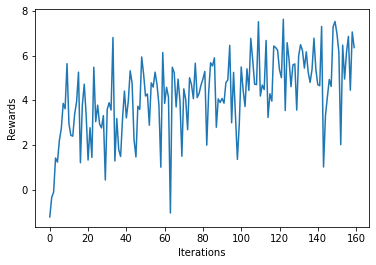

 16%|████████████                                                               | 16106/100000 [08:43<44:12, 31.63it/s]

Updated Weights
Mean Reward = 4.99
28


 16%|████████████▏                                                              | 16206/100000 [08:46<51:05, 27.34it/s]

Updated Weights
Mean Reward = 7.67
36


 16%|████████████▏                                                              | 16306/100000 [08:50<45:40, 30.54it/s]

Updated Weights
Mean Reward = 5.68
30


 16%|████████████▎                                                              | 16405/100000 [08:53<42:59, 32.41it/s]

Updated Weights
Mean Reward = 4.82
26


 16%|████████████▍                                                              | 16500/100000 [08:56<47:19, 29.40it/s]

Updated Weights
Mean Reward = 7.04
35


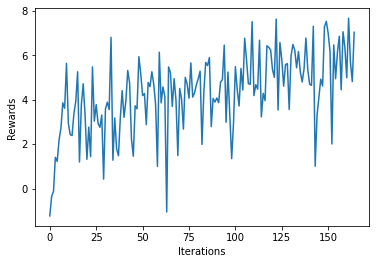

 17%|████████████▍                                                              | 16604/100000 [09:00<42:57, 32.35it/s]

Updated Weights
Mean Reward = 6.42
37


 17%|████████████▌                                                              | 16703/100000 [09:03<45:14, 30.68it/s]

Updated Weights
Mean Reward = 6.98
33


 17%|████████████▌                                                              | 16805/100000 [09:06<47:39, 29.10it/s]

Updated Weights
Mean Reward = 6.43
32


 17%|████████████▋                                                              | 16905/100000 [09:10<50:13, 27.58it/s]

Updated Weights
Mean Reward = 5.86
29


 17%|████████████▋                                                              | 16999/100000 [09:13<51:18, 26.96it/s]

Updated Weights
Mean Reward = 4.88
19


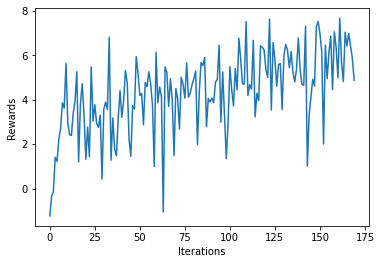

 17%|████████████▊                                                              | 17106/100000 [09:17<47:32, 29.06it/s]

Updated Weights
Mean Reward = 5.76
29


 17%|████████████▉                                                              | 17206/100000 [09:21<44:50, 30.78it/s]

Updated Weights
Mean Reward = 5.21
24


 17%|████████████▉                                                              | 17304/100000 [09:24<48:42, 28.30it/s]

Updated Weights
Mean Reward = 5.82
26


 17%|█████████████                                                              | 17407/100000 [09:28<46:44, 29.45it/s]

Updated Weights
Mean Reward = 5.35
26


 17%|█████████████                                                              | 17497/100000 [09:31<45:25, 30.27it/s]

Updated Weights
Mean Reward = 8.63
43


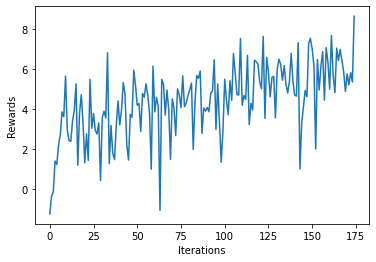

 18%|█████████████▏                                                             | 17603/100000 [09:34<44:45, 30.68it/s]

Updated Weights
Mean Reward = 8.29
41


 18%|█████████████▎                                                             | 17704/100000 [09:38<49:04, 27.95it/s]

Updated Weights
Mean Reward = 7.41
41


 18%|█████████████▎                                                             | 17804/100000 [09:41<54:12, 25.27it/s]

Updated Weights
Mean Reward = 2.51
28


 18%|█████████████▍                                                             | 17903/100000 [09:45<48:55, 27.97it/s]

Updated Weights
Mean Reward = 6.09
28


 18%|█████████████▍                                                             | 17998/100000 [09:49<51:20, 26.62it/s]

Updated Weights
Mean Reward = 5.47
26


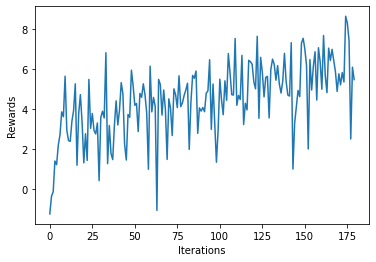

 18%|█████████████▌                                                             | 18106/100000 [09:53<45:33, 29.96it/s]

Updated Weights
Mean Reward = 5.47
21


 18%|█████████████▋                                                             | 18207/100000 [09:56<39:32, 34.47it/s]

Updated Weights
Mean Reward = 4.25
22


 18%|█████████████▋                                                             | 18307/100000 [10:00<46:59, 28.97it/s]

Updated Weights
Mean Reward = -0.48
9


 18%|█████████████▊                                                             | 18403/100000 [10:03<50:34, 26.89it/s]

Updated Weights
Mean Reward = 3.57
12


 18%|█████████████▉                                                             | 18500/100000 [10:06<45:29, 29.86it/s]

Updated Weights
Mean Reward = 6.57
25


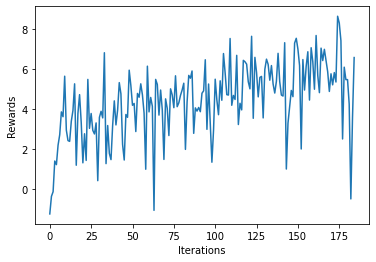

 19%|█████████████▉                                                             | 18609/100000 [10:10<38:46, 34.98it/s]

Updated Weights
Mean Reward = 7.4
31


 19%|██████████████                                                             | 18708/100000 [10:13<37:03, 36.56it/s]

Updated Weights
Mean Reward = 8.58
40


 19%|██████████████                                                             | 18806/100000 [10:16<43:54, 30.81it/s]

Updated Weights
Mean Reward = 7.19
34


 19%|██████████████▏                                                            | 18908/100000 [10:19<41:39, 32.45it/s]

Updated Weights
Mean Reward = 5.95
30


 19%|██████████████▏                                                            | 18997/100000 [10:22<41:31, 32.51it/s]

Updated Weights
Mean Reward = 5.83
37


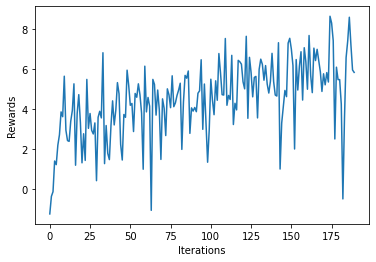

 19%|██████████████▎                                                            | 19106/100000 [10:25<44:06, 30.56it/s]

Updated Weights
Mean Reward = 7.08
32


 19%|██████████████▍                                                            | 19206/100000 [10:29<43:50, 30.71it/s]

Updated Weights
Mean Reward = 5.62
25


 19%|██████████████▍                                                            | 19306/100000 [10:32<50:55, 26.41it/s]

Updated Weights
Mean Reward = 4.09
15


 19%|██████████████▌                                                            | 19405/100000 [10:35<44:23, 30.26it/s]

Updated Weights
Mean Reward = 6.98
31


 20%|██████████████▋                                                            | 19500/100000 [10:38<42:06, 31.86it/s]

Updated Weights
Mean Reward = 6.16
35


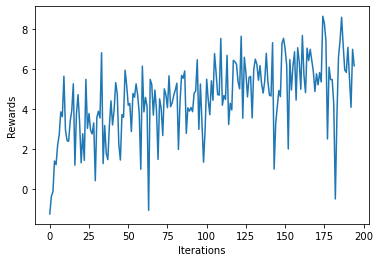

 20%|██████████████▋                                                            | 19606/100000 [10:42<46:02, 29.10it/s]

Updated Weights
Mean Reward = 5.24
32


 20%|██████████████▊                                                            | 19708/100000 [10:45<38:02, 35.18it/s]

Updated Weights
Mean Reward = 6.05
35


 20%|██████████████▊                                                            | 19805/100000 [10:48<39:29, 33.84it/s]

Updated Weights
Mean Reward = 5.68
31


 20%|██████████████▉                                                            | 19908/100000 [10:51<40:07, 33.27it/s]

Updated Weights
Mean Reward = 4.47
17


 20%|██████████████▉                                                            | 19998/100000 [10:54<40:17, 33.09it/s]

Updated Weights
Mean Reward = 6.16
25


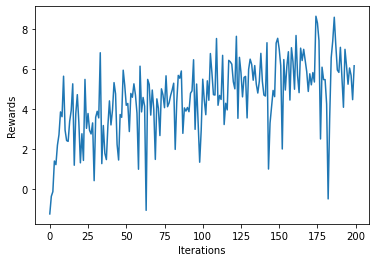

 20%|███████████████                                                            | 20102/100000 [10:58<39:17, 33.89it/s]

Updated Weights
Mean Reward = 8.2
38


 20%|███████████████▏                                                           | 20206/100000 [11:01<40:56, 32.48it/s]

Updated Weights
Mean Reward = 6.15
27


 20%|███████████████▏                                                           | 20305/100000 [11:04<39:53, 33.29it/s]

Updated Weights
Mean Reward = 7.44
39


 20%|███████████████▎                                                           | 20403/100000 [11:07<41:12, 32.20it/s]

Updated Weights
Mean Reward = 7.04
35


 20%|███████████████▎                                                           | 20500/100000 [11:10<40:12, 32.95it/s]

Updated Weights
Mean Reward = 6.72
33


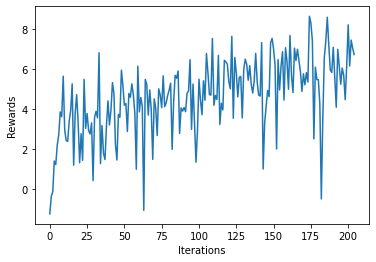

 21%|███████████████▍                                                           | 20608/100000 [11:14<40:23, 32.76it/s]

Updated Weights
Mean Reward = 8.84
47


 21%|███████████████▌                                                           | 20704/100000 [11:16<37:59, 34.78it/s]

Updated Weights
Mean Reward = 5.36
39


 21%|███████████████▌                                                           | 20807/100000 [11:20<42:07, 31.33it/s]

Updated Weights
Mean Reward = 1.27
16


 21%|███████████████▋                                                           | 20906/100000 [11:23<44:48, 29.42it/s]

Updated Weights
Mean Reward = 5.88
35


 21%|███████████████▋                                                           | 20999/100000 [11:26<39:19, 33.49it/s]

Updated Weights
Mean Reward = 6.7
35


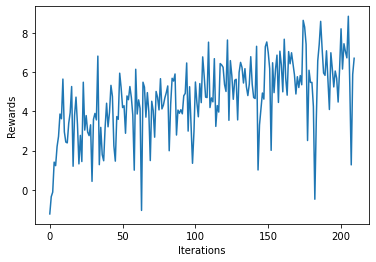

 21%|███████████████▊                                                           | 21105/100000 [11:29<48:06, 27.33it/s]

Updated Weights
Mean Reward = 6.92
36


 21%|███████████████▉                                                           | 21205/100000 [11:32<43:42, 30.04it/s]

Updated Weights
Mean Reward = 7.45
32


 21%|███████████████▉                                                           | 21305/100000 [11:36<47:38, 27.53it/s]

Updated Weights
Mean Reward = 3.52
8


 21%|████████████████                                                           | 21405/100000 [11:40<48:55, 26.78it/s]

Updated Weights
Mean Reward = -0.03
12


 22%|████████████████▏                                                          | 21500/100000 [11:43<48:01, 27.24it/s]

Updated Weights
Mean Reward = -5.91
8


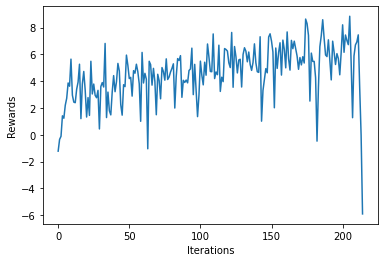

 22%|████████████████▏                                                          | 21606/100000 [11:47<46:18, 28.21it/s]

Updated Weights
Mean Reward = -2.19
7


 22%|████████████████▎                                                          | 21705/100000 [11:51<46:07, 28.29it/s]

Updated Weights
Mean Reward = -3.64
12


 22%|████████████████▎                                                          | 21804/100000 [11:54<45:23, 28.71it/s]

Updated Weights
Mean Reward = -2.46
15


 22%|████████████████▍                                                          | 21906/100000 [11:58<48:29, 26.84it/s]

Updated Weights
Mean Reward = -4.01
16


 22%|████████████████▍                                                          | 21999/100000 [12:01<47:24, 27.42it/s]

Updated Weights
Mean Reward = -5.08
13


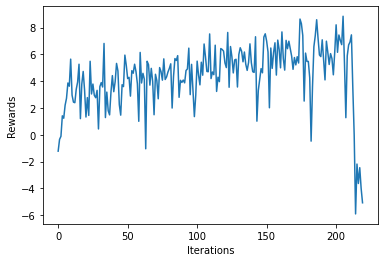

 22%|████████████████▌                                                          | 22106/100000 [12:05<48:59, 26.50it/s]

Updated Weights
Mean Reward = -8.17
10


 22%|████████████████▋                                                          | 22205/100000 [12:09<41:48, 31.01it/s]

Updated Weights
Mean Reward = -0.76
18


 22%|████████████████▋                                                          | 22306/100000 [12:12<45:08, 28.69it/s]

Updated Weights
Mean Reward = -0.28
22


 22%|████████████████▊                                                          | 22405/100000 [12:15<38:44, 33.38it/s]

Updated Weights
Mean Reward = 4.36
32


 22%|████████████████▉                                                          | 22500/100000 [12:18<46:02, 28.05it/s]

Updated Weights
Mean Reward = -0.34
22


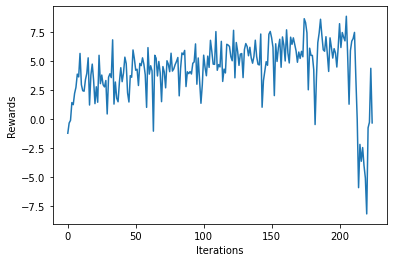

 23%|████████████████▉                                                          | 22604/100000 [12:22<44:49, 28.77it/s]

Updated Weights
Mean Reward = 2.92
32


 23%|█████████████████                                                          | 22705/100000 [12:25<39:51, 32.32it/s]

Updated Weights
Mean Reward = 5.08
26


 23%|█████████████████                                                          | 22807/100000 [12:28<36:20, 35.40it/s]

Updated Weights
Mean Reward = 2.76
36


 23%|█████████████████▏                                                         | 22903/100000 [12:31<47:15, 27.19it/s]

Updated Weights
Mean Reward = 3.75
30


 23%|█████████████████▎                                                         | 23000/100000 [12:35<45:45, 28.05it/s]

Updated Weights
Mean Reward = 3.22
22


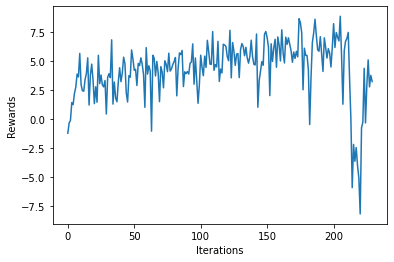

 23%|█████████████████▎                                                         | 23104/100000 [12:38<46:08, 27.78it/s]

Updated Weights
Mean Reward = 3.62
25


 23%|█████████████████▍                                                         | 23207/100000 [12:41<38:10, 33.53it/s]

Updated Weights
Mean Reward = 4.85
29


 23%|█████████████████▍                                                         | 23306/100000 [12:45<41:11, 31.03it/s]

Updated Weights
Mean Reward = 3.42
26


 23%|█████████████████▌                                                         | 23405/100000 [12:48<36:11, 35.27it/s]

Updated Weights
Mean Reward = 5.34
26


 23%|█████████████████▌                                                         | 23499/100000 [12:51<39:17, 32.44it/s]

Updated Weights
Mean Reward = 3.43
35


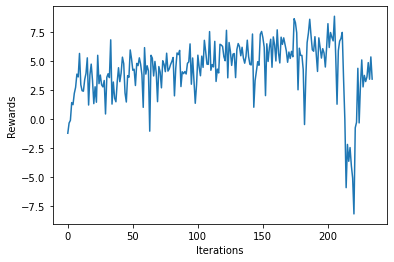

 24%|█████████████████▋                                                         | 23606/100000 [12:54<36:53, 34.52it/s]

Updated Weights
Mean Reward = 5.12
32


 24%|█████████████████▊                                                         | 23707/100000 [12:57<39:23, 32.28it/s]

Updated Weights
Mean Reward = 4.44
29


 24%|█████████████████▊                                                         | 23806/100000 [13:01<41:31, 30.58it/s]

Updated Weights
Mean Reward = 4.63
28


 24%|█████████████████▉                                                         | 23905/100000 [13:04<39:17, 32.27it/s]

Updated Weights
Mean Reward = 6.58
33


 24%|██████████████████                                                         | 24000/100000 [13:07<47:07, 26.88it/s]

Updated Weights
Mean Reward = 4.79
14


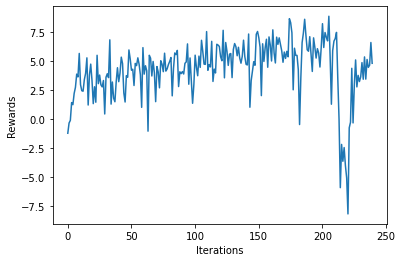

 24%|██████████████████                                                         | 24105/100000 [13:11<43:10, 29.30it/s]

Updated Weights
Mean Reward = 5.96
20


 24%|██████████████████▏                                                        | 24204/100000 [13:14<47:19, 26.69it/s]

Updated Weights
Mean Reward = 6.12
16


 24%|██████████████████▏                                                        | 24305/100000 [13:18<47:42, 26.44it/s]

Updated Weights
Mean Reward = 5.84
16


 24%|██████████████████▎                                                        | 24406/100000 [13:22<45:09, 27.90it/s]

Updated Weights
Mean Reward = 7.18
20


 24%|██████████████████▎                                                        | 24498/100000 [13:25<42:18, 29.74it/s]

Updated Weights
Mean Reward = 7.35
27


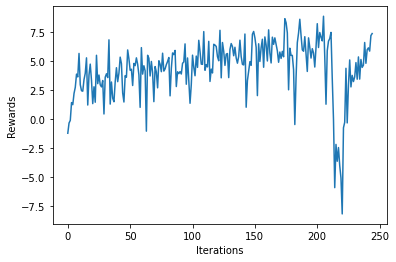

 25%|██████████████████▍                                                        | 24605/100000 [13:28<46:08, 27.23it/s]

Updated Weights
Mean Reward = 5.38
17


 25%|██████████████████▌                                                        | 24704/100000 [13:32<40:29, 30.99it/s]

Updated Weights
Mean Reward = 7.69
33


 25%|██████████████████▌                                                        | 24806/100000 [13:35<38:05, 32.90it/s]

Updated Weights
Mean Reward = 6.09
25


 25%|██████████████████▋                                                        | 24905/100000 [13:38<38:55, 32.15it/s]

Updated Weights
Mean Reward = 7.69
38


 25%|██████████████████▋                                                        | 24999/100000 [13:41<42:47, 29.21it/s]

Updated Weights
Mean Reward = 6.84
25


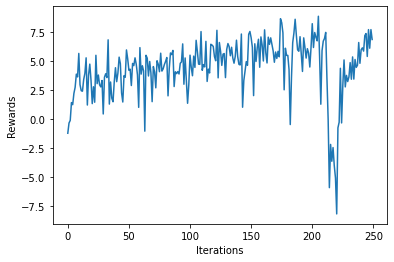

 25%|██████████████████▊                                                        | 25107/100000 [13:45<36:33, 34.14it/s]

Updated Weights
Mean Reward = 6.47
25


 25%|██████████████████▉                                                        | 25207/100000 [13:48<40:14, 30.98it/s]

Updated Weights
Mean Reward = 5.66
24


 25%|██████████████████▉                                                        | 25307/100000 [13:52<42:14, 29.47it/s]

Updated Weights
Mean Reward = 6.15
22


 25%|███████████████████                                                        | 25403/100000 [13:55<45:17, 27.45it/s]

Updated Weights
Mean Reward = 8.25
32


 25%|███████████████████                                                        | 25498/100000 [13:58<41:29, 29.93it/s]

Updated Weights
Mean Reward = 8.26
35


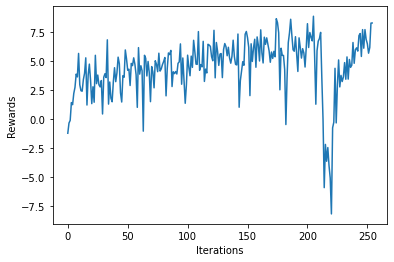

 26%|███████████████████▏                                                       | 25604/100000 [14:01<39:40, 31.26it/s]

Updated Weights
Mean Reward = 6.65
29


 26%|███████████████████▎                                                       | 25706/100000 [14:05<44:56, 27.55it/s]

Updated Weights
Mean Reward = 5.46
20


 26%|███████████████████▎                                                       | 25804/100000 [14:08<42:20, 29.21it/s]

Updated Weights
Mean Reward = 7.69
32


 26%|███████████████████▍                                                       | 25905/100000 [14:11<34:01, 36.30it/s]

Updated Weights
Mean Reward = 8.39
46


 26%|███████████████████▍                                                       | 25997/100000 [14:14<42:19, 29.14it/s]

Updated Weights
Mean Reward = 5.65
22


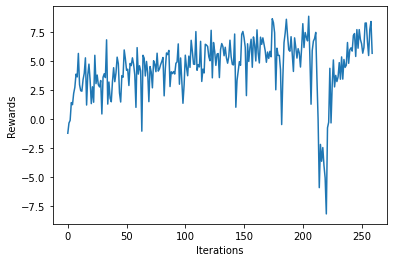

 26%|███████████████████▌                                                       | 26107/100000 [14:18<41:54, 29.38it/s]

Updated Weights
Mean Reward = 7.21
30


 26%|███████████████████▋                                                       | 26204/100000 [14:21<41:38, 29.53it/s]

Updated Weights
Mean Reward = 8.07
35


 26%|███████████████████▋                                                       | 26304/100000 [14:24<40:41, 30.19it/s]

Updated Weights
Mean Reward = 6.23
26


 26%|███████████████████▊                                                       | 26407/100000 [14:27<39:40, 30.92it/s]

Updated Weights
Mean Reward = 7.67
33


 26%|███████████████████▉                                                       | 26500/100000 [14:30<36:57, 33.15it/s]

Updated Weights
Mean Reward = 7.05
33


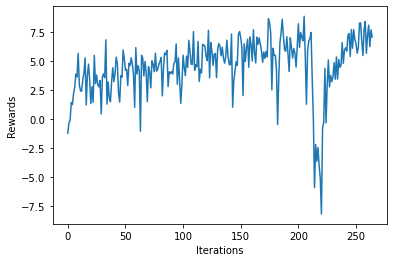

 27%|███████████████████▉                                                       | 26606/100000 [14:34<44:20, 27.59it/s]

Updated Weights
Mean Reward = 6.25
30


 27%|████████████████████                                                       | 26703/100000 [14:37<42:12, 28.94it/s]

Updated Weights
Mean Reward = 7.31
29


 27%|████████████████████                                                       | 26808/100000 [14:41<34:49, 35.03it/s]

Updated Weights
Mean Reward = 7.47
29


 27%|████████████████████▏                                                      | 26906/100000 [14:43<42:35, 28.61it/s]

Updated Weights
Mean Reward = 10.8
50


 27%|████████████████████▎                                                      | 27000/100000 [14:46<34:15, 35.52it/s]

Updated Weights
Mean Reward = 8.85
43


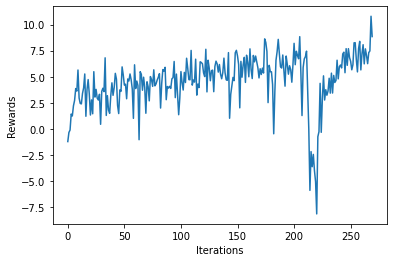

 27%|████████████████████▎                                                      | 27104/100000 [14:50<40:15, 30.18it/s]

Updated Weights
Mean Reward = 7.86
30


 27%|████████████████████▍                                                      | 27206/100000 [14:53<38:11, 31.76it/s]

Updated Weights
Mean Reward = 7.53
30


 27%|████████████████████▍                                                      | 27307/100000 [14:56<36:45, 32.96it/s]

Updated Weights
Mean Reward = 8.83
41


 27%|████████████████████▌                                                      | 27403/100000 [14:59<43:15, 27.97it/s]

Updated Weights
Mean Reward = 7.14
32


 27%|████████████████████▌                                                      | 27498/100000 [15:02<34:16, 35.26it/s]

Updated Weights
Mean Reward = 7.03
31


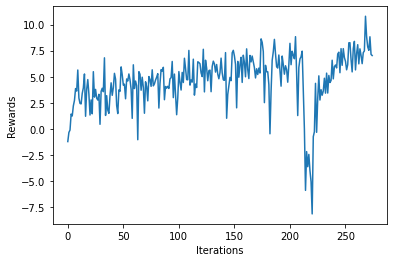

 28%|████████████████████▋                                                      | 27606/100000 [15:05<38:32, 31.31it/s]

Updated Weights
Mean Reward = 8.75
42


 28%|████████████████████▊                                                      | 27707/100000 [15:08<31:13, 38.60it/s]

Updated Weights
Mean Reward = 9.54
46


 28%|████████████████████▊                                                      | 27806/100000 [15:12<39:22, 30.55it/s]

Updated Weights
Mean Reward = 8.51
40


 28%|████████████████████▉                                                      | 27905/100000 [15:15<39:56, 30.08it/s]

Updated Weights
Mean Reward = 7.53
39


 28%|████████████████████▉                                                      | 27997/100000 [15:18<34:23, 34.90it/s]

Updated Weights
Mean Reward = 6.54
35


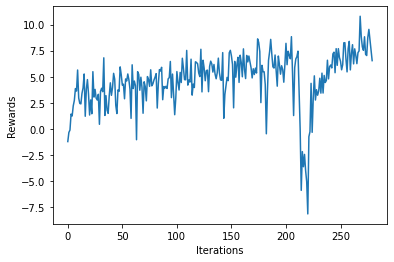

 28%|█████████████████████                                                      | 28104/100000 [15:21<39:15, 30.52it/s]

Updated Weights
Mean Reward = 7.49
37


 28%|█████████████████████▏                                                     | 28206/100000 [15:24<40:22, 29.63it/s]

Updated Weights
Mean Reward = 6.82
35


 28%|█████████████████████▏                                                     | 28302/100000 [15:27<37:47, 31.62it/s]

Updated Weights
Mean Reward = 7.35
32


 28%|█████████████████████▎                                                     | 28406/100000 [15:31<32:47, 36.38it/s]

Updated Weights
Mean Reward = 7.56
40


 28%|█████████████████████▎                                                     | 28499/100000 [15:33<35:39, 33.41it/s]

Updated Weights
Mean Reward = 10.11
49


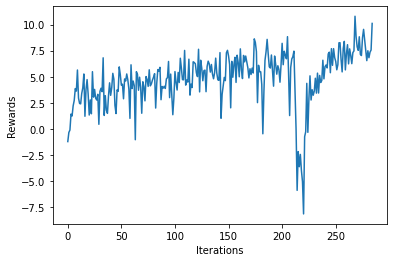

 29%|█████████████████████▍                                                     | 28604/100000 [15:36<34:28, 34.51it/s]

Updated Weights
Mean Reward = 9.45
51


 29%|█████████████████████▌                                                     | 28708/100000 [15:39<34:49, 34.13it/s]

Updated Weights
Mean Reward = 7.58
37


 29%|█████████████████████▌                                                     | 28807/100000 [15:42<35:20, 33.57it/s]

Updated Weights
Mean Reward = 8.27
44


 29%|█████████████████████▋                                                     | 28905/100000 [15:45<33:07, 35.77it/s]

Updated Weights
Mean Reward = 8.05
41


 29%|█████████████████████▋                                                     | 28999/100000 [15:48<30:23, 38.93it/s]

Updated Weights
Mean Reward = 10.4
57


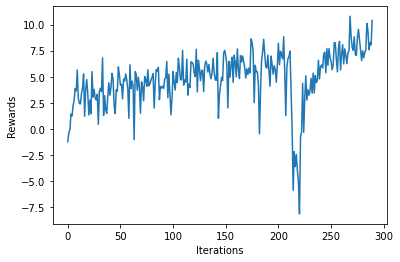

 29%|█████████████████████▊                                                     | 29105/100000 [15:51<37:40, 31.36it/s]

Updated Weights
Mean Reward = 7.68
36


 29%|█████████████████████▉                                                     | 29205/100000 [15:54<38:40, 30.51it/s]

Updated Weights
Mean Reward = 9.21
44


 29%|█████████████████████▉                                                     | 29304/100000 [15:57<30:48, 38.24it/s]

Updated Weights
Mean Reward = 5.42
32


 29%|██████████████████████                                                     | 29404/100000 [16:00<35:15, 33.38it/s]

Updated Weights
Mean Reward = 8.68
41


 30%|██████████████████████▏                                                    | 29500/100000 [16:03<33:53, 34.66it/s]

Updated Weights
Mean Reward = 9.53
45


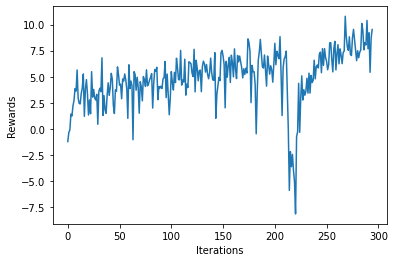

 30%|██████████████████████▏                                                    | 29607/100000 [16:06<30:56, 37.93it/s]

Updated Weights
Mean Reward = 5.62
40


 30%|██████████████████████▎                                                    | 29703/100000 [16:09<43:21, 27.02it/s]

Updated Weights
Mean Reward = 4.31
39


 30%|██████████████████████▎                                                    | 29805/100000 [16:13<44:21, 26.37it/s]

Updated Weights
Mean Reward = 2.0
10


 30%|██████████████████████▍                                                    | 29906/100000 [16:16<38:50, 30.07it/s]

Updated Weights
Mean Reward = -0.72
17


 30%|██████████████████████▍                                                    | 29999/100000 [16:19<37:47, 30.87it/s]

Updated Weights
Mean Reward = 4.12
21


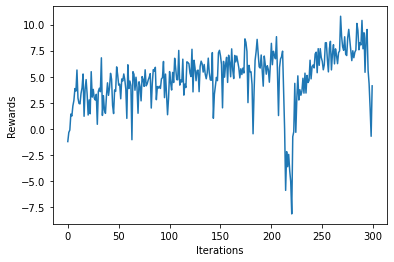

 30%|██████████████████████▌                                                    | 30104/100000 [16:23<42:00, 27.73it/s]

Updated Weights
Mean Reward = 2.34
12


 30%|██████████████████████▋                                                    | 30206/100000 [16:27<38:39, 30.09it/s]

Updated Weights
Mean Reward = 1.78
17


 30%|██████████████████████▋                                                    | 30306/100000 [16:30<43:38, 26.61it/s]

Updated Weights
Mean Reward = -0.4
19


 30%|██████████████████████▊                                                    | 30403/100000 [16:34<46:15, 25.08it/s]

Updated Weights
Mean Reward = 1.29
10


 30%|██████████████████████▊                                                    | 30498/100000 [16:38<42:54, 27.00it/s]

Updated Weights
Mean Reward = 2.98
10


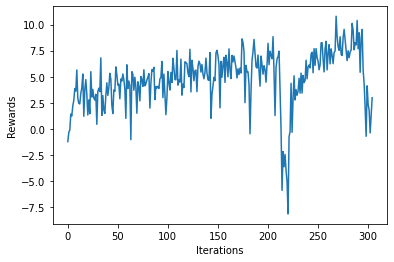

 31%|██████████████████████▉                                                    | 30604/100000 [16:42<39:24, 29.35it/s]

Updated Weights
Mean Reward = 3.73
20


 31%|███████████████████████                                                    | 30707/100000 [16:45<38:01, 30.38it/s]

Updated Weights
Mean Reward = 4.37
13


 31%|███████████████████████                                                    | 30803/100000 [16:49<39:28, 29.22it/s]

Updated Weights
Mean Reward = 5.06
18


 31%|███████████████████████▏                                                   | 30905/100000 [16:52<43:30, 26.47it/s]

Updated Weights
Mean Reward = 5.1
17


 31%|███████████████████████▎                                                   | 31000/100000 [16:55<39:43, 28.94it/s]

Updated Weights
Mean Reward = 7.66
28


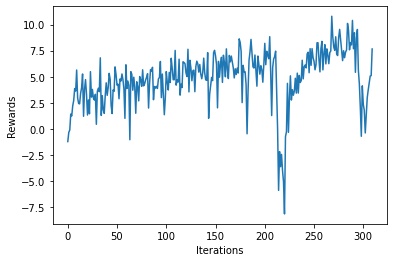

 31%|███████████████████████▎                                                   | 31106/100000 [16:59<38:38, 29.71it/s]

Updated Weights
Mean Reward = 6.01
21


 31%|███████████████████████▍                                                   | 31204/100000 [17:02<31:08, 36.81it/s]

Updated Weights
Mean Reward = 9.81
46


 31%|███████████████████████▍                                                   | 31306/100000 [17:05<33:49, 33.84it/s]

Updated Weights
Mean Reward = 8.78
39


 31%|███████████████████████▌                                                   | 31406/100000 [17:07<34:00, 33.62it/s]

Updated Weights
Mean Reward = 11.91
60


 31%|███████████████████████▌                                                   | 31498/100000 [17:10<38:24, 29.73it/s]

Updated Weights
Mean Reward = 9.52
42


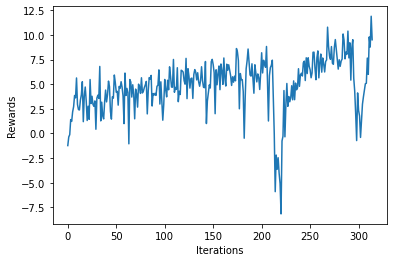

 32%|███████████████████████▋                                                   | 31606/100000 [17:14<47:18, 24.09it/s]

Updated Weights
Mean Reward = 8.04
37


 32%|███████████████████████▊                                                   | 31706/100000 [17:18<38:42, 29.41it/s]

Updated Weights
Mean Reward = 9.06
38


 32%|███████████████████████▊                                                   | 31802/100000 [17:21<46:10, 24.62it/s]

Updated Weights
Mean Reward = 7.24
27


 32%|███████████████████████▉                                                   | 31904/100000 [17:25<37:17, 30.44it/s]

Updated Weights
Mean Reward = 9.3
38


 32%|███████████████████████▉                                                   | 31998/100000 [17:29<54:14, 20.90it/s]

Updated Weights
Mean Reward = 9.21
36


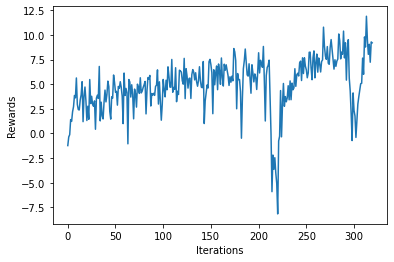

 32%|████████████████████████                                                   | 32104/100000 [17:33<38:00, 29.77it/s]

Updated Weights
Mean Reward = 9.4
40


 32%|████████████████████████▏                                                  | 32205/100000 [17:36<43:39, 25.88it/s]

Updated Weights
Mean Reward = 7.94
32


 32%|████████████████████████▏                                                  | 32303/100000 [17:40<45:03, 25.04it/s]

Updated Weights
Mean Reward = 7.47
31


 32%|████████████████████████▎                                                  | 32405/100000 [17:44<40:14, 27.99it/s]

Updated Weights
Mean Reward = 4.07
17


 32%|████████████████████████▎                                                  | 32499/100000 [17:46<32:17, 34.83it/s]

Updated Weights
Mean Reward = 11.07
50


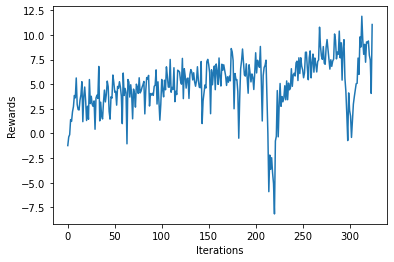

 33%|████████████████████████▍                                                  | 32605/100000 [17:50<40:22, 27.81it/s]

Updated Weights
Mean Reward = 9.0
38


 33%|████████████████████████▌                                                  | 32702/100000 [17:53<41:32, 27.00it/s]

Updated Weights
Mean Reward = 9.73
44


 33%|████████████████████████▌                                                  | 32804/100000 [17:58<50:33, 22.15it/s]

Updated Weights
Mean Reward = 6.76
39


 33%|████████████████████████▋                                                  | 32904/100000 [18:02<37:47, 29.59it/s]

Updated Weights
Mean Reward = 6.17
37


 33%|████████████████████████▊                                                  | 33000/100000 [18:05<40:29, 27.58it/s]

Updated Weights
Mean Reward = 5.32
20


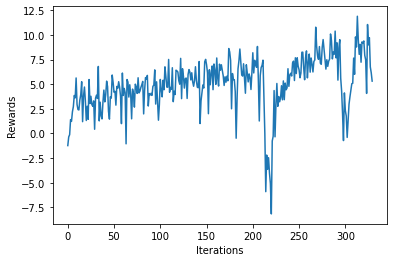

 33%|████████████████████████▊                                                  | 33108/100000 [18:08<29:02, 38.39it/s]

Updated Weights
Mean Reward = 7.54
44


 33%|████████████████████████▉                                                  | 33203/100000 [18:12<59:07, 18.83it/s]

Updated Weights
Mean Reward = 5.73
25


 33%|████████████████████████▉                                                  | 33305/100000 [18:17<41:36, 26.71it/s]

Updated Weights
Mean Reward = 2.46
11


 33%|█████████████████████████                                                  | 33404/100000 [18:20<37:49, 29.34it/s]

Updated Weights
Mean Reward = 8.64
32


 33%|█████████████████████████                                                  | 33498/100000 [18:23<34:18, 32.30it/s]

Updated Weights
Mean Reward = 11.83
56


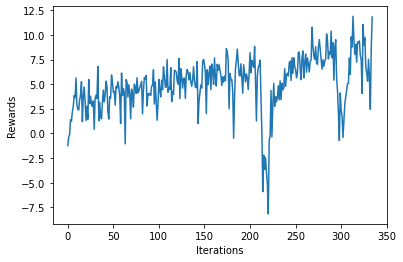

 34%|█████████████████████████▏                                                 | 33603/100000 [18:27<47:59, 23.06it/s]

Updated Weights
Mean Reward = 8.41
31


 34%|█████████████████████████▎                                                 | 33702/100000 [18:31<37:29, 29.47it/s]

Updated Weights
Mean Reward = 11.96
54


 34%|█████████████████████████▎                                                 | 33806/100000 [18:34<36:45, 30.02it/s]

Updated Weights
Mean Reward = 9.99
42


 34%|█████████████████████████▍                                                 | 33907/100000 [18:37<33:40, 32.71it/s]

Updated Weights
Mean Reward = 8.06
38


 34%|█████████████████████████▌                                                 | 34000/100000 [18:40<30:26, 36.13it/s]

Updated Weights
Mean Reward = 9.25
57


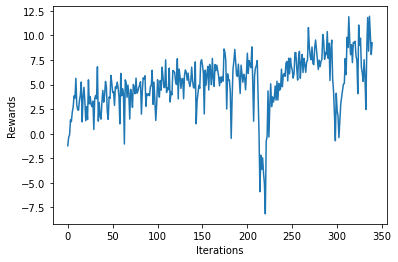

 34%|█████████████████████████▌                                                 | 34105/100000 [18:44<42:07, 26.07it/s]

Updated Weights
Mean Reward = 7.63
35


 34%|█████████████████████████▋                                                 | 34207/100000 [18:47<28:43, 38.17it/s]

Updated Weights
Mean Reward = 8.06
36


 34%|█████████████████████████▋                                                 | 34305/100000 [18:50<35:38, 30.72it/s]

Updated Weights
Mean Reward = 8.32
48


 34%|█████████████████████████▊                                                 | 34405/100000 [18:53<40:58, 26.69it/s]

Updated Weights
Mean Reward = 9.78
44


 34%|█████████████████████████▊                                                 | 34498/100000 [18:57<32:01, 34.09it/s]

Updated Weights
Mean Reward = 7.63
42


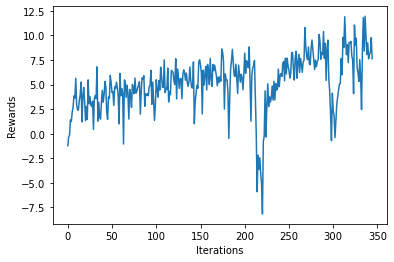

 35%|█████████████████████████▉                                                 | 34604/100000 [19:00<36:12, 30.10it/s]

Updated Weights
Mean Reward = 10.11
45


 35%|██████████████████████████                                                 | 34705/100000 [19:04<39:38, 27.46it/s]

Updated Weights
Mean Reward = 10.53
49


 35%|██████████████████████████                                                 | 34806/100000 [19:07<38:11, 28.46it/s]

Updated Weights
Mean Reward = 8.72
38


 35%|██████████████████████████▏                                                | 34902/100000 [19:11<52:07, 20.82it/s]

Updated Weights
Mean Reward = 7.9
44


 35%|██████████████████████████▎                                                | 35000/100000 [19:14<36:12, 29.92it/s]

Updated Weights
Mean Reward = 8.7
43


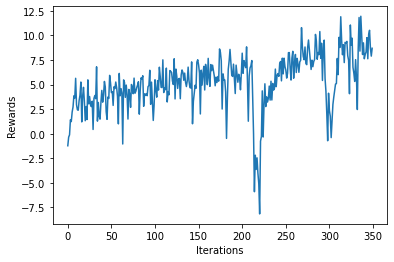

 35%|██████████████████████████▎                                                | 35104/100000 [19:18<41:35, 26.00it/s]

Updated Weights
Mean Reward = 8.31
35


 35%|██████████████████████████▍                                                | 35203/100000 [19:22<40:09, 26.90it/s]

Updated Weights
Mean Reward = 6.95
29


 35%|██████████████████████████▍                                                | 35305/100000 [19:25<37:53, 28.45it/s]

Updated Weights
Mean Reward = 5.72
34


 35%|██████████████████████████▌                                                | 35405/100000 [19:29<37:55, 28.38it/s]

Updated Weights
Mean Reward = 7.48
30


 35%|██████████████████████████▌                                                | 35497/100000 [19:31<29:23, 36.58it/s]

Updated Weights
Mean Reward = 10.26
47


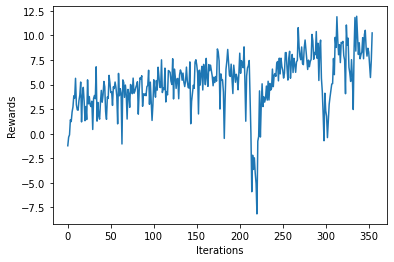

 36%|██████████████████████████▋                                                | 35605/100000 [19:35<32:36, 32.91it/s]

Updated Weights
Mean Reward = 8.3
47


 36%|██████████████████████████▊                                                | 35705/100000 [19:38<31:13, 34.33it/s]

Updated Weights
Mean Reward = 6.0
42


 36%|██████████████████████████▊                                                | 35809/100000 [19:41<32:31, 32.89it/s]

Updated Weights
Mean Reward = 7.11
45


 36%|██████████████████████████▉                                                | 35909/100000 [19:44<29:13, 36.54it/s]

Updated Weights
Mean Reward = 7.92
58


 36%|██████████████████████████▉                                                | 35995/100000 [19:46<29:30, 36.15it/s]

Updated Weights
Mean Reward = 12.49
68


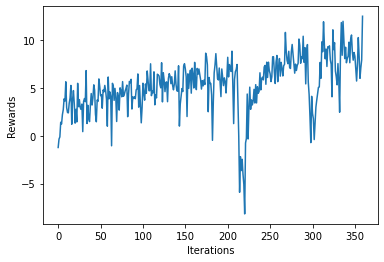

 36%|███████████████████████████                                                | 36106/100000 [19:49<31:43, 33.56it/s]

Updated Weights
Mean Reward = 11.52
56


 36%|███████████████████████████▏                                               | 36208/100000 [19:52<29:34, 35.96it/s]

Updated Weights
Mean Reward = 9.72
49


 36%|███████████████████████████▏                                               | 36304/100000 [19:55<33:18, 31.86it/s]

Updated Weights
Mean Reward = 9.47
51


 36%|███████████████████████████▎                                               | 36404/100000 [19:59<40:23, 26.24it/s]

Updated Weights
Mean Reward = 7.62
55


 36%|███████████████████████████▎                                               | 36498/100000 [20:02<33:07, 31.95it/s]

Updated Weights
Mean Reward = 7.71
50


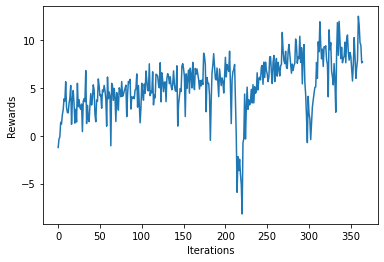

 37%|███████████████████████████▍                                               | 36603/100000 [20:06<43:00, 24.57it/s]

Updated Weights
Mean Reward = 8.99
57


 37%|███████████████████████████▌                                               | 36708/100000 [20:10<30:36, 34.46it/s]

Updated Weights
Mean Reward = 6.96
42


 37%|███████████████████████████▌                                               | 36805/100000 [20:13<41:47, 25.20it/s]

Updated Weights
Mean Reward = 11.63
58


 37%|███████████████████████████▋                                               | 36904/100000 [20:17<52:04, 20.19it/s]

Updated Weights
Mean Reward = 6.38
39


 37%|███████████████████████████▊                                               | 37000/100000 [20:20<35:01, 29.98it/s]

Updated Weights
Mean Reward = 8.23
53


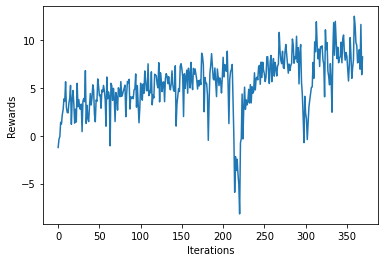

 37%|███████████████████████████▊                                               | 37105/100000 [20:23<33:32, 31.25it/s]

Updated Weights
Mean Reward = 10.7
55


 37%|███████████████████████████▉                                               | 37204/100000 [20:27<29:11, 35.85it/s]

Updated Weights
Mean Reward = 7.61
42


 37%|███████████████████████████▉                                               | 37306/100000 [20:30<29:22, 35.58it/s]

Updated Weights
Mean Reward = 10.96
51


 37%|████████████████████████████                                               | 37405/100000 [20:33<32:22, 32.22it/s]

Updated Weights
Mean Reward = 10.62
50


 37%|████████████████████████████                                               | 37498/100000 [20:36<35:17, 29.51it/s]

Updated Weights
Mean Reward = 9.52
46


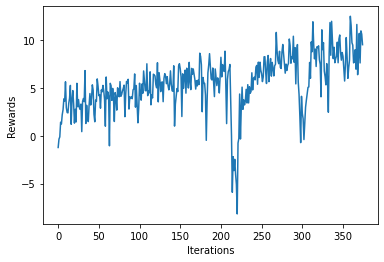

 38%|████████████████████████████▏                                              | 37604/100000 [20:40<34:20, 30.28it/s]

Updated Weights
Mean Reward = 10.92
51


 38%|████████████████████████████▎                                              | 37706/100000 [20:43<38:35, 26.91it/s]

Updated Weights
Mean Reward = -1.03
27


 38%|████████████████████████████▎                                              | 37804/100000 [20:47<45:59, 22.54it/s]

Updated Weights
Mean Reward = 5.35
28


 38%|████████████████████████████▍                                              | 37904/100000 [20:51<30:24, 34.04it/s]

Updated Weights
Mean Reward = 6.8
43


 38%|████████████████████████████▍                                              | 37998/100000 [20:54<36:58, 27.94it/s]

Updated Weights
Mean Reward = 7.6
41


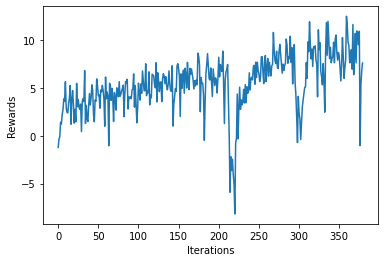

 38%|████████████████████████████▌                                              | 38105/100000 [20:57<33:42, 30.61it/s]

Updated Weights
Mean Reward = 5.41
39


 38%|████████████████████████████▋                                              | 38205/100000 [21:01<43:02, 23.93it/s]

Updated Weights
Mean Reward = 5.51
30


 38%|████████████████████████████▋                                              | 38305/100000 [21:05<37:34, 27.37it/s]

Updated Weights
Mean Reward = 3.2
35


 38%|████████████████████████████▊                                              | 38404/100000 [21:09<33:55, 30.26it/s]

Updated Weights
Mean Reward = -0.64
24


 38%|████████████████████████████▊                                              | 38499/100000 [21:12<38:45, 26.44it/s]

Updated Weights
Mean Reward = -1.07
19


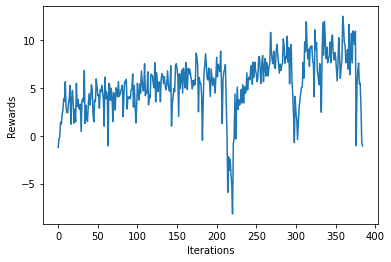

 39%|████████████████████████████▉                                              | 38605/100000 [21:17<39:53, 25.65it/s]

Updated Weights
Mean Reward = -1.47
15


 39%|█████████████████████████████                                              | 38705/100000 [21:21<41:51, 24.41it/s]

Updated Weights
Mean Reward = -2.47
11


 39%|█████████████████████████████                                              | 38802/100000 [21:24<44:38, 22.85it/s]

Updated Weights
Mean Reward = -2.04
22


 39%|█████████████████████████████▏                                             | 38907/100000 [21:29<38:26, 26.49it/s]

Updated Weights
Mean Reward = -2.6
21


 39%|█████████████████████████████▏                                             | 38998/100000 [21:33<40:11, 25.30it/s]

Updated Weights
Mean Reward = -1.09
22


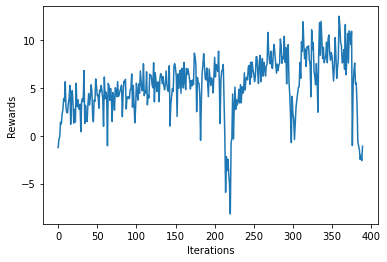

 39%|█████████████████████████████▎                                             | 39105/100000 [21:37<34:07, 29.75it/s]

Updated Weights
Mean Reward = 1.53
31


 39%|█████████████████████████████▍                                             | 39206/100000 [21:40<36:17, 27.92it/s]

Updated Weights
Mean Reward = -1.59
20


 39%|█████████████████████████████▍                                             | 39303/100000 [21:44<31:02, 32.59it/s]

Updated Weights
Mean Reward = -3.89
18


 39%|█████████████████████████████▌                                             | 39406/100000 [21:48<33:19, 30.31it/s]

Updated Weights
Mean Reward = 0.55
26


 39%|█████████████████████████████▌                                             | 39498/100000 [21:51<41:23, 24.36it/s]

Updated Weights
Mean Reward = 1.56
22


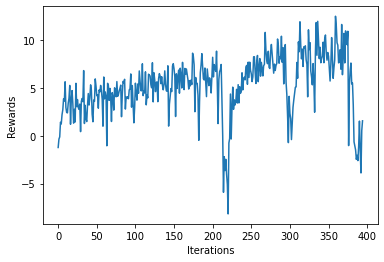

 40%|█████████████████████████████▋                                             | 39603/100000 [21:55<41:56, 24.00it/s]

Updated Weights
Mean Reward = 1.16
27


 40%|█████████████████████████████▊                                             | 39705/100000 [21:59<39:21, 25.54it/s]

Updated Weights
Mean Reward = 3.63
27


 40%|█████████████████████████████▊                                             | 39802/100000 [22:03<45:32, 22.03it/s]

Updated Weights
Mean Reward = -1.75
13


 40%|█████████████████████████████▉                                             | 39904/100000 [22:07<41:13, 24.30it/s]

Updated Weights
Mean Reward = 2.23
21


 40%|█████████████████████████████▉                                             | 39998/100000 [22:10<35:24, 28.25it/s]

Updated Weights
Mean Reward = 3.09
22


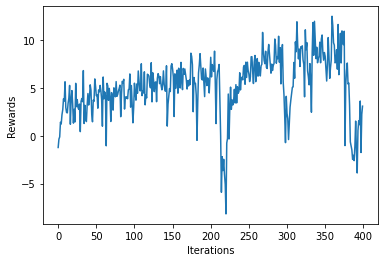

 40%|██████████████████████████████                                             | 40107/100000 [22:14<34:51, 28.64it/s]

Updated Weights
Mean Reward = 6.35
30


 40%|██████████████████████████████▏                                            | 40204/100000 [22:18<43:21, 22.99it/s]

Updated Weights
Mean Reward = 7.55
30


 40%|██████████████████████████████▏                                            | 40303/100000 [22:21<29:47, 33.40it/s]

Updated Weights
Mean Reward = 8.9
42


 40%|██████████████████████████████▎                                            | 40406/100000 [22:24<31:11, 31.84it/s]

Updated Weights
Mean Reward = 11.17
55


 40%|██████████████████████████████▎                                            | 40498/100000 [22:27<30:37, 32.39it/s]

Updated Weights
Mean Reward = 7.56
44


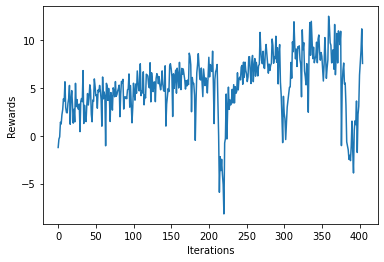

 41%|██████████████████████████████▍                                            | 40605/100000 [22:31<31:25, 31.50it/s]

Updated Weights
Mean Reward = 8.87
37


 41%|██████████████████████████████▌                                            | 40706/100000 [22:34<26:06, 37.86it/s]

Updated Weights
Mean Reward = 8.67
45


 41%|██████████████████████████████▌                                            | 40805/100000 [22:37<35:49, 27.54it/s]

Updated Weights
Mean Reward = 8.18
38


 41%|██████████████████████████████▋                                            | 40904/100000 [22:41<37:13, 26.46it/s]

Updated Weights
Mean Reward = 8.63
35


 41%|██████████████████████████████▋                                            | 41000/100000 [22:45<31:17, 31.43it/s]

Updated Weights
Mean Reward = 8.6
37


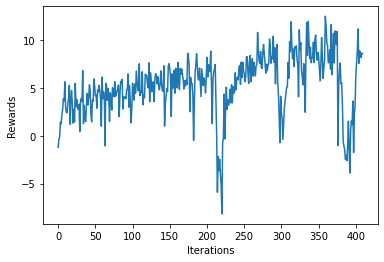

 41%|██████████████████████████████▊                                            | 41104/100000 [22:48<37:40, 26.05it/s]

Updated Weights
Mean Reward = 7.16
26


 41%|██████████████████████████████▉                                            | 41205/100000 [22:52<37:51, 25.88it/s]

Updated Weights
Mean Reward = 7.67
24


 41%|██████████████████████████████▉                                            | 41306/100000 [22:56<36:00, 27.16it/s]

Updated Weights
Mean Reward = 8.21
33


 41%|███████████████████████████████                                            | 41405/100000 [23:00<34:26, 28.36it/s]

Updated Weights
Mean Reward = 7.02
24


 41%|███████████████████████████████                                            | 41498/100000 [23:03<37:22, 26.09it/s]

Updated Weights
Mean Reward = 7.95
34


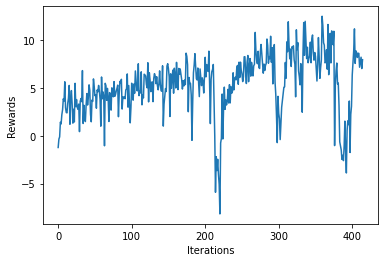

 42%|███████████████████████████████▏                                           | 41603/100000 [23:07<34:06, 28.53it/s]

Updated Weights
Mean Reward = 8.11
31


 42%|███████████████████████████████▎                                           | 41706/100000 [23:10<31:31, 30.83it/s]

Updated Weights
Mean Reward = 9.19
38


 42%|███████████████████████████████▎                                           | 41804/100000 [23:14<40:25, 24.00it/s]

Updated Weights
Mean Reward = 7.07
29


 42%|███████████████████████████████▍                                           | 41901/100000 [23:18<35:11, 27.51it/s]

Updated Weights
Mean Reward = 8.79
34


 42%|███████████████████████████████▍                                           | 41998/100000 [23:22<40:34, 23.82it/s]

Updated Weights
Mean Reward = 7.47
29


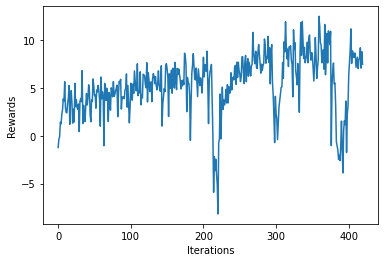

 42%|███████████████████████████████▌                                           | 42103/100000 [23:27<44:32, 21.67it/s]

Updated Weights
Mean Reward = 9.64
37


 42%|███████████████████████████████▋                                           | 42203/100000 [23:32<42:41, 22.56it/s]

Updated Weights
Mean Reward = 6.13
17


 42%|███████████████████████████████▋                                           | 42304/100000 [23:35<31:38, 30.40it/s]

Updated Weights
Mean Reward = 8.03
34


 42%|███████████████████████████████▊                                           | 42406/100000 [23:39<40:50, 23.50it/s]

Updated Weights
Mean Reward = 7.64
27


 42%|███████████████████████████████▊                                           | 42499/100000 [23:43<47:51, 20.02it/s]

Updated Weights
Mean Reward = 9.7
41


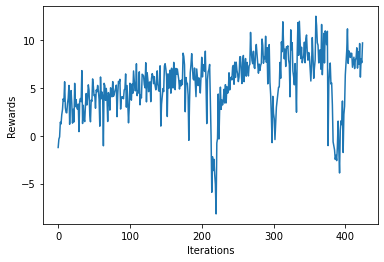

 43%|███████████████████████████████▉                                           | 42606/100000 [23:47<35:23, 27.02it/s]

Updated Weights
Mean Reward = 6.51
29


 43%|████████████████████████████████                                           | 42705/100000 [23:51<37:57, 25.15it/s]

Updated Weights
Mean Reward = 4.98
10


 43%|████████████████████████████████                                           | 42803/100000 [23:55<38:22, 24.84it/s]

Updated Weights
Mean Reward = 7.39
24


 43%|████████████████████████████████▏                                          | 42902/100000 [23:59<42:35, 22.34it/s]

Updated Weights
Mean Reward = 6.88
28


 43%|████████████████████████████████▏                                          | 42999/100000 [24:03<38:54, 24.41it/s]

Updated Weights
Mean Reward = 8.33
37


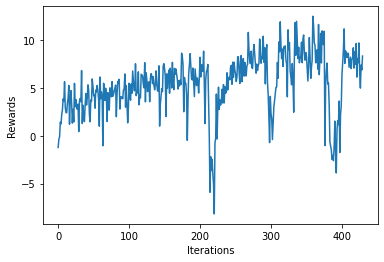

 43%|████████████████████████████████▎                                          | 43105/100000 [24:07<32:39, 29.04it/s]

Updated Weights
Mean Reward = 9.87
48


 43%|████████████████████████████████▍                                          | 43202/100000 [24:13<48:03, 19.70it/s]

Updated Weights
Mean Reward = 8.05
34


 43%|███████████████████████████████▌                                         | 43302/100000 [24:19<1:07:42, 13.96it/s]

Updated Weights
Mean Reward = 7.77
31


 43%|███████████████████████████████▋                                         | 43402/100000 [24:25<1:02:10, 15.17it/s]

Updated Weights
Mean Reward = 8.62
41


 44%|████████████████████████████████▋                                          | 43500/100000 [24:31<51:05, 18.43it/s]

Updated Weights
Mean Reward = 7.97
37


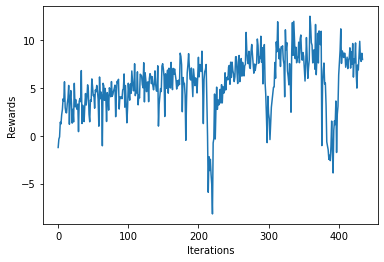

 44%|████████████████████████████████▋                                          | 43603/100000 [24:37<49:21, 19.05it/s]

Updated Weights
Mean Reward = 8.33
36


 44%|████████████████████████████████▊                                          | 43705/100000 [24:42<55:14, 16.99it/s]

Updated Weights
Mean Reward = 8.75
36


 44%|████████████████████████████████▊                                          | 43803/100000 [24:48<57:03, 16.42it/s]

Updated Weights
Mean Reward = 6.78
25


 44%|████████████████████████████████▉                                          | 43903/100000 [24:54<43:52, 21.31it/s]

Updated Weights
Mean Reward = 6.37
26


 44%|████████████████████████████████▉                                          | 43999/100000 [24:59<44:03, 21.18it/s]

Updated Weights
Mean Reward = 8.23
33


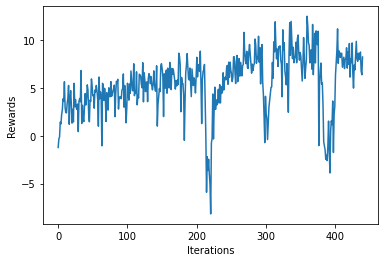

 44%|█████████████████████████████████                                          | 44102/100000 [25:04<50:22, 18.50it/s]

Updated Weights
Mean Reward = 8.01
34


 44%|█████████████████████████████████▏                                         | 44203/100000 [25:10<57:48, 16.09it/s]

Updated Weights
Mean Reward = 6.59
22


 44%|█████████████████████████████████▏                                         | 44303/100000 [25:15<49:56, 18.59it/s]

Updated Weights
Mean Reward = 7.19
27


 44%|█████████████████████████████████▎                                         | 44402/100000 [25:20<46:24, 19.97it/s]

Updated Weights
Mean Reward = 7.85
29


 44%|█████████████████████████████████▎                                         | 44499/100000 [25:25<52:09, 17.74it/s]

Updated Weights
Mean Reward = 9.64
47


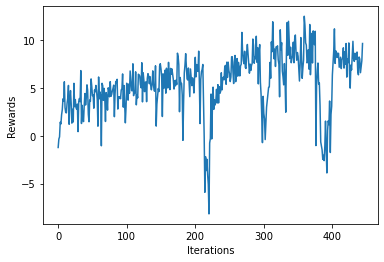

 45%|█████████████████████████████████▍                                         | 44604/100000 [25:30<52:26, 17.60it/s]

Updated Weights
Mean Reward = 8.66
42


 45%|█████████████████████████████████▌                                         | 44705/100000 [25:35<45:15, 20.36it/s]

Updated Weights
Mean Reward = 6.0
19


 45%|█████████████████████████████████▌                                         | 44803/100000 [25:40<42:34, 21.61it/s]

Updated Weights
Mean Reward = 8.28
35


 45%|█████████████████████████████████▋                                         | 44904/100000 [25:45<52:17, 17.56it/s]

Updated Weights
Mean Reward = 7.33
31


 45%|█████████████████████████████████▋                                         | 44999/100000 [25:50<47:11, 19.42it/s]

Updated Weights
Mean Reward = 7.63
35


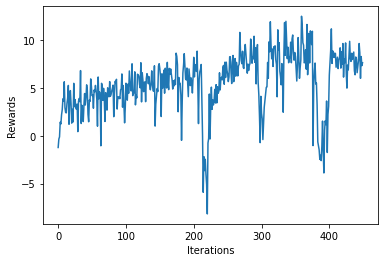

 45%|█████████████████████████████████▊                                         | 45105/100000 [25:55<42:24, 21.57it/s]

Updated Weights
Mean Reward = 9.13
31


 45%|█████████████████████████████████▉                                         | 45204/100000 [26:00<39:46, 22.96it/s]

Updated Weights
Mean Reward = 9.34
43


 45%|█████████████████████████████████▉                                         | 45303/100000 [26:05<50:35, 18.02it/s]

Updated Weights
Mean Reward = 5.58
32


 45%|██████████████████████████████████                                         | 45404/100000 [26:10<50:16, 18.10it/s]

Updated Weights
Mean Reward = 7.33
30


 46%|██████████████████████████████████▏                                        | 45500/100000 [26:15<45:52, 19.80it/s]

Updated Weights
Mean Reward = 6.52
19


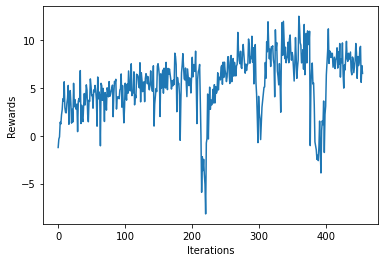

 46%|██████████████████████████████████▏                                        | 45603/100000 [26:21<44:24, 20.42it/s]

Updated Weights
Mean Reward = 9.09
44


 46%|██████████████████████████████████▎                                        | 45704/100000 [26:26<44:09, 20.50it/s]

Updated Weights
Mean Reward = 8.84
50


 46%|██████████████████████████████████▎                                        | 45803/100000 [26:30<45:37, 19.80it/s]

Updated Weights
Mean Reward = 7.96
50


 46%|██████████████████████████████████▍                                        | 45902/100000 [26:35<56:00, 16.10it/s]

Updated Weights
Mean Reward = 8.4
33


 46%|██████████████████████████████████▍                                        | 45999/100000 [26:41<53:54, 16.69it/s]

Updated Weights
Mean Reward = 1.66
15


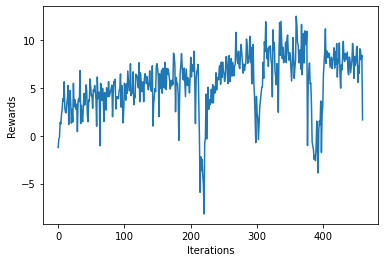

 46%|██████████████████████████████████▌                                        | 46103/100000 [26:46<50:15, 17.87it/s]

Updated Weights
Mean Reward = 3.42
43


 46%|██████████████████████████████████▋                                        | 46202/100000 [26:50<39:37, 22.63it/s]

Updated Weights
Mean Reward = 7.46
45


 46%|██████████████████████████████████▋                                        | 46305/100000 [26:55<37:28, 23.88it/s]

Updated Weights
Mean Reward = 8.46
42


 46%|██████████████████████████████████▊                                        | 46401/100000 [27:00<44:34, 20.04it/s]

Updated Weights
Mean Reward = 10.56
51


 46%|██████████████████████████████████▉                                        | 46500/100000 [27:05<40:06, 22.23it/s]

Updated Weights
Mean Reward = 9.23
43


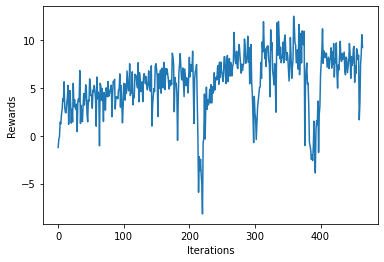

 47%|██████████████████████████████████▉                                        | 46603/100000 [27:10<43:20, 20.54it/s]

Updated Weights
Mean Reward = 8.68
44


 47%|███████████████████████████████████                                        | 46705/100000 [27:14<40:36, 21.88it/s]

Updated Weights
Mean Reward = 6.67
43


 47%|███████████████████████████████████                                        | 46804/100000 [27:20<50:45, 17.47it/s]

Updated Weights
Mean Reward = 5.74
34


 47%|███████████████████████████████████▏                                       | 46906/100000 [27:24<33:08, 26.70it/s]

Updated Weights
Mean Reward = 9.71
47


 47%|███████████████████████████████████▏                                       | 46998/100000 [27:28<36:00, 24.53it/s]

Updated Weights
Mean Reward = 9.42
45


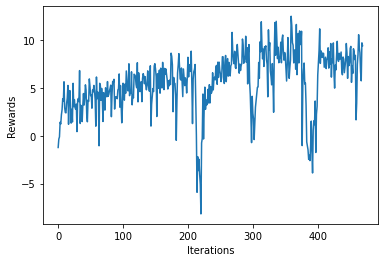

 47%|███████████████████████████████████▎                                       | 47104/100000 [27:32<32:22, 27.22it/s]

Updated Weights
Mean Reward = 10.03
55


 47%|███████████████████████████████████▍                                       | 47203/100000 [27:37<37:01, 23.77it/s]

Updated Weights
Mean Reward = 8.97
50


 47%|███████████████████████████████████▍                                       | 47304/100000 [27:41<38:13, 22.98it/s]

Updated Weights
Mean Reward = 9.3
48


 47%|███████████████████████████████████▌                                       | 47403/100000 [27:45<42:06, 20.82it/s]

Updated Weights
Mean Reward = 6.02
43


 47%|███████████████████████████████████▌                                       | 47499/100000 [27:50<51:27, 17.00it/s]

Updated Weights
Mean Reward = 3.11
17


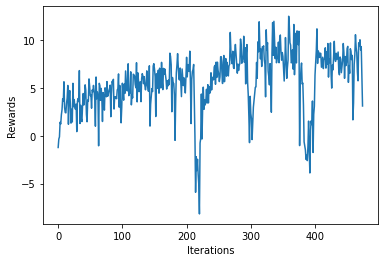

 48%|███████████████████████████████████▋                                       | 47604/100000 [27:55<37:11, 23.48it/s]

Updated Weights
Mean Reward = 9.38
42


 48%|███████████████████████████████████▊                                       | 47704/100000 [28:00<48:01, 18.15it/s]

Updated Weights
Mean Reward = 9.56
40


 48%|███████████████████████████████████▊                                       | 47805/100000 [28:04<30:03, 28.95it/s]

Updated Weights
Mean Reward = 12.53
60


 48%|███████████████████████████████████▉                                       | 47904/100000 [28:08<35:41, 24.33it/s]

Updated Weights
Mean Reward = 9.82
57


 48%|███████████████████████████████████▉                                       | 47997/100000 [28:12<28:40, 30.23it/s]

Updated Weights
Mean Reward = 10.68
60


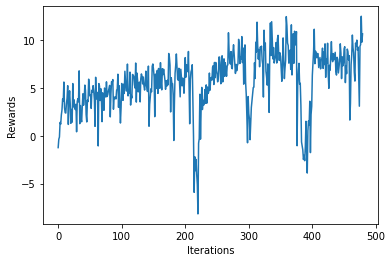

 48%|████████████████████████████████████                                       | 48103/100000 [28:16<33:09, 26.09it/s]

Updated Weights
Mean Reward = 7.38
57


 48%|████████████████████████████████████▏                                      | 48204/100000 [28:20<40:27, 21.33it/s]

Updated Weights
Mean Reward = 9.91
53


 48%|████████████████████████████████████▏                                      | 48303/100000 [28:25<40:44, 21.15it/s]

Updated Weights
Mean Reward = 7.61
51


 48%|████████████████████████████████████▎                                      | 48404/100000 [28:29<33:08, 25.94it/s]

Updated Weights
Mean Reward = 5.62
44


 48%|████████████████████████████████████▍                                      | 48500/100000 [28:32<28:05, 30.55it/s]

Updated Weights
Mean Reward = 6.24
65


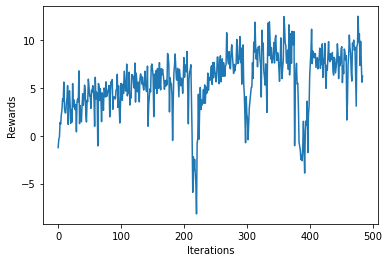

 49%|████████████████████████████████████▍                                      | 48605/100000 [28:36<39:30, 21.68it/s]

Updated Weights
Mean Reward = 6.8
53


 49%|████████████████████████████████████▌                                      | 48703/100000 [28:41<41:12, 20.75it/s]

Updated Weights
Mean Reward = 6.79
37


 49%|████████████████████████████████████▌                                      | 48806/100000 [28:46<35:16, 24.19it/s]

Updated Weights
Mean Reward = 4.66
41


 49%|████████████████████████████████████▋                                      | 48902/100000 [28:50<29:44, 28.63it/s]

Updated Weights
Mean Reward = 9.84
49


 49%|████████████████████████████████████▊                                      | 49000/100000 [28:53<29:31, 28.79it/s]

Updated Weights
Mean Reward = 10.53
66


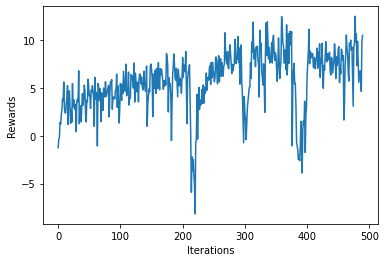

 49%|████████████████████████████████████▊                                      | 49103/100000 [28:57<46:33, 18.22it/s]

Updated Weights
Mean Reward = 11.46
62


 49%|████████████████████████████████████▉                                      | 49206/100000 [29:01<27:35, 30.69it/s]

Updated Weights
Mean Reward = 7.96
61


 49%|████████████████████████████████████▉                                      | 49303/100000 [29:05<38:57, 21.69it/s]

Updated Weights
Mean Reward = 10.59
60


 49%|█████████████████████████████████████                                      | 49404/100000 [29:09<34:40, 24.32it/s]

Updated Weights
Mean Reward = 9.3
53


 49%|█████████████████████████████████████                                      | 49499/100000 [29:13<35:41, 23.58it/s]

Updated Weights
Mean Reward = 10.93
60


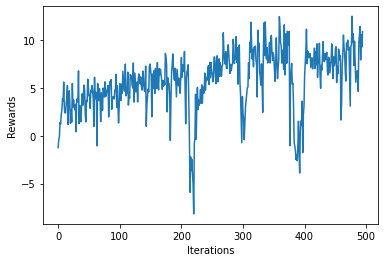

 50%|█████████████████████████████████████▏                                     | 49603/100000 [29:17<39:25, 21.31it/s]

Updated Weights
Mean Reward = 5.95
44


 50%|█████████████████████████████████████▎                                     | 49707/100000 [29:21<28:22, 29.54it/s]

Updated Weights
Mean Reward = 9.2
57


 50%|█████████████████████████████████████▎                                     | 49805/100000 [29:25<34:26, 24.29it/s]

Updated Weights
Mean Reward = 9.13
57


 50%|█████████████████████████████████████▍                                     | 49902/100000 [29:29<33:04, 25.25it/s]

Updated Weights
Mean Reward = 6.61
44


 50%|█████████████████████████████████████▌                                     | 50000/100000 [29:34<45:38, 18.26it/s]

Updated Weights
Mean Reward = 2.26
12


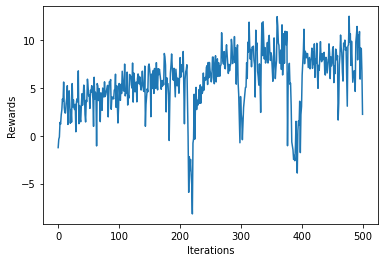

 50%|█████████████████████████████████████▌                                     | 50105/100000 [29:40<38:53, 21.39it/s]

Updated Weights
Mean Reward = 7.02
36


 50%|█████████████████████████████████████▋                                     | 50202/100000 [29:44<36:42, 22.61it/s]

Updated Weights
Mean Reward = 11.15
54


 50%|█████████████████████████████████████▋                                     | 50305/100000 [29:49<33:42, 24.57it/s]

Updated Weights
Mean Reward = 6.92
47


 50%|█████████████████████████████████████▊                                     | 50402/100000 [29:53<37:37, 21.97it/s]

Updated Weights
Mean Reward = 10.56
57


 50%|█████████████████████████████████████▊                                     | 50499/100000 [29:58<38:30, 21.42it/s]

Updated Weights
Mean Reward = 9.08
49


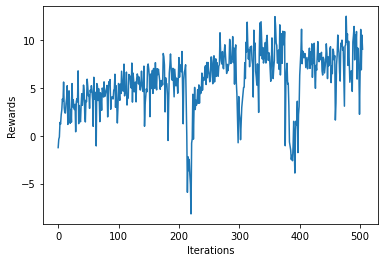

 51%|█████████████████████████████████████▉                                     | 50604/100000 [30:03<35:54, 22.92it/s]

Updated Weights
Mean Reward = 10.18
45


 51%|██████████████████████████████████████                                     | 50703/100000 [30:07<37:16, 22.04it/s]

Updated Weights
Mean Reward = 8.76
44


 51%|██████████████████████████████████████                                     | 50805/100000 [30:11<34:10, 24.00it/s]

Updated Weights
Mean Reward = 10.1
69


 51%|██████████████████████████████████████▏                                    | 50905/100000 [30:15<30:31, 26.81it/s]

Updated Weights
Mean Reward = 9.67
54


 51%|██████████████████████████████████████▏                                    | 50998/100000 [30:18<32:02, 25.48it/s]

Updated Weights
Mean Reward = 9.79
55


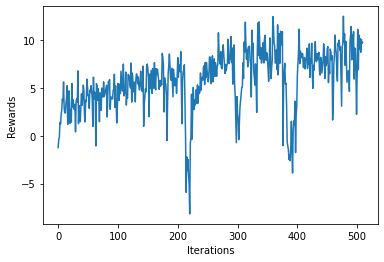

 51%|██████████████████████████████████████▎                                    | 51104/100000 [30:23<31:40, 25.72it/s]

Updated Weights
Mean Reward = 8.77
53


 51%|██████████████████████████████████████▍                                    | 51203/100000 [30:27<36:44, 22.13it/s]

Updated Weights
Mean Reward = 6.27
48


 51%|██████████████████████████████████████▍                                    | 51304/100000 [30:32<39:33, 20.52it/s]

Updated Weights
Mean Reward = 6.68
32


 51%|██████████████████████████████████████▌                                    | 51404/100000 [30:36<39:19, 20.60it/s]

Updated Weights
Mean Reward = 9.77
49


 51%|██████████████████████████████████████▌                                    | 51498/100000 [30:41<38:52, 20.80it/s]

Updated Weights
Mean Reward = 6.98
40


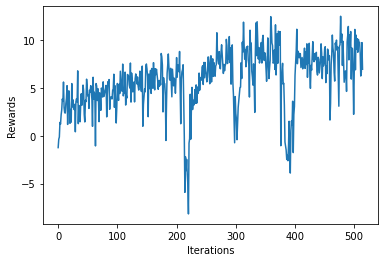

 52%|██████████████████████████████████████▋                                    | 51603/100000 [30:45<29:53, 26.98it/s]

Updated Weights
Mean Reward = 11.83
56


 52%|██████████████████████████████████████▊                                    | 51703/100000 [30:49<36:20, 22.15it/s]

Updated Weights
Mean Reward = 10.12
48


 52%|██████████████████████████████████████▊                                    | 51805/100000 [30:54<27:43, 28.97it/s]

Updated Weights
Mean Reward = 8.86
45


 52%|██████████████████████████████████████▉                                    | 51902/100000 [30:58<38:29, 20.82it/s]

Updated Weights
Mean Reward = 11.01
58


 52%|██████████████████████████████████████▉                                    | 51997/100000 [31:02<38:29, 20.79it/s]

Updated Weights
Mean Reward = 6.13
43


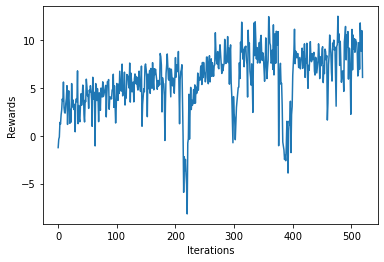

 52%|███████████████████████████████████████                                    | 52103/100000 [31:07<40:11, 19.86it/s]

Updated Weights
Mean Reward = 10.05
48


 52%|███████████████████████████████████████▏                                   | 52204/100000 [31:11<35:51, 22.21it/s]

Updated Weights
Mean Reward = 8.41
44


 52%|███████████████████████████████████████▏                                   | 52305/100000 [31:15<31:48, 24.99it/s]

Updated Weights
Mean Reward = 11.81
61


 52%|███████████████████████████████████████▎                                   | 52402/100000 [31:21<38:13, 20.76it/s]

Updated Weights
Mean Reward = 5.96
34


 52%|███████████████████████████████████████▎                                   | 52498/100000 [31:26<47:59, 16.50it/s]

Updated Weights
Mean Reward = 6.55
35


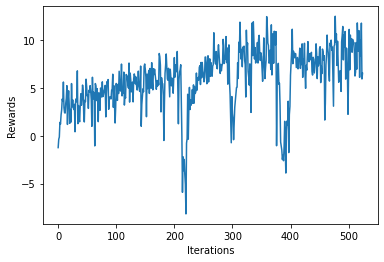

 53%|███████████████████████████████████████▍                                   | 52604/100000 [31:31<35:34, 22.21it/s]

Updated Weights
Mean Reward = 5.91
33


 53%|███████████████████████████████████████▌                                   | 52704/100000 [31:36<34:09, 23.07it/s]

Updated Weights
Mean Reward = 5.45
38


 53%|███████████████████████████████████████▌                                   | 52804/100000 [31:41<40:44, 19.31it/s]

Updated Weights
Mean Reward = 6.77
27


 53%|███████████████████████████████████████▋                                   | 52903/100000 [31:45<31:38, 24.81it/s]

Updated Weights
Mean Reward = 9.26
45


 53%|███████████████████████████████████████▊                                   | 53000/100000 [31:49<33:12, 23.59it/s]

Updated Weights
Mean Reward = 9.82
41


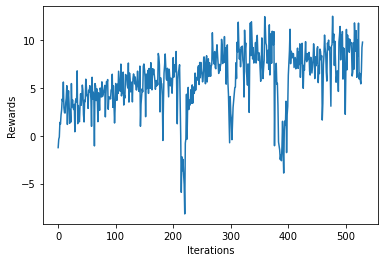

 53%|███████████████████████████████████████▊                                   | 53102/100000 [31:54<39:00, 20.04it/s]

Updated Weights
Mean Reward = 8.12
35


 53%|███████████████████████████████████████▉                                   | 53205/100000 [31:59<36:26, 21.40it/s]

Updated Weights
Mean Reward = 7.24
35


 53%|███████████████████████████████████████▉                                   | 53303/100000 [32:03<40:11, 19.37it/s]

Updated Weights
Mean Reward = 8.38
42


 53%|████████████████████████████████████████                                   | 53404/100000 [32:08<42:04, 18.45it/s]

Updated Weights
Mean Reward = 7.43
31


 54%|████████████████████████████████████████▏                                  | 53500/100000 [32:13<35:05, 22.09it/s]

Updated Weights
Mean Reward = 6.71
38


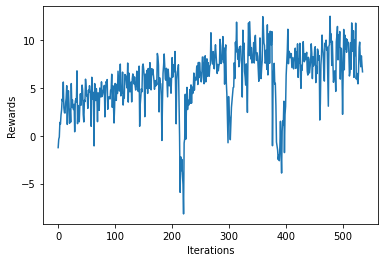

 54%|████████████████████████████████████████▏                                  | 53603/100000 [32:18<40:07, 19.27it/s]

Updated Weights
Mean Reward = 3.27
30


 54%|████████████████████████████████████████▎                                  | 53703/100000 [32:24<46:21, 16.64it/s]

Updated Weights
Mean Reward = 2.01
13


 54%|████████████████████████████████████████▎                                  | 53802/100000 [32:29<43:24, 17.74it/s]

Updated Weights
Mean Reward = 2.69
25


 54%|████████████████████████████████████████▍                                  | 53904/100000 [32:35<34:49, 22.07it/s]

Updated Weights
Mean Reward = 4.89
22


 54%|████████████████████████████████████████▌                                  | 54000/100000 [32:40<42:35, 18.00it/s]

Updated Weights
Mean Reward = 3.85
21


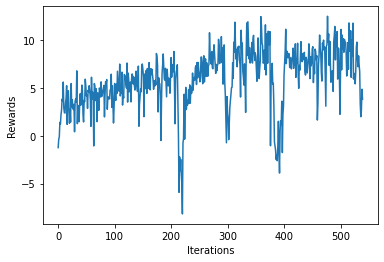

 54%|████████████████████████████████████████▌                                  | 54104/100000 [32:45<32:56, 23.23it/s]

Updated Weights
Mean Reward = 4.02
32


 54%|████████████████████████████████████████▋                                  | 54203/100000 [32:50<38:37, 19.76it/s]

Updated Weights
Mean Reward = 5.47
24


 54%|████████████████████████████████████████▋                                  | 54304/100000 [32:55<37:11, 20.47it/s]

Updated Weights
Mean Reward = 6.5
29


 54%|████████████████████████████████████████▊                                  | 54403/100000 [33:00<37:36, 20.20it/s]

Updated Weights
Mean Reward = 6.88
25


 55%|████████████████████████████████████████▉                                  | 54500/100000 [33:04<40:54, 18.54it/s]

Updated Weights
Mean Reward = 6.87
31


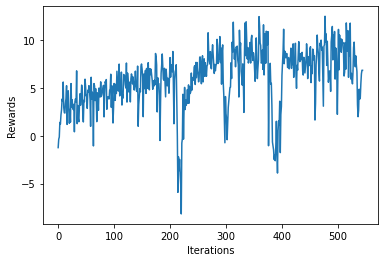

 55%|████████████████████████████████████████▉                                  | 54603/100000 [33:09<39:26, 19.18it/s]

Updated Weights
Mean Reward = 7.16
33


 55%|█████████████████████████████████████████                                  | 54705/100000 [33:14<31:00, 24.35it/s]

Updated Weights
Mean Reward = 10.1
43


 55%|█████████████████████████████████████████                                  | 54805/100000 [33:18<29:49, 25.26it/s]

Updated Weights
Mean Reward = 9.11
38


 55%|█████████████████████████████████████████▏                                 | 54903/100000 [33:23<41:19, 18.19it/s]

Updated Weights
Mean Reward = 7.58
38


 55%|█████████████████████████████████████████▎                                 | 55000/100000 [33:27<29:48, 25.15it/s]

Updated Weights
Mean Reward = 8.88
40


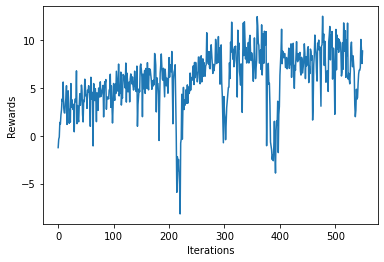

 55%|█████████████████████████████████████████▎                                 | 55104/100000 [33:31<31:00, 24.13it/s]

Updated Weights
Mean Reward = 9.99
46


 55%|█████████████████████████████████████████▍                                 | 55203/100000 [33:36<41:20, 18.06it/s]

Updated Weights
Mean Reward = 5.94
34


 55%|█████████████████████████████████████████▍                                 | 55305/100000 [33:41<33:35, 22.18it/s]

Updated Weights
Mean Reward = 4.16
24


 55%|█████████████████████████████████████████▌                                 | 55405/100000 [33:45<28:16, 26.29it/s]

Updated Weights
Mean Reward = 9.6
43


 55%|█████████████████████████████████████████▌                                 | 55497/100000 [33:50<34:56, 21.23it/s]

Updated Weights
Mean Reward = 5.69
33


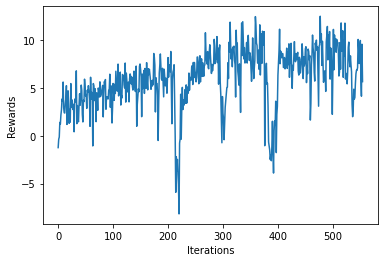

 56%|█████████████████████████████████████████▋                                 | 55604/100000 [33:55<32:34, 22.71it/s]

Updated Weights
Mean Reward = 8.66
40


 56%|█████████████████████████████████████████▊                                 | 55704/100000 [33:59<35:52, 20.58it/s]

Updated Weights
Mean Reward = 7.76
36


 56%|█████████████████████████████████████████▊                                 | 55805/100000 [34:04<30:41, 24.00it/s]

Updated Weights
Mean Reward = 8.31
35


 56%|█████████████████████████████████████████▉                                 | 55905/100000 [34:08<30:13, 24.31it/s]

Updated Weights
Mean Reward = 11.72
56


 56%|█████████████████████████████████████████▉                                 | 55998/100000 [34:12<38:27, 19.07it/s]

Updated Weights
Mean Reward = 11.94
57


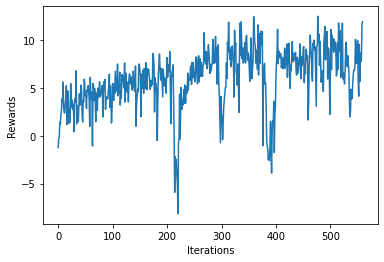

 56%|██████████████████████████████████████████                                 | 56104/100000 [34:18<36:15, 20.18it/s]

Updated Weights
Mean Reward = 10.11
46


 56%|██████████████████████████████████████████▏                                | 56204/100000 [34:23<38:45, 18.83it/s]

Updated Weights
Mean Reward = 4.99
27


 56%|██████████████████████████████████████████▏                                | 56302/100000 [34:28<39:35, 18.39it/s]

Updated Weights
Mean Reward = 6.11
35


 56%|██████████████████████████████████████████▎                                | 56403/100000 [34:34<44:52, 16.19it/s]

Updated Weights
Mean Reward = 3.97
14


 56%|██████████████████████████████████████████▎                                | 56499/100000 [34:39<34:25, 21.06it/s]

Updated Weights
Mean Reward = 6.68
31


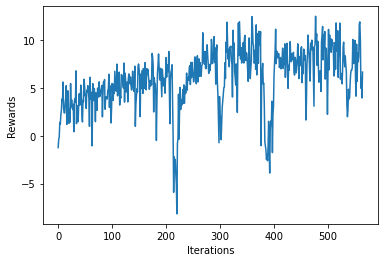

 57%|██████████████████████████████████████████▍                                | 56605/100000 [34:43<24:56, 29.00it/s]

Updated Weights
Mean Reward = 11.05
57


 57%|██████████████████████████████████████████▌                                | 56703/100000 [34:48<41:51, 17.24it/s]

Updated Weights
Mean Reward = 5.07
28


 57%|██████████████████████████████████████████▌                                | 56802/100000 [34:52<31:34, 22.80it/s]

Updated Weights
Mean Reward = 8.66
35


 57%|██████████████████████████████████████████▋                                | 56905/100000 [34:57<27:05, 26.52it/s]

Updated Weights
Mean Reward = 9.53
43


 57%|██████████████████████████████████████████▋                                | 56998/100000 [35:01<34:38, 20.68it/s]

Updated Weights
Mean Reward = 8.46
44


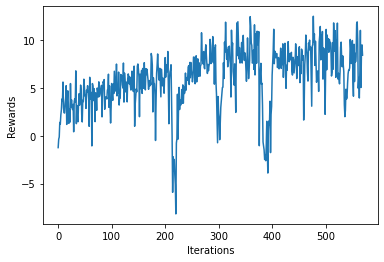

 57%|██████████████████████████████████████████▊                                | 57104/100000 [35:06<29:56, 23.87it/s]

Updated Weights
Mean Reward = 10.9
48


 57%|██████████████████████████████████████████▉                                | 57205/100000 [35:09<27:10, 26.25it/s]

Updated Weights
Mean Reward = 11.83
59


 57%|██████████████████████████████████████████▉                                | 57304/100000 [35:14<28:28, 24.99it/s]

Updated Weights
Mean Reward = 9.14
43


 57%|███████████████████████████████████████████                                | 57403/100000 [35:18<30:49, 23.03it/s]

Updated Weights
Mean Reward = 11.28
59


 57%|███████████████████████████████████████████▏                               | 57500/100000 [35:22<38:09, 18.57it/s]

Updated Weights
Mean Reward = 8.33
46


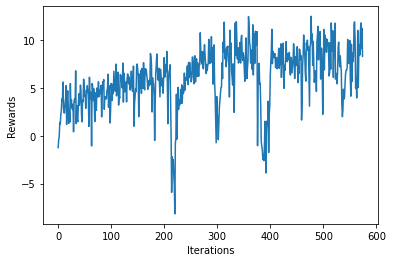

 58%|███████████████████████████████████████████▏                               | 57603/100000 [35:27<35:52, 19.70it/s]

Updated Weights
Mean Reward = 8.49
35


 58%|███████████████████████████████████████████▎                               | 57706/100000 [35:31<29:50, 23.62it/s]

Updated Weights
Mean Reward = 8.51
36


 58%|███████████████████████████████████████████▎                               | 57804/100000 [35:36<39:48, 17.67it/s]

Updated Weights
Mean Reward = 8.14
33


 58%|███████████████████████████████████████████▍                               | 57904/100000 [35:41<36:15, 19.35it/s]

Updated Weights
Mean Reward = 8.29
34


 58%|███████████████████████████████████████████▌                               | 58000/100000 [35:45<34:59, 20.00it/s]

Updated Weights
Mean Reward = 7.94
40


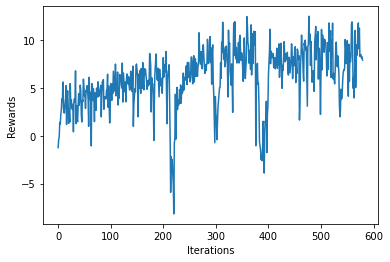

 58%|███████████████████████████████████████████▌                               | 58105/100000 [35:50<32:18, 21.61it/s]

Updated Weights
Mean Reward = 8.29
30


 58%|███████████████████████████████████████████▋                               | 58202/100000 [35:54<33:35, 20.74it/s]

Updated Weights
Mean Reward = 9.21
40


 58%|███████████████████████████████████████████▋                               | 58305/100000 [35:59<30:33, 22.75it/s]

Updated Weights
Mean Reward = 9.69
44


 58%|███████████████████████████████████████████▊                               | 58406/100000 [36:03<27:05, 25.59it/s]

Updated Weights
Mean Reward = 11.01
56


 58%|███████████████████████████████████████████▊                               | 58498/100000 [36:06<29:09, 23.72it/s]

Updated Weights
Mean Reward = 11.66
61


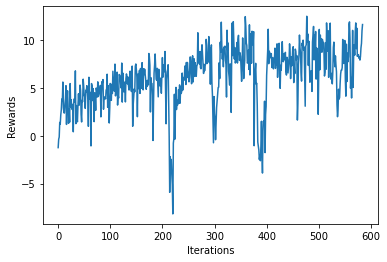

 59%|███████████████████████████████████████████▉                               | 58603/100000 [36:11<39:57, 17.27it/s]

Updated Weights
Mean Reward = 8.77
38


 59%|████████████████████████████████████████████                               | 58704/100000 [36:16<31:06, 22.13it/s]

Updated Weights
Mean Reward = 9.24
45


 59%|████████████████████████████████████████████                               | 58805/100000 [36:19<21:28, 31.96it/s]

Updated Weights
Mean Reward = 9.49
55


 59%|████████████████████████████████████████████▏                              | 58904/100000 [36:23<29:15, 23.41it/s]

Updated Weights
Mean Reward = 9.22
50


 59%|████████████████████████████████████████████▏                              | 58999/100000 [36:27<30:00, 22.77it/s]

Updated Weights
Mean Reward = 5.52
47


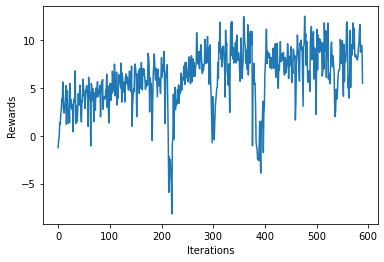

 59%|████████████████████████████████████████████▎                              | 59103/100000 [36:33<40:05, 17.00it/s]

Updated Weights
Mean Reward = 5.7
16


 59%|████████████████████████████████████████████▍                              | 59204/100000 [36:39<36:35, 18.58it/s]

Updated Weights
Mean Reward = 6.08
17


 59%|████████████████████████████████████████████▍                              | 59304/100000 [36:43<27:33, 24.61it/s]

Updated Weights
Mean Reward = 8.99
37


 59%|████████████████████████████████████████████▌                              | 59404/100000 [36:48<28:16, 23.93it/s]

Updated Weights
Mean Reward = 8.15
30


 60%|████████████████████████████████████████████▋                              | 59500/100000 [36:52<26:11, 25.77it/s]

Updated Weights
Mean Reward = 9.18
38


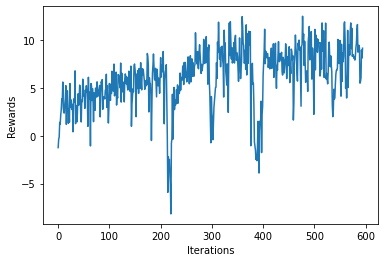

 60%|████████████████████████████████████████████▋                              | 59604/100000 [36:57<35:43, 18.84it/s]

Updated Weights
Mean Reward = 8.16
28


 60%|████████████████████████████████████████████▊                              | 59701/100000 [37:02<33:31, 20.04it/s]

Updated Weights
Mean Reward = 8.54
33


 60%|████████████████████████████████████████████▊                              | 59805/100000 [37:07<28:59, 23.11it/s]

Updated Weights
Mean Reward = 6.37
30


 60%|████████████████████████████████████████████▉                              | 59903/100000 [37:12<30:42, 21.77it/s]

Updated Weights
Mean Reward = 6.77
24


 60%|████████████████████████████████████████████▉                              | 59999/100000 [37:16<29:46, 22.39it/s]

Updated Weights
Mean Reward = 7.82
35


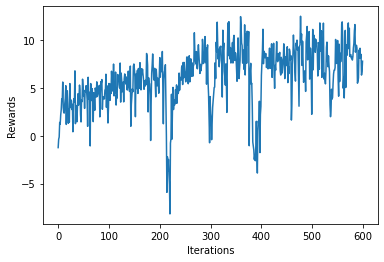

 60%|█████████████████████████████████████████████                              | 60104/100000 [37:21<35:57, 18.49it/s]

Updated Weights
Mean Reward = 7.88
35


 60%|█████████████████████████████████████████████▏                             | 60204/100000 [37:26<32:26, 20.44it/s]

Updated Weights
Mean Reward = 6.93
25


 60%|█████████████████████████████████████████████▏                             | 60307/100000 [37:31<26:28, 24.99it/s]

Updated Weights
Mean Reward = 8.98
36


 60%|█████████████████████████████████████████████▎                             | 60403/100000 [37:35<25:53, 25.49it/s]

Updated Weights
Mean Reward = 9.96
48


 60%|█████████████████████████████████████████████▍                             | 60500/100000 [37:39<30:49, 21.36it/s]

Updated Weights
Mean Reward = 10.11
44


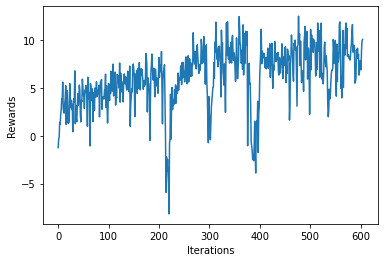

 61%|█████████████████████████████████████████████▍                             | 60604/100000 [37:43<32:37, 20.12it/s]

Updated Weights
Mean Reward = 8.41
42


 61%|█████████████████████████████████████████████▌                             | 60704/100000 [37:49<37:54, 17.28it/s]

Updated Weights
Mean Reward = 6.33
21


 61%|█████████████████████████████████████████████▌                             | 60805/100000 [37:54<31:24, 20.80it/s]

Updated Weights
Mean Reward = 7.05
24


 61%|█████████████████████████████████████████████▋                             | 60903/100000 [37:58<32:22, 20.13it/s]

Updated Weights
Mean Reward = 9.29
44


 61%|█████████████████████████████████████████████▋                             | 60999/100000 [38:02<32:07, 20.24it/s]

Updated Weights
Mean Reward = 8.59
36


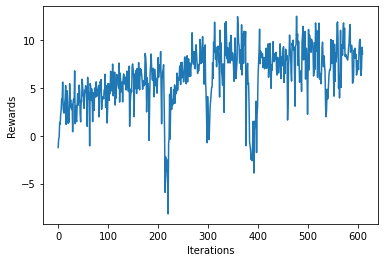

 61%|█████████████████████████████████████████████▊                             | 61103/100000 [38:07<30:18, 21.39it/s]

Updated Weights
Mean Reward = 9.14
36


 61%|█████████████████████████████████████████████▉                             | 61203/100000 [38:12<30:14, 21.39it/s]

Updated Weights
Mean Reward = 7.75
38


 61%|█████████████████████████████████████████████▉                             | 61305/100000 [38:17<32:19, 19.95it/s]

Updated Weights
Mean Reward = 6.32
24


 61%|██████████████████████████████████████████████                             | 61403/100000 [38:22<33:22, 19.28it/s]

Updated Weights
Mean Reward = 7.8
28


 62%|██████████████████████████████████████████████▏                            | 61500/100000 [38:26<32:16, 19.88it/s]

Updated Weights
Mean Reward = 8.62
36


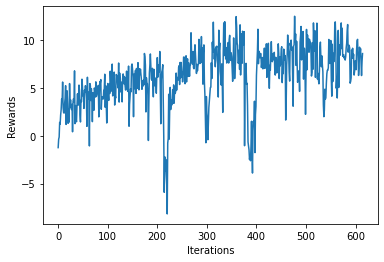

 62%|██████████████████████████████████████████████▏                            | 61607/100000 [38:31<24:27, 26.16it/s]

Updated Weights
Mean Reward = 7.92
31


 62%|██████████████████████████████████████████████▎                            | 61704/100000 [38:36<32:24, 19.69it/s]

Updated Weights
Mean Reward = 9.47
42


 62%|██████████████████████████████████████████████▎                            | 61801/100000 [38:40<27:53, 22.82it/s]

Updated Weights
Mean Reward = 9.09
39


 62%|██████████████████████████████████████████████▍                            | 61904/100000 [38:45<35:14, 18.02it/s]

Updated Weights
Mean Reward = 9.17
39


 62%|██████████████████████████████████████████████▌                            | 62000/100000 [38:50<26:00, 24.35it/s]

Updated Weights
Mean Reward = 9.34
34


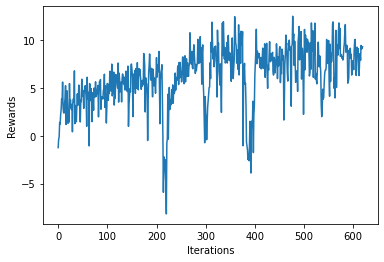

 62%|██████████████████████████████████████████████▌                            | 62104/100000 [38:55<27:30, 22.96it/s]

Updated Weights
Mean Reward = 9.58
43


 62%|██████████████████████████████████████████████▋                            | 62206/100000 [38:59<24:50, 25.36it/s]

Updated Weights
Mean Reward = 8.28
43


 62%|██████████████████████████████████████████████▋                            | 62304/100000 [39:03<29:49, 21.07it/s]

Updated Weights
Mean Reward = 9.19
40


 62%|██████████████████████████████████████████████▊                            | 62402/100000 [39:08<24:59, 25.08it/s]

Updated Weights
Mean Reward = 8.41
35


 62%|██████████████████████████████████████████████▊                            | 62499/100000 [39:13<34:49, 17.95it/s]

Updated Weights
Mean Reward = 5.94
24


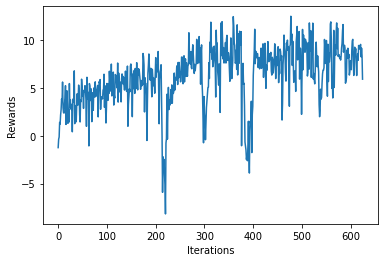

 63%|██████████████████████████████████████████████▉                            | 62602/100000 [39:18<26:25, 23.58it/s]

Updated Weights
Mean Reward = 8.47
31


 63%|███████████████████████████████████████████████                            | 62703/100000 [39:22<34:48, 17.86it/s]

Updated Weights
Mean Reward = 9.71
46


 63%|███████████████████████████████████████████████                            | 62803/100000 [39:27<26:53, 23.06it/s]

Updated Weights
Mean Reward = 6.82
22


 63%|███████████████████████████████████████████████▏                           | 62903/100000 [39:32<26:03, 23.72it/s]

Updated Weights
Mean Reward = 9.24
36


 63%|███████████████████████████████████████████████▏                           | 62998/100000 [39:36<27:49, 22.16it/s]

Updated Weights
Mean Reward = 9.62
43


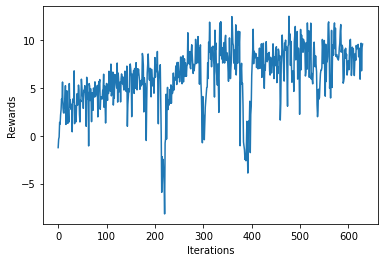

 63%|███████████████████████████████████████████████▎                           | 63102/100000 [39:42<30:23, 20.23it/s]

Updated Weights
Mean Reward = 6.89
19


 63%|███████████████████████████████████████████████▍                           | 63203/100000 [39:47<33:48, 18.14it/s]

Updated Weights
Mean Reward = 7.99
28


 63%|███████████████████████████████████████████████▍                           | 63304/100000 [39:52<34:36, 17.67it/s]

Updated Weights
Mean Reward = 7.94
29


 63%|███████████████████████████████████████████████▌                           | 63404/100000 [39:56<27:56, 21.83it/s]

Updated Weights
Mean Reward = 8.08
35


 63%|███████████████████████████████████████████████▌                           | 63499/100000 [40:01<27:36, 22.03it/s]

Updated Weights
Mean Reward = 7.92
35


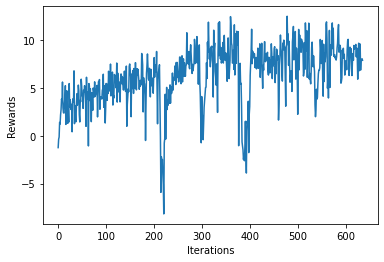

 64%|███████████████████████████████████████████████▋                           | 63602/100000 [40:07<36:07, 16.79it/s]

Updated Weights
Mean Reward = 6.64
18


 64%|███████████████████████████████████████████████▊                           | 63703/100000 [40:11<34:25, 17.57it/s]

Updated Weights
Mean Reward = 6.04
29


 64%|███████████████████████████████████████████████▊                           | 63804/100000 [40:17<31:39, 19.06it/s]

Updated Weights
Mean Reward = 2.07
24


 64%|███████████████████████████████████████████████▉                           | 63902/100000 [40:22<30:13, 19.91it/s]

Updated Weights
Mean Reward = 5.84
19


 64%|███████████████████████████████████████████████▉                           | 63999/100000 [40:26<29:03, 20.65it/s]

Updated Weights
Mean Reward = 7.11
32


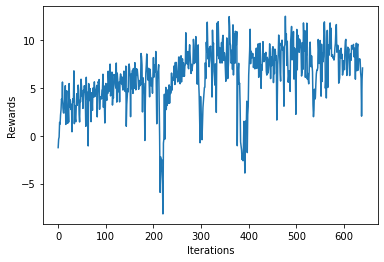

 64%|████████████████████████████████████████████████                           | 64103/100000 [40:32<27:59, 21.38it/s]

Updated Weights
Mean Reward = 8.39
31


 64%|████████████████████████████████████████████████▏                          | 64203/100000 [40:37<31:10, 19.14it/s]

Updated Weights
Mean Reward = 8.45
33


 64%|████████████████████████████████████████████████▏                          | 64304/100000 [40:43<41:11, 14.45it/s]

Updated Weights
Mean Reward = 8.68
36


 64%|████████████████████████████████████████████████▎                          | 64403/100000 [40:47<32:06, 18.48it/s]

Updated Weights
Mean Reward = 9.66
42


 64%|████████████████████████████████████████████████▎                          | 64497/100000 [40:51<22:40, 26.10it/s]

Updated Weights
Mean Reward = 11.15
53


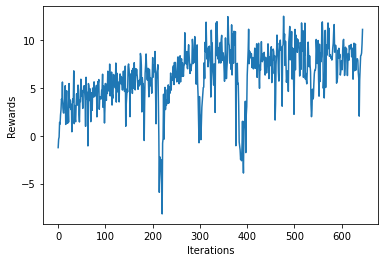

 65%|████████████████████████████████████████████████▍                          | 64603/100000 [40:56<32:09, 18.35it/s]

Updated Weights
Mean Reward = 9.28
47


 65%|████████████████████████████████████████████████▌                          | 64703/100000 [41:01<26:31, 22.18it/s]

Updated Weights
Mean Reward = 6.75
32


 65%|████████████████████████████████████████████████▌                          | 64803/100000 [41:06<34:30, 17.00it/s]

Updated Weights
Mean Reward = 8.49
34


 65%|████████████████████████████████████████████████▋                          | 64905/100000 [41:11<23:38, 24.74it/s]

Updated Weights
Mean Reward = 8.85
34


 65%|████████████████████████████████████████████████▊                          | 65000/100000 [41:15<26:27, 22.05it/s]

Updated Weights
Mean Reward = 9.44
42


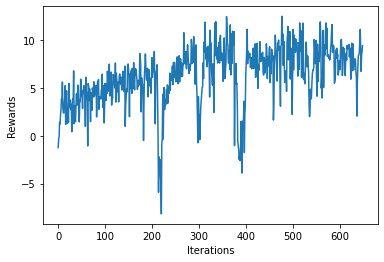

 65%|████████████████████████████████████████████████▊                          | 65104/100000 [41:21<28:45, 20.22it/s]

Updated Weights
Mean Reward = 8.02
42


 65%|████████████████████████████████████████████████▉                          | 65203/100000 [41:25<34:13, 16.94it/s]

Updated Weights
Mean Reward = 7.39
37


 65%|████████████████████████████████████████████████▉                          | 65302/100000 [41:31<34:59, 16.53it/s]

Updated Weights
Mean Reward = 5.09
29


 65%|█████████████████████████████████████████████████                          | 65403/100000 [41:36<28:51, 19.98it/s]

Updated Weights
Mean Reward = 9.27
41


 65%|█████████████████████████████████████████████████                          | 65499/100000 [41:40<27:17, 21.07it/s]

Updated Weights
Mean Reward = 6.71
43


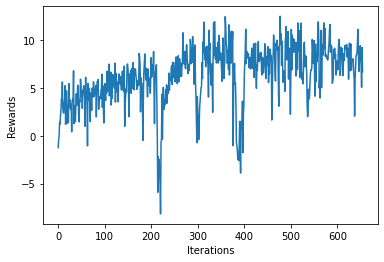

 66%|█████████████████████████████████████████████████▏                         | 65603/100000 [41:44<25:39, 22.35it/s]

Updated Weights
Mean Reward = 9.04
51


 66%|█████████████████████████████████████████████████▎                         | 65704/100000 [41:49<23:34, 24.24it/s]

Updated Weights
Mean Reward = 10.34
47


 66%|█████████████████████████████████████████████████▎                         | 65803/100000 [41:53<20:35, 27.69it/s]

Updated Weights
Mean Reward = 9.7
48


 66%|█████████████████████████████████████████████████▍                         | 65906/100000 [41:58<26:50, 21.16it/s]

Updated Weights
Mean Reward = 6.55
38


 66%|█████████████████████████████████████████████████▌                         | 66000/100000 [42:02<20:51, 27.17it/s]

Updated Weights
Mean Reward = 9.36
50


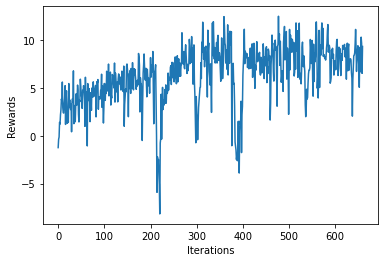

 66%|█████████████████████████████████████████████████▌                         | 66103/100000 [42:07<26:23, 21.41it/s]

Updated Weights
Mean Reward = 5.77
34


 66%|█████████████████████████████████████████████████▋                         | 66204/100000 [42:12<27:20, 20.60it/s]

Updated Weights
Mean Reward = 8.53
36


 66%|█████████████████████████████████████████████████▋                         | 66304/100000 [42:17<28:38, 19.61it/s]

Updated Weights
Mean Reward = 6.08
27


 66%|█████████████████████████████████████████████████▊                         | 66404/100000 [42:22<26:41, 20.98it/s]

Updated Weights
Mean Reward = 8.4
31


 66%|█████████████████████████████████████████████████▉                         | 66500/100000 [42:26<29:24, 18.99it/s]

Updated Weights
Mean Reward = 4.8
24


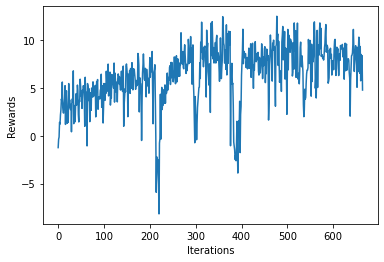

 67%|█████████████████████████████████████████████████▉                         | 66603/100000 [42:31<32:12, 17.28it/s]

Updated Weights
Mean Reward = 6.73
34


 67%|██████████████████████████████████████████████████                         | 66703/100000 [42:36<27:13, 20.38it/s]

Updated Weights
Mean Reward = 5.03
23


 67%|██████████████████████████████████████████████████                         | 66804/100000 [42:41<23:31, 23.53it/s]

Updated Weights
Mean Reward = 5.51
24


 67%|██████████████████████████████████████████████████▏                        | 66904/100000 [42:46<25:19, 21.78it/s]

Updated Weights
Mean Reward = 6.65
31


 67%|██████████████████████████████████████████████████▏                        | 66998/100000 [42:50<28:11, 19.51it/s]

Updated Weights
Mean Reward = 7.89
27


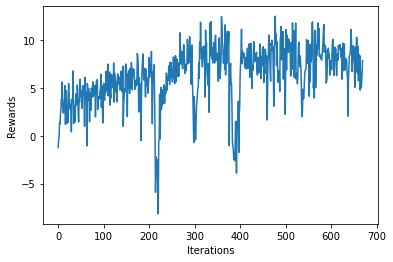

 67%|██████████████████████████████████████████████████▎                        | 67105/100000 [42:56<24:32, 22.34it/s]

Updated Weights
Mean Reward = 7.84
32


 67%|██████████████████████████████████████████████████▍                        | 67203/100000 [43:00<22:12, 24.62it/s]

Updated Weights
Mean Reward = 7.34
39


 67%|██████████████████████████████████████████████████▍                        | 67304/100000 [43:05<26:22, 20.66it/s]

Updated Weights
Mean Reward = 0.4
16


 67%|██████████████████████████████████████████████████▌                        | 67403/100000 [43:10<30:24, 17.87it/s]

Updated Weights
Mean Reward = 0.98
19


 67%|██████████████████████████████████████████████████▌                        | 67498/100000 [43:15<25:27, 21.28it/s]

Updated Weights
Mean Reward = 0.31
26


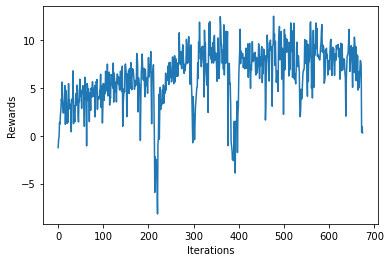

 68%|██████████████████████████████████████████████████▋                        | 67603/100000 [43:20<26:04, 20.71it/s]

Updated Weights
Mean Reward = 1.58
28


 68%|██████████████████████████████████████████████████▊                        | 67705/100000 [43:25<23:40, 22.73it/s]

Updated Weights
Mean Reward = 3.42
37


 68%|██████████████████████████████████████████████████▊                        | 67804/100000 [43:30<28:54, 18.56it/s]

Updated Weights
Mean Reward = 2.69
34


 68%|██████████████████████████████████████████████████▉                        | 67903/100000 [43:34<28:40, 18.66it/s]

Updated Weights
Mean Reward = 4.86
28


 68%|██████████████████████████████████████████████████▉                        | 67997/100000 [43:39<23:50, 22.37it/s]

Updated Weights
Mean Reward = 7.67
34


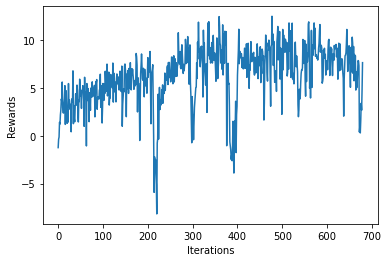

 68%|███████████████████████████████████████████████████                        | 68102/100000 [43:43<26:54, 19.76it/s]

Updated Weights
Mean Reward = 8.61
39


 68%|███████████████████████████████████████████████████▏                       | 68203/100000 [43:47<17:35, 30.12it/s]

Updated Weights
Mean Reward = 10.13
51


 68%|███████████████████████████████████████████████████▏                       | 68304/100000 [43:51<23:26, 22.53it/s]

Updated Weights
Mean Reward = 9.53
55


 68%|███████████████████████████████████████████████████▎                       | 68405/100000 [43:55<22:57, 22.94it/s]

Updated Weights
Mean Reward = 10.77
53


 68%|███████████████████████████████████████████████████▎                       | 68498/100000 [43:59<23:31, 22.32it/s]

Updated Weights
Mean Reward = 10.62
44


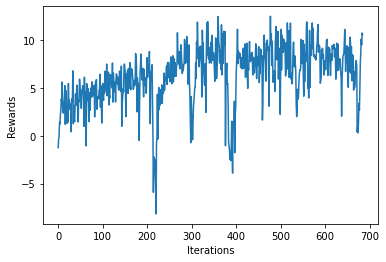

 69%|███████████████████████████████████████████████████▍                       | 68605/100000 [44:05<26:25, 19.80it/s]

Updated Weights
Mean Reward = 10.36
39


 69%|███████████████████████████████████████████████████▌                       | 68703/100000 [44:09<22:15, 23.43it/s]

Updated Weights
Mean Reward = 10.06
43


 69%|███████████████████████████████████████████████████▌                       | 68803/100000 [44:13<21:43, 23.93it/s]

Updated Weights
Mean Reward = 11.26
50


 69%|███████████████████████████████████████████████████▋                       | 68905/100000 [44:18<23:33, 22.00it/s]

Updated Weights
Mean Reward = 9.66
42


 69%|███████████████████████████████████████████████████▋                       | 68999/100000 [44:23<30:27, 16.96it/s]

Updated Weights
Mean Reward = 7.27
24


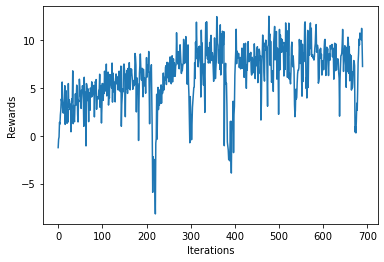

 69%|███████████████████████████████████████████████████▊                       | 69103/100000 [44:28<23:48, 21.64it/s]

Updated Weights
Mean Reward = 7.57
29


 69%|███████████████████████████████████████████████████▉                       | 69201/100000 [44:32<22:40, 22.63it/s]

Updated Weights
Mean Reward = 9.4
42


 69%|███████████████████████████████████████████████████▉                       | 69305/100000 [44:37<21:09, 24.18it/s]

Updated Weights
Mean Reward = 9.56
37


 69%|████████████████████████████████████████████████████                       | 69404/100000 [44:42<23:19, 21.86it/s]

Updated Weights
Mean Reward = 10.48
44


 69%|████████████████████████████████████████████████████                       | 69499/100000 [44:46<23:13, 21.90it/s]

Updated Weights
Mean Reward = 9.56
40


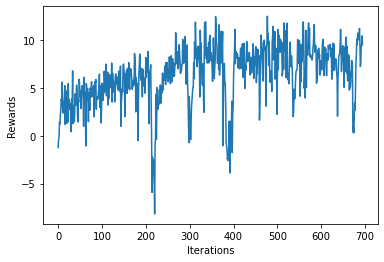

 70%|████████████████████████████████████████████████████▏                      | 69603/100000 [44:51<23:29, 21.56it/s]

Updated Weights
Mean Reward = 9.38
40


 70%|████████████████████████████████████████████████████▎                      | 69704/100000 [44:56<23:50, 21.18it/s]

Updated Weights
Mean Reward = 10.82
47


 70%|████████████████████████████████████████████████████▎                      | 69805/100000 [44:59<24:14, 20.76it/s]

Updated Weights
Mean Reward = 12.17
63


 70%|████████████████████████████████████████████████████▍                      | 69903/100000 [45:04<22:10, 22.62it/s]

Updated Weights
Mean Reward = 8.69
37


 70%|████████████████████████████████████████████████████▍                      | 69999/100000 [45:08<23:31, 21.25it/s]

Updated Weights
Mean Reward = 9.52
44


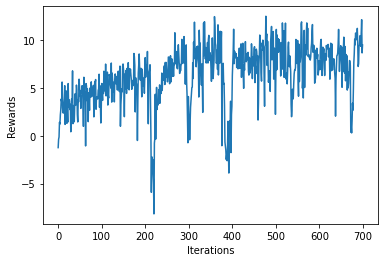

 70%|████████████████████████████████████████████████████▌                      | 70106/100000 [45:12<18:27, 26.99it/s]

Updated Weights
Mean Reward = 11.9
62


 70%|████████████████████████████████████████████████████▋                      | 70203/100000 [45:17<26:39, 18.63it/s]

Updated Weights
Mean Reward = 6.23
26


 70%|████████████████████████████████████████████████████▋                      | 70302/100000 [45:22<26:59, 18.34it/s]

Updated Weights
Mean Reward = 9.43
40


 70%|████████████████████████████████████████████████████▊                      | 70403/100000 [45:28<27:27, 17.97it/s]

Updated Weights
Mean Reward = 9.96
46


 70%|████████████████████████████████████████████████████▉                      | 70500/100000 [45:33<26:43, 18.40it/s]

Updated Weights
Mean Reward = 9.19
37


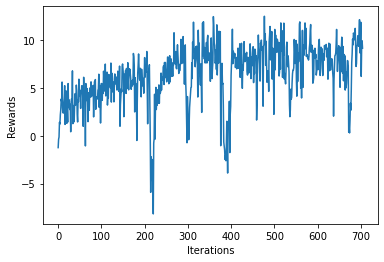

 71%|████████████████████████████████████████████████████▉                      | 70604/100000 [45:38<22:16, 22.00it/s]

Updated Weights
Mean Reward = 9.42
45


 71%|█████████████████████████████████████████████████████                      | 70704/100000 [45:43<17:32, 27.83it/s]

Updated Weights
Mean Reward = 10.35
51


 71%|█████████████████████████████████████████████████████                      | 70805/100000 [45:47<22:22, 21.75it/s]

Updated Weights
Mean Reward = 7.32
44


 71%|█████████████████████████████████████████████████████▏                     | 70904/100000 [45:52<21:54, 22.13it/s]

Updated Weights
Mean Reward = 2.24
22


 71%|█████████████████████████████████████████████████████▎                     | 71000/100000 [45:56<23:24, 20.65it/s]

Updated Weights
Mean Reward = 6.81
44


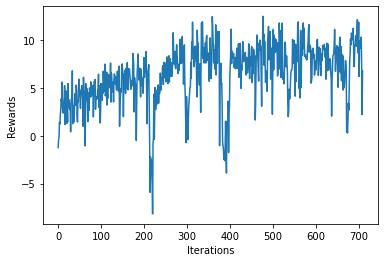

 71%|█████████████████████████████████████████████████████▎                     | 71104/100000 [46:01<24:12, 19.89it/s]

Updated Weights
Mean Reward = 7.33
37


 71%|█████████████████████████████████████████████████████▍                     | 71203/100000 [46:05<18:36, 25.80it/s]

Updated Weights
Mean Reward = 10.21
46


 71%|█████████████████████████████████████████████████████▍                     | 71302/100000 [46:09<16:33, 28.89it/s]

Updated Weights
Mean Reward = 11.47
62


 71%|█████████████████████████████████████████████████████▌                     | 71404/100000 [46:14<25:14, 18.88it/s]

Updated Weights
Mean Reward = 3.66
28


 72%|█████████████████████████████████████████████████████▋                     | 71500/100000 [46:19<24:15, 19.58it/s]

Updated Weights
Mean Reward = 6.02
17


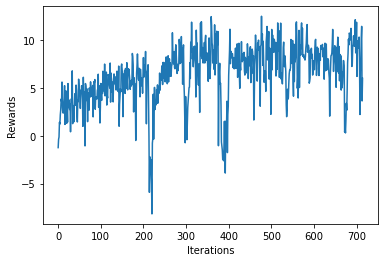

 72%|█████████████████████████████████████████████████████▋                     | 71604/100000 [46:25<20:25, 23.17it/s]

Updated Weights
Mean Reward = 8.51
30


 72%|█████████████████████████████████████████████████████▊                     | 71705/100000 [46:29<19:31, 24.14it/s]

Updated Weights
Mean Reward = 11.71
56


 72%|█████████████████████████████████████████████████████▊                     | 71806/100000 [46:33<15:22, 30.57it/s]

Updated Weights
Mean Reward = 10.83
51


 72%|█████████████████████████████████████████████████████▉                     | 71904/100000 [46:37<27:35, 16.98it/s]

Updated Weights
Mean Reward = 8.2
36


 72%|██████████████████████████████████████████████████████                     | 72000/100000 [46:42<21:55, 21.29it/s]

Updated Weights
Mean Reward = 7.24
42


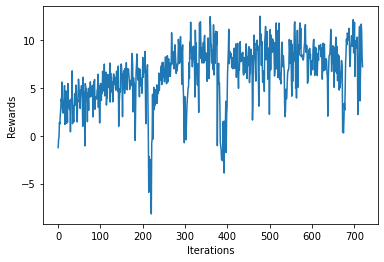

 72%|██████████████████████████████████████████████████████                     | 72102/100000 [46:47<23:15, 20.00it/s]

Updated Weights
Mean Reward = 9.32
37


 72%|██████████████████████████████████████████████████████▏                    | 72203/100000 [46:51<20:54, 22.15it/s]

Updated Weights
Mean Reward = 8.43
35


 72%|██████████████████████████████████████████████████████▏                    | 72303/100000 [46:56<18:36, 24.81it/s]

Updated Weights
Mean Reward = 9.64
47


 72%|██████████████████████████████████████████████████████▎                    | 72404/100000 [47:00<20:15, 22.71it/s]

Updated Weights
Mean Reward = 7.74
32


 72%|██████████████████████████████████████████████████████▎                    | 72498/100000 [47:05<22:47, 20.12it/s]

Updated Weights
Mean Reward = 6.28
33


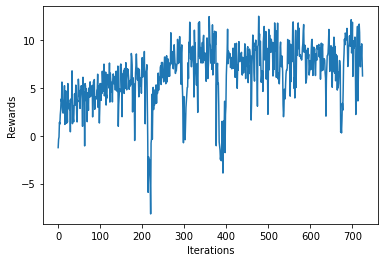

 73%|██████████████████████████████████████████████████████▍                    | 72603/100000 [47:10<24:03, 18.98it/s]

Updated Weights
Mean Reward = 4.19
26


 73%|██████████████████████████████████████████████████████▌                    | 72704/100000 [47:15<17:28, 26.03it/s]

Updated Weights
Mean Reward = 8.16
35


 73%|██████████████████████████████████████████████████████▌                    | 72803/100000 [47:19<18:41, 24.25it/s]

Updated Weights
Mean Reward = 11.47
51


 73%|██████████████████████████████████████████████████████▋                    | 72905/100000 [47:23<18:05, 24.96it/s]

Updated Weights
Mean Reward = 9.17
54


 73%|██████████████████████████████████████████████████████▋                    | 72998/100000 [47:27<22:59, 19.58it/s]

Updated Weights
Mean Reward = 10.26
49


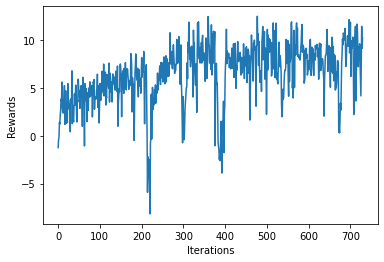

 73%|██████████████████████████████████████████████████████▊                    | 73104/100000 [47:32<19:30, 22.97it/s]

Updated Weights
Mean Reward = 8.57
40


 73%|██████████████████████████████████████████████████████▉                    | 73204/100000 [47:35<17:45, 25.14it/s]

Updated Weights
Mean Reward = 11.93
61


 73%|██████████████████████████████████████████████████████▉                    | 73306/100000 [47:40<20:23, 21.82it/s]

Updated Weights
Mean Reward = 10.04
48


 73%|███████████████████████████████████████████████████████                    | 73403/100000 [47:44<20:28, 21.64it/s]

Updated Weights
Mean Reward = 10.28
46


 73%|███████████████████████████████████████████████████████                    | 73498/100000 [47:48<21:29, 20.56it/s]

Updated Weights
Mean Reward = 8.97
44


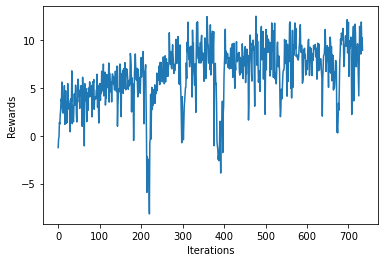

 74%|███████████████████████████████████████████████████████▏                   | 73603/100000 [47:53<22:16, 19.76it/s]

Updated Weights
Mean Reward = 9.17
41


 74%|███████████████████████████████████████████████████████▎                   | 73703/100000 [47:58<17:52, 24.52it/s]

Updated Weights
Mean Reward = 9.99
55


 74%|███████████████████████████████████████████████████████▎                   | 73803/100000 [48:02<19:05, 22.86it/s]

Updated Weights
Mean Reward = 9.26
47


 74%|███████████████████████████████████████████████████████▍                   | 73906/100000 [48:06<18:55, 22.99it/s]

Updated Weights
Mean Reward = 12.19
61


 74%|███████████████████████████████████████████████████████▌                   | 74000/100000 [48:10<17:31, 24.73it/s]

Updated Weights
Mean Reward = 11.75
57


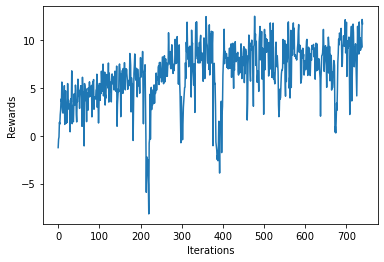

 74%|███████████████████████████████████████████████████████▌                   | 74104/100000 [48:14<19:26, 22.20it/s]

Updated Weights
Mean Reward = 9.72
54


 74%|███████████████████████████████████████████████████████▋                   | 74202/100000 [48:18<18:13, 23.59it/s]

Updated Weights
Mean Reward = 12.15
62


 74%|███████████████████████████████████████████████████████▋                   | 74306/100000 [48:22<17:42, 24.18it/s]

Updated Weights
Mean Reward = 8.83
43


 74%|███████████████████████████████████████████████████████▊                   | 74405/100000 [48:26<17:28, 24.40it/s]

Updated Weights
Mean Reward = 9.12
48


 74%|███████████████████████████████████████████████████████▊                   | 74499/100000 [48:30<18:03, 23.54it/s]

Updated Weights
Mean Reward = 10.02
47


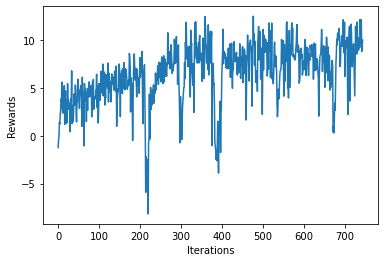

 75%|███████████████████████████████████████████████████████▉                   | 74603/100000 [48:35<21:37, 19.58it/s]

Updated Weights
Mean Reward = 6.93
42


 75%|████████████████████████████████████████████████████████                   | 74705/100000 [48:39<15:49, 26.64it/s]

Updated Weights
Mean Reward = 8.7
40


 75%|████████████████████████████████████████████████████████                   | 74804/100000 [48:43<17:37, 23.82it/s]

Updated Weights
Mean Reward = 11.65
60


 75%|████████████████████████████████████████████████████████▏                  | 74904/100000 [48:48<24:39, 16.97it/s]

Updated Weights
Mean Reward = 6.74
46


 75%|████████████████████████████████████████████████████████▏                  | 74997/100000 [48:51<19:45, 21.09it/s]

Updated Weights
Mean Reward = 8.65
43


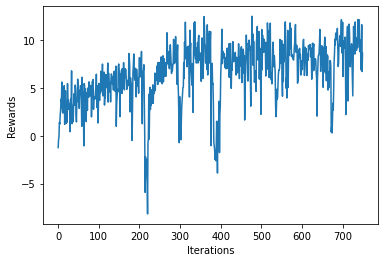

 75%|████████████████████████████████████████████████████████▎                  | 75106/100000 [48:56<15:44, 26.37it/s]

Updated Weights
Mean Reward = 9.85
46


 75%|████████████████████████████████████████████████████████▍                  | 75203/100000 [49:00<18:35, 22.23it/s]

Updated Weights
Mean Reward = 10.68
50


 75%|████████████████████████████████████████████████████████▍                  | 75303/100000 [49:05<16:46, 24.55it/s]

Updated Weights
Mean Reward = 8.63
43


 75%|████████████████████████████████████████████████████████▌                  | 75402/100000 [49:09<19:50, 20.65it/s]

Updated Weights
Mean Reward = 8.98
41


 75%|████████████████████████████████████████████████████████▌                  | 75499/100000 [49:14<22:41, 18.00it/s]

Updated Weights
Mean Reward = 4.0
23


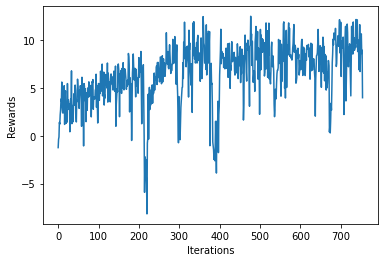

 76%|████████████████████████████████████████████████████████▋                  | 75603/100000 [49:19<19:50, 20.50it/s]

Updated Weights
Mean Reward = 5.51
26


 76%|████████████████████████████████████████████████████████▊                  | 75703/100000 [49:24<23:22, 17.33it/s]

Updated Weights
Mean Reward = 6.69
26


 76%|████████████████████████████████████████████████████████▊                  | 75805/100000 [49:29<19:29, 20.69it/s]

Updated Weights
Mean Reward = 5.52
31


 76%|████████████████████████████████████████████████████████▉                  | 75904/100000 [49:34<21:03, 19.08it/s]

Updated Weights
Mean Reward = 4.77
23


 76%|████████████████████████████████████████████████████████▉                  | 75998/100000 [49:38<18:10, 22.01it/s]

Updated Weights
Mean Reward = 4.23
34


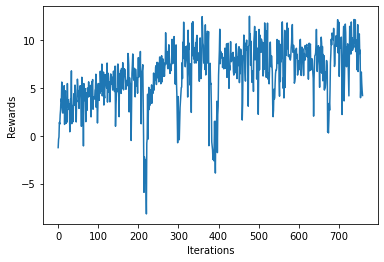

 76%|█████████████████████████████████████████████████████████                  | 76106/100000 [49:44<16:20, 24.37it/s]

Updated Weights
Mean Reward = 8.01
27


 76%|█████████████████████████████████████████████████████████▏                 | 76204/100000 [49:48<17:02, 23.26it/s]

Updated Weights
Mean Reward = 8.91
35


 76%|█████████████████████████████████████████████████████████▏                 | 76303/100000 [49:54<24:19, 16.24it/s]

Updated Weights
Mean Reward = 7.35
32


 76%|█████████████████████████████████████████████████████████▎                 | 76404/100000 [49:59<23:22, 16.82it/s]

Updated Weights
Mean Reward = 9.26
32


 76%|█████████████████████████████████████████████████████████▎                 | 76498/100000 [50:04<21:51, 17.91it/s]

Updated Weights
Mean Reward = 9.54
39


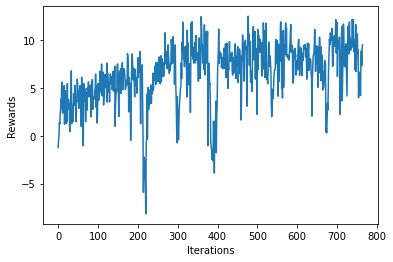

 77%|█████████████████████████████████████████████████████████▍                 | 76605/100000 [50:09<13:53, 28.07it/s]

Updated Weights
Mean Reward = 10.5
57


 77%|█████████████████████████████████████████████████████████▌                 | 76701/100000 [50:14<26:19, 14.75it/s]

Updated Weights
Mean Reward = 6.57
35


 77%|█████████████████████████████████████████████████████████▌                 | 76804/100000 [50:20<20:12, 19.14it/s]

Updated Weights
Mean Reward = 6.0
19


 77%|█████████████████████████████████████████████████████████▋                 | 76903/100000 [50:25<18:59, 20.28it/s]

Updated Weights
Mean Reward = 6.77
32


 77%|█████████████████████████████████████████████████████████▋                 | 76998/100000 [50:30<16:54, 22.66it/s]

Updated Weights
Mean Reward = 5.46
25


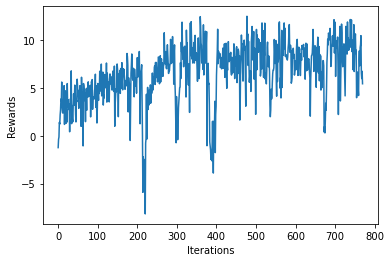

 77%|█████████████████████████████████████████████████████████▊                 | 77103/100000 [50:36<29:49, 12.79it/s]

Updated Weights
Mean Reward = 7.93
34


 77%|█████████████████████████████████████████████████████████▉                 | 77203/100000 [50:42<24:24, 15.57it/s]

Updated Weights
Mean Reward = 9.91
48


 77%|█████████████████████████████████████████████████████████▉                 | 77304/100000 [50:47<18:29, 20.46it/s]

Updated Weights
Mean Reward = 5.99
36


 77%|██████████████████████████████████████████████████████████                 | 77403/100000 [50:52<17:15, 21.83it/s]

Updated Weights
Mean Reward = 6.79
43


 78%|██████████████████████████████████████████████████████████▏                | 77500/100000 [50:57<22:06, 16.96it/s]

Updated Weights
Mean Reward = 6.95
24


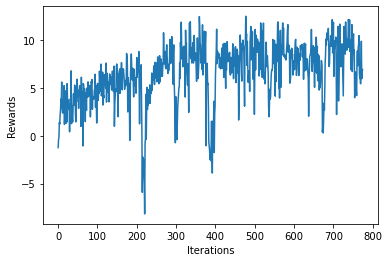

 78%|██████████████████████████████████████████████████████████▏                | 77605/100000 [51:03<19:25, 19.22it/s]

Updated Weights
Mean Reward = 9.38
37


 78%|██████████████████████████████████████████████████████████▎                | 77704/100000 [51:08<20:09, 18.44it/s]

Updated Weights
Mean Reward = 6.33
29


 78%|██████████████████████████████████████████████████████████▎                | 77805/100000 [51:13<16:42, 22.13it/s]

Updated Weights
Mean Reward = 7.46
28


 78%|██████████████████████████████████████████████████████████▍                | 77903/100000 [51:18<17:53, 20.58it/s]

Updated Weights
Mean Reward = 8.34
33


 78%|██████████████████████████████████████████████████████████▍                | 77998/100000 [51:21<16:59, 21.58it/s]

Updated Weights
Mean Reward = 9.85
43


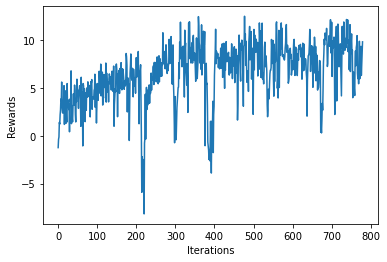

 78%|██████████████████████████████████████████████████████████▌                | 78105/100000 [51:26<14:31, 25.13it/s]

Updated Weights
Mean Reward = 8.82
43


 78%|██████████████████████████████████████████████████████████▋                | 78204/100000 [51:31<14:24, 25.22it/s]

Updated Weights
Mean Reward = 8.68
37


 78%|██████████████████████████████████████████████████████████▋                | 78303/100000 [51:35<18:23, 19.66it/s]

Updated Weights
Mean Reward = 8.12
31


 78%|██████████████████████████████████████████████████████████▊                | 78403/100000 [51:41<21:16, 16.93it/s]

Updated Weights
Mean Reward = 7.7
27


 78%|██████████████████████████████████████████████████████████▉                | 78500/100000 [51:45<17:52, 20.06it/s]

Updated Weights
Mean Reward = 7.93
46


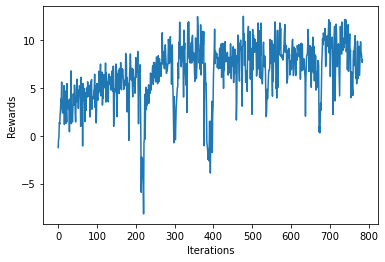

 79%|██████████████████████████████████████████████████████████▉                | 78604/100000 [51:50<14:03, 25.38it/s]

Updated Weights
Mean Reward = 6.63
42


 79%|███████████████████████████████████████████████████████████                | 78704/100000 [51:55<14:13, 24.94it/s]

Updated Weights
Mean Reward = 7.67
40


 79%|███████████████████████████████████████████████████████████                | 78803/100000 [52:00<16:24, 21.52it/s]

Updated Weights
Mean Reward = 7.23
32


 79%|███████████████████████████████████████████████████████████▏               | 78903/100000 [52:05<18:21, 19.14it/s]

Updated Weights
Mean Reward = 7.1
34


 79%|███████████████████████████████████████████████████████████▏               | 78998/100000 [52:09<16:07, 21.72it/s]

Updated Weights
Mean Reward = 9.16
48


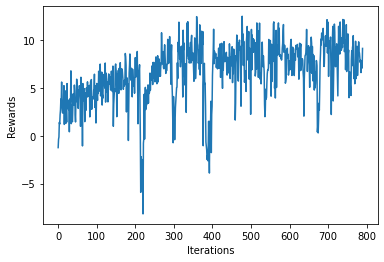

 79%|███████████████████████████████████████████████████████████▎               | 79102/100000 [52:13<16:01, 21.73it/s]

Updated Weights
Mean Reward = 9.7
45


 79%|███████████████████████████████████████████████████████████▍               | 79202/100000 [52:17<12:21, 28.03it/s]

Updated Weights
Mean Reward = 9.54
47


 79%|███████████████████████████████████████████████████████████▍               | 79306/100000 [52:21<15:29, 22.27it/s]

Updated Weights
Mean Reward = 11.11
57


 79%|███████████████████████████████████████████████████████████▌               | 79407/100000 [52:26<13:19, 25.77it/s]

Updated Weights
Mean Reward = 9.48
48


 79%|███████████████████████████████████████████████████████████▌               | 79498/100000 [52:30<15:12, 22.46it/s]

Updated Weights
Mean Reward = 7.3
42


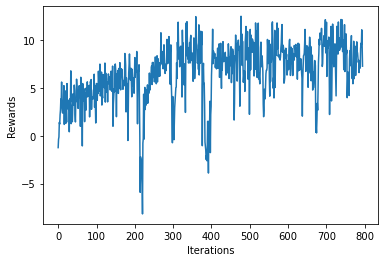

 80%|███████████████████████████████████████████████████████████▋               | 79600/100000 [52:35<16:03, 21.18it/s]

Updated Weights
Mean Reward = 7.62
32


 80%|███████████████████████████████████████████████████████████▊               | 79705/100000 [52:41<15:12, 22.23it/s]

Updated Weights
Mean Reward = 9.0
38


 80%|███████████████████████████████████████████████████████████▊               | 79804/100000 [52:45<11:53, 28.32it/s]

Updated Weights
Mean Reward = 9.86
43


 80%|███████████████████████████████████████████████████████████▉               | 79903/100000 [52:49<12:21, 27.10it/s]

Updated Weights
Mean Reward = 10.77
53


 80%|████████████████████████████████████████████████████████████               | 80000/100000 [52:53<15:27, 21.56it/s]

Updated Weights
Mean Reward = 10.24
50


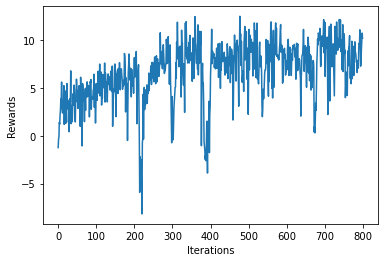

 80%|████████████████████████████████████████████████████████████               | 80103/100000 [52:58<18:15, 18.15it/s]

Updated Weights
Mean Reward = 6.01
44


 80%|████████████████████████████████████████████████████████████▏              | 80204/100000 [53:03<17:03, 19.34it/s]

Updated Weights
Mean Reward = 4.91
18


 80%|████████████████████████████████████████████████████████████▏              | 80303/100000 [53:09<17:47, 18.46it/s]

Updated Weights
Mean Reward = 4.78
8


 80%|████████████████████████████████████████████████████████████▎              | 80403/100000 [53:14<18:40, 17.49it/s]

Updated Weights
Mean Reward = 6.26
15


 80%|████████████████████████████████████████████████████████████▎              | 80498/100000 [53:19<13:35, 23.92it/s]

Updated Weights
Mean Reward = 7.74
34


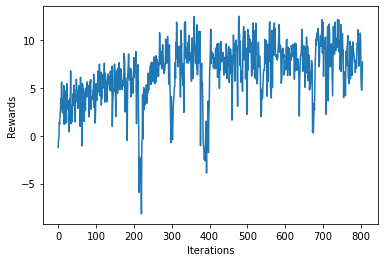

 81%|████████████████████████████████████████████████████████████▍              | 80602/100000 [53:24<19:54, 16.24it/s]

Updated Weights
Mean Reward = 6.51
32


 81%|████████████████████████████████████████████████████████████▌              | 80703/100000 [53:28<12:18, 26.12it/s]

Updated Weights
Mean Reward = 12.37
62


 81%|████████████████████████████████████████████████████████████▌              | 80802/100000 [53:33<17:12, 18.59it/s]

Updated Weights
Mean Reward = 7.07
35


 81%|████████████████████████████████████████████████████████████▋              | 80902/100000 [53:38<16:01, 19.87it/s]

Updated Weights
Mean Reward = 8.81
47


 81%|████████████████████████████████████████████████████████████▋              | 80997/100000 [53:42<11:30, 27.51it/s]

Updated Weights
Mean Reward = 11.5
59


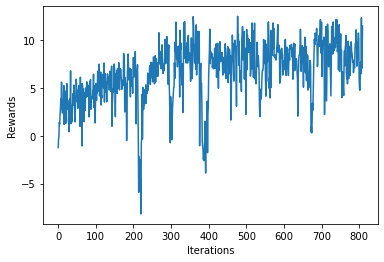

 81%|████████████████████████████████████████████████████████████▊              | 81103/100000 [53:48<17:30, 17.99it/s]

Updated Weights
Mean Reward = 2.66
31


 81%|████████████████████████████████████████████████████████████▉              | 81203/100000 [53:53<14:34, 21.49it/s]

Updated Weights
Mean Reward = 3.0
20


 81%|████████████████████████████████████████████████████████████▉              | 81304/100000 [53:58<15:10, 20.52it/s]

Updated Weights
Mean Reward = 5.59
17


 81%|█████████████████████████████████████████████████████████████              | 81403/100000 [54:03<13:41, 22.63it/s]

Updated Weights
Mean Reward = 9.14
38


 82%|█████████████████████████████████████████████████████████████              | 81500/100000 [54:08<18:01, 17.10it/s]

Updated Weights
Mean Reward = 6.94
27


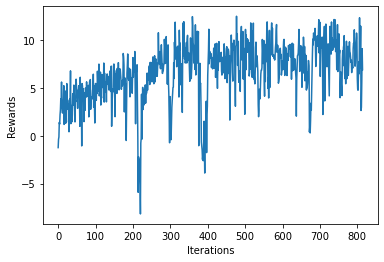

 82%|█████████████████████████████████████████████████████████████▏             | 81604/100000 [54:13<15:45, 19.46it/s]

Updated Weights
Mean Reward = 8.45
44


 82%|█████████████████████████████████████████████████████████████▎             | 81704/100000 [54:18<14:13, 21.45it/s]

Updated Weights
Mean Reward = 8.61
39


 82%|█████████████████████████████████████████████████████████████▎             | 81800/100000 [54:23<14:28, 20.96it/s]

Updated Weights
Mean Reward = 9.42
44


 82%|█████████████████████████████████████████████████████████████▍             | 81905/100000 [54:28<13:17, 22.69it/s]

Updated Weights
Mean Reward = 10.35
54


 82%|█████████████████████████████████████████████████████████████▍             | 82000/100000 [54:33<14:04, 21.31it/s]

Updated Weights
Mean Reward = 8.02
40


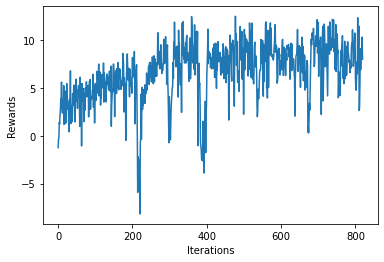

 82%|█████████████████████████████████████████████████████████████▌             | 82102/100000 [54:38<13:06, 22.75it/s]

Updated Weights
Mean Reward = 10.14
42


 82%|█████████████████████████████████████████████████████████████▋             | 82204/100000 [54:43<13:39, 21.71it/s]

Updated Weights
Mean Reward = 9.85
47


 82%|█████████████████████████████████████████████████████████████▋             | 82305/100000 [54:47<12:14, 24.10it/s]

Updated Weights
Mean Reward = 10.02
48


 82%|█████████████████████████████████████████████████████████████▊             | 82404/100000 [54:52<12:54, 22.72it/s]

Updated Weights
Mean Reward = 9.03
40


 82%|█████████████████████████████████████████████████████████████▉             | 82500/100000 [54:56<10:47, 27.04it/s]

Updated Weights
Mean Reward = 10.15
45


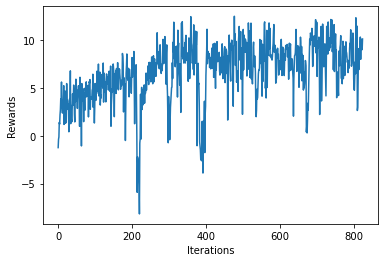

 83%|█████████████████████████████████████████████████████████████▉             | 82604/100000 [55:00<11:41, 24.79it/s]

Updated Weights
Mean Reward = 13.2
70


 83%|██████████████████████████████████████████████████████████████             | 82703/100000 [55:04<15:20, 18.80it/s]

Updated Weights
Mean Reward = 10.35
48


 83%|██████████████████████████████████████████████████████████████             | 82802/100000 [55:09<14:30, 19.75it/s]

Updated Weights
Mean Reward = 7.94
39


 83%|██████████████████████████████████████████████████████████████▏            | 82901/100000 [55:14<11:55, 23.90it/s]

Updated Weights
Mean Reward = 8.93
34


 83%|██████████████████████████████████████████████████████████████▏            | 82998/100000 [55:19<12:18, 23.03it/s]

Updated Weights
Mean Reward = 8.44
36


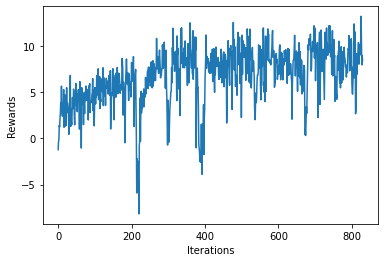

 83%|██████████████████████████████████████████████████████████████▎            | 83104/100000 [55:23<09:37, 29.27it/s]

Updated Weights
Mean Reward = 10.89
52


 83%|██████████████████████████████████████████████████████████████▍            | 83204/100000 [55:28<14:10, 19.74it/s]

Updated Weights
Mean Reward = 5.43
32


 83%|██████████████████████████████████████████████████████████████▍            | 83304/100000 [55:33<12:17, 22.65it/s]

Updated Weights
Mean Reward = 8.71
45


 83%|██████████████████████████████████████████████████████████████▌            | 83403/100000 [55:37<12:18, 22.48it/s]

Updated Weights
Mean Reward = 11.42
56


 84%|██████████████████████████████████████████████████████████████▋            | 83500/100000 [55:40<10:50, 25.35it/s]

Updated Weights
Mean Reward = 10.88
59


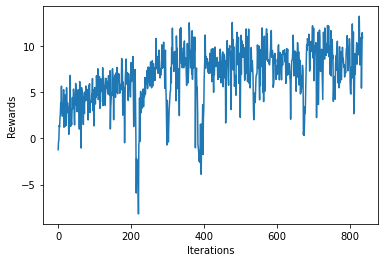

 84%|██████████████████████████████████████████████████████████████▋            | 83603/100000 [55:45<12:36, 21.68it/s]

Updated Weights
Mean Reward = 10.68
56


 84%|██████████████████████████████████████████████████████████████▊            | 83706/100000 [55:49<11:33, 23.50it/s]

Updated Weights
Mean Reward = 8.23
39


 84%|██████████████████████████████████████████████████████████████▊            | 83805/100000 [55:54<10:46, 25.05it/s]

Updated Weights
Mean Reward = 10.67
49


 84%|██████████████████████████████████████████████████████████████▉            | 83905/100000 [55:58<10:16, 26.11it/s]

Updated Weights
Mean Reward = 10.73
49


 84%|███████████████████████████████████████████████████████████████            | 84000/100000 [56:01<11:06, 23.99it/s]

Updated Weights
Mean Reward = 11.77
61


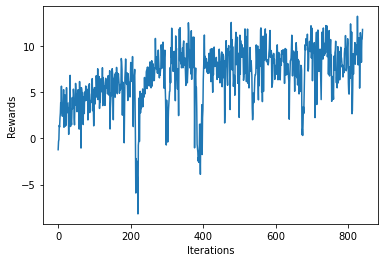

 84%|███████████████████████████████████████████████████████████████            | 84103/100000 [56:06<11:00, 24.07it/s]

Updated Weights
Mean Reward = 11.43
54


 84%|███████████████████████████████████████████████████████████████▏           | 84205/100000 [56:10<11:10, 23.56it/s]

Updated Weights
Mean Reward = 10.38
57


 84%|███████████████████████████████████████████████████████████████▏           | 84306/100000 [56:14<10:35, 24.70it/s]

Updated Weights
Mean Reward = 10.19
51


 84%|███████████████████████████████████████████████████████████████▎           | 84403/100000 [56:18<09:27, 27.49it/s]

Updated Weights
Mean Reward = 7.83
51


 84%|███████████████████████████████████████████████████████████████▎           | 84499/100000 [56:22<10:54, 23.69it/s]

Updated Weights
Mean Reward = 5.62
42


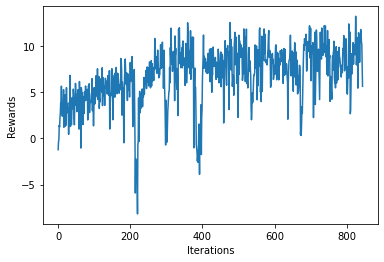

 85%|███████████████████████████████████████████████████████████████▍           | 84602/100000 [56:26<11:26, 22.42it/s]

Updated Weights
Mean Reward = 5.84
43


 85%|███████████████████████████████████████████████████████████████▌           | 84704/100000 [56:31<13:14, 19.25it/s]

Updated Weights
Mean Reward = 9.07
39


 85%|███████████████████████████████████████████████████████████████▌           | 84802/100000 [56:35<12:32, 20.20it/s]

Updated Weights
Mean Reward = 8.03
37


 85%|███████████████████████████████████████████████████████████████▋           | 84905/100000 [56:40<09:20, 26.95it/s]

Updated Weights
Mean Reward = 7.94
35


 85%|███████████████████████████████████████████████████████████████▊           | 85000/100000 [56:45<11:46, 21.24it/s]

Updated Weights
Mean Reward = 4.11
24


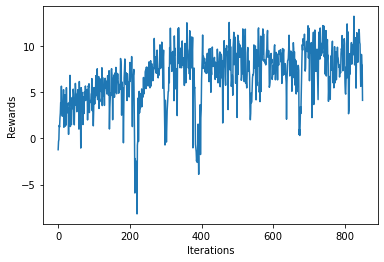

 85%|███████████████████████████████████████████████████████████████▊           | 85104/100000 [56:51<12:45, 19.47it/s]

Updated Weights
Mean Reward = 3.48
19


 85%|███████████████████████████████████████████████████████████████▉           | 85203/100000 [56:55<12:08, 20.31it/s]

Updated Weights
Mean Reward = 8.86
34


 85%|███████████████████████████████████████████████████████████████▉           | 85306/100000 [56:59<07:43, 31.70it/s]

Updated Weights
Mean Reward = 9.36
48


 85%|████████████████████████████████████████████████████████████████           | 85404/100000 [57:04<13:42, 17.75it/s]

Updated Weights
Mean Reward = 5.17
33


 86%|████████████████████████████████████████████████████████████████▏          | 85500/100000 [57:09<11:07, 21.72it/s]

Updated Weights
Mean Reward = 6.56
28


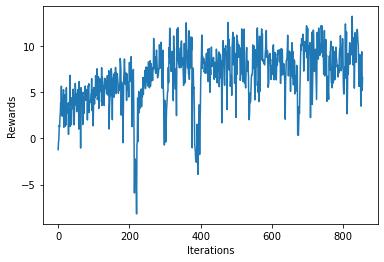

 86%|████████████████████████████████████████████████████████████████▏          | 85602/100000 [57:13<08:36, 27.85it/s]

Updated Weights
Mean Reward = 10.86
56


 86%|████████████████████████████████████████████████████████████████▎          | 85708/100000 [57:17<07:35, 31.35it/s]

Updated Weights
Mean Reward = 11.73
60


 86%|████████████████████████████████████████████████████████████████▎          | 85805/100000 [57:21<11:06, 21.29it/s]

Updated Weights
Mean Reward = 10.07
51


 86%|████████████████████████████████████████████████████████████████▍          | 85902/100000 [57:25<11:21, 20.68it/s]

Updated Weights
Mean Reward = 7.88
29


 86%|████████████████████████████████████████████████████████████████▌          | 86000/100000 [57:30<13:19, 17.52it/s]

Updated Weights
Mean Reward = 9.6
41


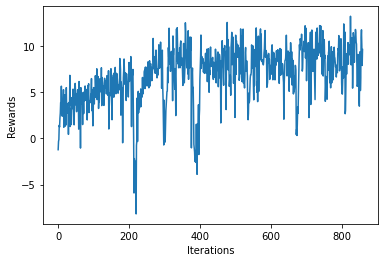

 86%|████████████████████████████████████████████████████████████████▌          | 86103/100000 [57:35<09:14, 25.06it/s]

Updated Weights
Mean Reward = 8.31
30


 86%|████████████████████████████████████████████████████████████████▋          | 86204/100000 [57:39<10:23, 22.14it/s]

Updated Weights
Mean Reward = 7.65
36


 86%|████████████████████████████████████████████████████████████████▋          | 86305/100000 [57:44<09:08, 24.97it/s]

Updated Weights
Mean Reward = 9.74
41


 86%|████████████████████████████████████████████████████████████████▊          | 86404/100000 [57:48<09:38, 23.51it/s]

Updated Weights
Mean Reward = 5.77
30


 86%|████████████████████████████████████████████████████████████████▉          | 86500/100000 [57:53<10:39, 21.11it/s]

Updated Weights
Mean Reward = 9.35
36


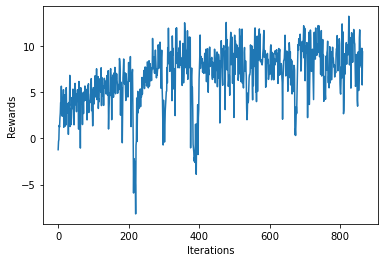

 87%|████████████████████████████████████████████████████████████████▉          | 86605/100000 [57:58<08:19, 26.84it/s]

Updated Weights
Mean Reward = 11.22
56


 87%|█████████████████████████████████████████████████████████████████          | 86704/100000 [58:01<09:43, 22.80it/s]

Updated Weights
Mean Reward = 12.47
61


 87%|█████████████████████████████████████████████████████████████████          | 86803/100000 [58:05<07:29, 29.36it/s]

Updated Weights
Mean Reward = 11.53
62


 87%|█████████████████████████████████████████████████████████████████▏         | 86903/100000 [58:09<09:25, 23.15it/s]

Updated Weights
Mean Reward = 10.91
56


 87%|█████████████████████████████████████████████████████████████████▎         | 87000/100000 [58:13<08:59, 24.09it/s]

Updated Weights
Mean Reward = 9.51
47


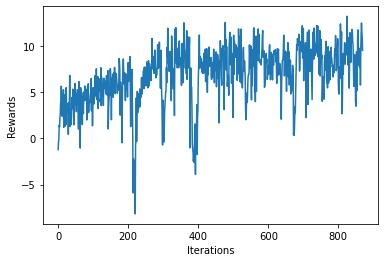

 87%|█████████████████████████████████████████████████████████████████▎         | 87103/100000 [58:17<09:22, 22.92it/s]

Updated Weights
Mean Reward = 12.44
67


 87%|█████████████████████████████████████████████████████████████████▍         | 87204/100000 [58:21<07:56, 26.84it/s]

Updated Weights
Mean Reward = 10.81
52


 87%|█████████████████████████████████████████████████████████████████▍         | 87301/100000 [58:25<08:48, 24.04it/s]

Updated Weights
Mean Reward = 9.06
40


 87%|█████████████████████████████████████████████████████████████████▌         | 87405/100000 [58:30<08:50, 23.74it/s]

Updated Weights
Mean Reward = 10.83
53


 87%|█████████████████████████████████████████████████████████████████▌         | 87499/100000 [58:33<08:15, 25.21it/s]

Updated Weights
Mean Reward = 10.81
52


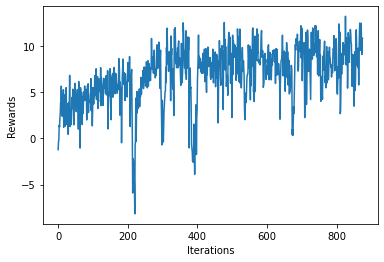

 88%|█████████████████████████████████████████████████████████████████▋         | 87604/100000 [58:39<11:01, 18.73it/s]

Updated Weights
Mean Reward = 4.29
27


 88%|█████████████████████████████████████████████████████████████████▊         | 87702/100000 [58:43<10:53, 18.82it/s]

Updated Weights
Mean Reward = 8.56
43


 88%|█████████████████████████████████████████████████████████████████▊         | 87805/100000 [58:47<07:07, 28.50it/s]

Updated Weights
Mean Reward = 9.78
44


 88%|█████████████████████████████████████████████████████████████████▉         | 87904/100000 [58:52<09:57, 20.23it/s]

Updated Weights
Mean Reward = 7.4
36


 88%|██████████████████████████████████████████████████████████████████         | 88000/100000 [58:56<07:31, 26.59it/s]

Updated Weights
Mean Reward = 11.88
60


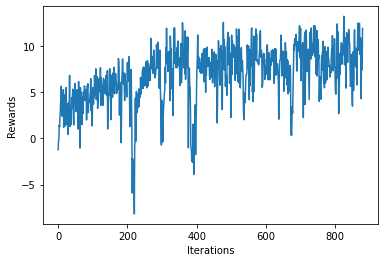

 88%|██████████████████████████████████████████████████████████████████         | 88105/100000 [59:00<05:45, 34.41it/s]

Updated Weights
Mean Reward = 11.88
59


 88%|██████████████████████████████████████████████████████████████████▏        | 88205/100000 [59:03<06:47, 28.96it/s]

Updated Weights
Mean Reward = 10.64
60


 88%|██████████████████████████████████████████████████████████████████▏        | 88305/100000 [59:07<06:48, 28.60it/s]

Updated Weights
Mean Reward = 9.86
50


 88%|██████████████████████████████████████████████████████████████████▎        | 88406/100000 [59:11<06:53, 28.03it/s]

Updated Weights
Mean Reward = 9.48
49


 88%|██████████████████████████████████████████████████████████████████▎        | 88499/100000 [59:15<10:31, 18.20it/s]

Updated Weights
Mean Reward = 6.78
40


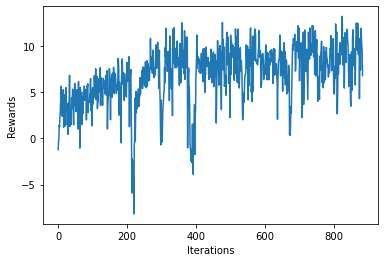

 89%|██████████████████████████████████████████████████████████████████▍        | 88603/100000 [59:21<10:58, 17.30it/s]

Updated Weights
Mean Reward = 4.55
18


 89%|██████████████████████████████████████████████████████████████████▌        | 88705/100000 [59:25<08:10, 23.02it/s]

Updated Weights
Mean Reward = 6.51
38


 89%|██████████████████████████████████████████████████████████████████▌        | 88804/100000 [59:30<07:41, 24.27it/s]

Updated Weights
Mean Reward = 6.09
54


 89%|██████████████████████████████████████████████████████████████████▋        | 88906/100000 [59:33<06:28, 28.52it/s]

Updated Weights
Mean Reward = 9.1
52


 89%|██████████████████████████████████████████████████████████████████▊        | 89000/100000 [59:37<07:24, 24.73it/s]

Updated Weights
Mean Reward = 10.15
59


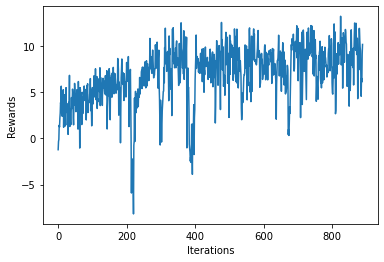

 89%|██████████████████████████████████████████████████████████████████▊        | 89107/100000 [59:42<06:52, 26.44it/s]

Updated Weights
Mean Reward = 9.14
40


 89%|██████████████████████████████████████████████████████████████████▉        | 89202/100000 [59:46<08:09, 22.06it/s]

Updated Weights
Mean Reward = 11.31
54


 89%|██████████████████████████████████████████████████████████████████▉        | 89307/100000 [59:49<05:29, 32.46it/s]

Updated Weights
Mean Reward = 12.65
65


 89%|███████████████████████████████████████████████████████████████████        | 89405/100000 [59:54<08:20, 21.15it/s]

Updated Weights
Mean Reward = 3.71
33


 90%|███████████████████████████████████████████████████████████████████▏       | 89500/100000 [59:59<08:43, 20.05it/s]

Updated Weights
Mean Reward = 8.36
36


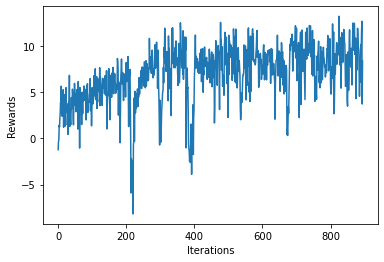

 90%|█████████████████████████████████████████████████████████████████▍       | 89603/100000 [1:00:03<08:01, 21.59it/s]

Updated Weights
Mean Reward = 10.24
44


 90%|█████████████████████████████████████████████████████████████████▍       | 89704/100000 [1:00:08<08:53, 19.30it/s]

Updated Weights
Mean Reward = 8.37
41


 90%|█████████████████████████████████████████████████████████████████▌       | 89804/100000 [1:00:12<09:52, 17.21it/s]

Updated Weights
Mean Reward = 6.97
37


 90%|█████████████████████████████████████████████████████████████████▋       | 89904/100000 [1:00:18<08:35, 19.58it/s]

Updated Weights
Mean Reward = 4.04
11


 90%|█████████████████████████████████████████████████████████████████▋       | 89999/100000 [1:00:22<09:24, 17.73it/s]

Updated Weights
Mean Reward = 5.73
23


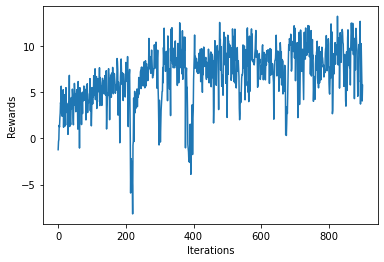

 90%|█████████████████████████████████████████████████████████████████▊       | 90105/100000 [1:00:28<07:16, 22.69it/s]

Updated Weights
Mean Reward = 6.03
36


 90%|█████████████████████████████████████████████████████████████████▊       | 90203/100000 [1:00:33<08:07, 20.09it/s]

Updated Weights
Mean Reward = 7.19
27


 90%|█████████████████████████████████████████████████████████████████▉       | 90303/100000 [1:00:37<07:55, 20.38it/s]

Updated Weights
Mean Reward = 7.41
27


 90%|█████████████████████████████████████████████████████████████████▉       | 90404/100000 [1:00:42<08:42, 18.38it/s]

Updated Weights
Mean Reward = 5.99
26


 90%|██████████████████████████████████████████████████████████████████       | 90499/100000 [1:00:47<09:08, 17.31it/s]

Updated Weights
Mean Reward = 7.92
29


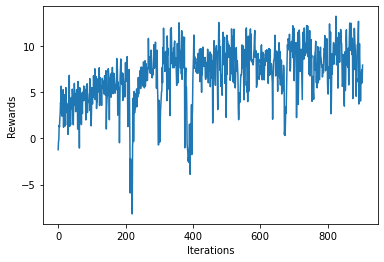

 91%|██████████████████████████████████████████████████████████████████▏      | 90603/100000 [1:00:52<07:08, 21.94it/s]

Updated Weights
Mean Reward = 9.08
40


 91%|██████████████████████████████████████████████████████████████████▏      | 90704/100000 [1:00:57<08:11, 18.91it/s]

Updated Weights
Mean Reward = 6.41
23


 91%|██████████████████████████████████████████████████████████████████▎      | 90805/100000 [1:01:02<06:43, 22.78it/s]

Updated Weights
Mean Reward = 7.83
32


 91%|██████████████████████████████████████████████████████████████████▎      | 90904/100000 [1:01:06<06:45, 22.44it/s]

Updated Weights
Mean Reward = 8.26
34


 91%|██████████████████████████████████████████████████████████████████▍      | 90996/100000 [1:01:10<06:25, 23.36it/s]

Updated Weights
Mean Reward = 8.3
40


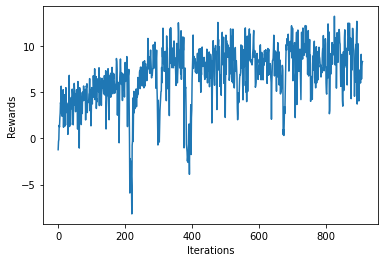

 91%|██████████████████████████████████████████████████████████████████▌      | 91104/100000 [1:01:16<08:28, 17.49it/s]

Updated Weights
Mean Reward = 3.71
24


 91%|██████████████████████████████████████████████████████████████████▌      | 91203/100000 [1:01:21<07:44, 18.96it/s]

Updated Weights
Mean Reward = 5.26
16


 91%|██████████████████████████████████████████████████████████████████▋      | 91303/100000 [1:01:26<06:33, 22.07it/s]

Updated Weights
Mean Reward = 7.37
27


 91%|██████████████████████████████████████████████████████████████████▋      | 91403/100000 [1:01:31<06:45, 21.20it/s]

Updated Weights
Mean Reward = 8.05
33


 92%|██████████████████████████████████████████████████████████████████▊      | 91500/100000 [1:01:35<05:55, 23.93it/s]

Updated Weights
Mean Reward = 7.51
29


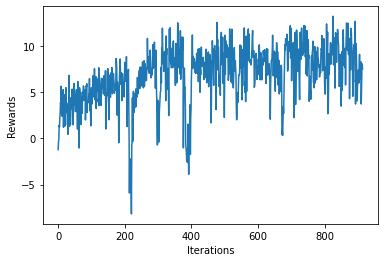

 92%|██████████████████████████████████████████████████████████████████▊      | 91604/100000 [1:01:40<07:15, 19.27it/s]

Updated Weights
Mean Reward = 8.59
39


 92%|██████████████████████████████████████████████████████████████████▉      | 91704/100000 [1:01:44<05:39, 24.40it/s]

Updated Weights
Mean Reward = 8.88
42


 92%|███████████████████████████████████████████████████████████████████      | 91803/100000 [1:01:49<05:45, 23.70it/s]

Updated Weights
Mean Reward = 9.84
38


 92%|███████████████████████████████████████████████████████████████████      | 91904/100000 [1:01:53<06:58, 19.36it/s]

Updated Weights
Mean Reward = 8.18
37


 92%|███████████████████████████████████████████████████████████████████▏     | 91999/100000 [1:01:58<07:20, 18.16it/s]

Updated Weights
Mean Reward = 5.22
20


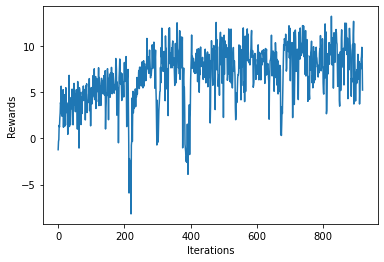

 92%|███████████████████████████████████████████████████████████████████▏     | 92105/100000 [1:02:03<06:12, 21.22it/s]

Updated Weights
Mean Reward = 8.35
33


 92%|███████████████████████████████████████████████████████████████████▎     | 92203/100000 [1:02:08<06:51, 18.95it/s]

Updated Weights
Mean Reward = 8.25
36


 92%|███████████████████████████████████████████████████████████████████▍     | 92304/100000 [1:02:12<06:57, 18.45it/s]

Updated Weights
Mean Reward = 7.02
30


 92%|███████████████████████████████████████████████████████████████████▍     | 92402/100000 [1:02:17<05:46, 21.90it/s]

Updated Weights
Mean Reward = 8.93
37


 92%|███████████████████████████████████████████████████████████████████▌     | 92500/100000 [1:02:21<06:08, 20.34it/s]

Updated Weights
Mean Reward = 8.61
37


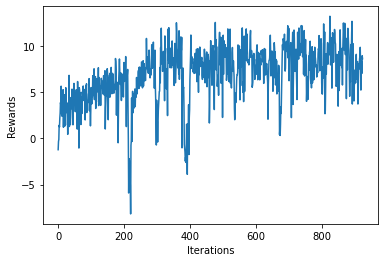

 93%|███████████████████████████████████████████████████████████████████▌     | 92602/100000 [1:02:26<05:05, 24.24it/s]

Updated Weights
Mean Reward = 9.32
39


 93%|███████████████████████████████████████████████████████████████████▋     | 92703/100000 [1:02:31<05:32, 21.93it/s]

Updated Weights
Mean Reward = 7.9
30


 93%|███████████████████████████████████████████████████████████████████▋     | 92804/100000 [1:02:36<05:55, 20.24it/s]

Updated Weights
Mean Reward = 8.39
40


 93%|███████████████████████████████████████████████████████████████████▊     | 92902/100000 [1:02:40<05:00, 23.61it/s]

Updated Weights
Mean Reward = 9.8
48


 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [1:02:43<04:14, 27.54it/s]

Updated Weights
Mean Reward = 9.95
56


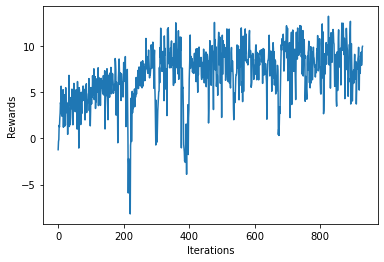

 93%|███████████████████████████████████████████████████████████████████▉     | 93104/100000 [1:02:47<04:49, 23.81it/s]

Updated Weights
Mean Reward = 9.49
57


 93%|████████████████████████████████████████████████████████████████████     | 93202/100000 [1:02:51<04:14, 26.68it/s]

Updated Weights
Mean Reward = 12.69
64


 93%|████████████████████████████████████████████████████████████████████     | 93306/100000 [1:02:55<03:59, 27.91it/s]

Updated Weights
Mean Reward = 6.5
39


 93%|████████████████████████████████████████████████████████████████████▏    | 93403/100000 [1:03:00<04:50, 22.72it/s]

Updated Weights
Mean Reward = 8.57
49


 94%|████████████████████████████████████████████████████████████████████▎    | 93500/100000 [1:03:04<04:41, 23.12it/s]

Updated Weights
Mean Reward = 8.99
42


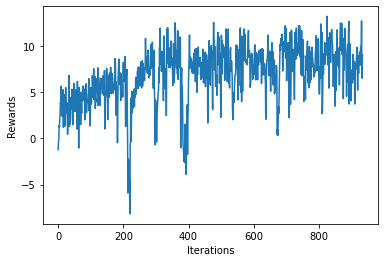

 94%|████████████████████████████████████████████████████████████████████▎    | 93605/100000 [1:03:09<05:13, 20.37it/s]

Updated Weights
Mean Reward = 7.06
45


 94%|████████████████████████████████████████████████████████████████████▍    | 93704/100000 [1:03:13<04:51, 21.62it/s]

Updated Weights
Mean Reward = 7.92
43


 94%|████████████████████████████████████████████████████████████████████▍    | 93802/100000 [1:03:17<05:14, 19.72it/s]

Updated Weights
Mean Reward = 8.82
47


 94%|████████████████████████████████████████████████████████████████████▌    | 93904/100000 [1:03:21<04:06, 24.70it/s]

Updated Weights
Mean Reward = 9.42
40


 94%|████████████████████████████████████████████████████████████████████▌    | 94000/100000 [1:03:26<05:24, 18.51it/s]

Updated Weights
Mean Reward = 7.98
36


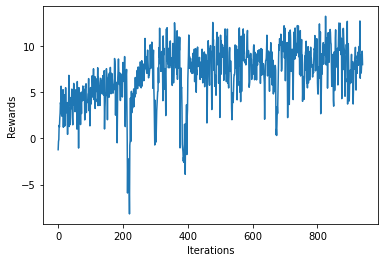

 94%|████████████████████████████████████████████████████████████████████▋    | 94102/100000 [1:03:31<04:44, 20.70it/s]

Updated Weights
Mean Reward = 5.66
27


 94%|████████████████████████████████████████████████████████████████████▊    | 94203/100000 [1:03:36<04:50, 19.98it/s]

Updated Weights
Mean Reward = 5.78
35


 94%|████████████████████████████████████████████████████████████████████▊    | 94302/100000 [1:03:40<03:51, 24.58it/s]

Updated Weights
Mean Reward = 5.59
23


 94%|████████████████████████████████████████████████████████████████████▉    | 94405/100000 [1:03:45<04:33, 20.43it/s]

Updated Weights
Mean Reward = 8.43
33


 94%|████████████████████████████████████████████████████████████████████▉    | 94497/100000 [1:03:49<03:37, 25.35it/s]

Updated Weights
Mean Reward = 8.13
33


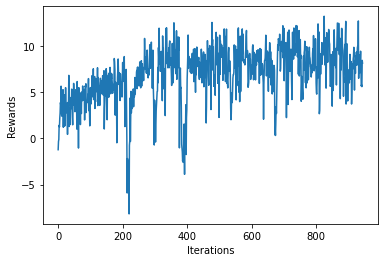

 95%|█████████████████████████████████████████████████████████████████████    | 94602/100000 [1:03:54<03:59, 22.50it/s]

Updated Weights
Mean Reward = 8.92
33


 95%|█████████████████████████████████████████████████████████████████████▏   | 94702/100000 [1:03:59<04:19, 20.43it/s]

Updated Weights
Mean Reward = 8.48
39


 95%|█████████████████████████████████████████████████████████████████████▏   | 94805/100000 [1:04:04<04:09, 20.79it/s]

Updated Weights
Mean Reward = 9.02
33


 95%|█████████████████████████████████████████████████████████████████████▎   | 94903/100000 [1:04:08<03:54, 21.72it/s]

Updated Weights
Mean Reward = 9.3
42


 95%|█████████████████████████████████████████████████████████████████████▎   | 94998/100000 [1:04:12<03:56, 21.15it/s]

Updated Weights
Mean Reward = 7.99
33


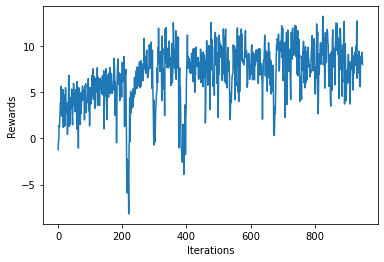

 95%|█████████████████████████████████████████████████████████████████████▍   | 95103/100000 [1:04:17<04:20, 18.77it/s]

Updated Weights
Mean Reward = 6.83
40


 95%|█████████████████████████████████████████████████████████████████████▍   | 95204/100000 [1:04:22<04:19, 18.47it/s]

Updated Weights
Mean Reward = 3.88
17


 95%|█████████████████████████████████████████████████████████████████████▌   | 95302/100000 [1:04:28<04:38, 16.89it/s]

Updated Weights
Mean Reward = 5.72
9


 95%|█████████████████████████████████████████████████████████████████████▋   | 95404/100000 [1:04:33<03:51, 19.87it/s]

Updated Weights
Mean Reward = 8.54
33


 95%|█████████████████████████████████████████████████████████████████████▋   | 95499/100000 [1:04:37<03:16, 22.92it/s]

Updated Weights
Mean Reward = 8.36
34


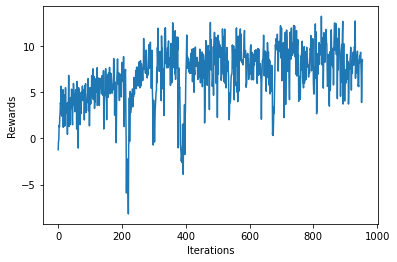

 96%|█████████████████████████████████████████████████████████████████████▊   | 95604/100000 [1:04:42<03:18, 22.10it/s]

Updated Weights
Mean Reward = 10.35
47


 96%|█████████████████████████████████████████████████████████████████████▊   | 95705/100000 [1:04:46<02:37, 27.32it/s]

Updated Weights
Mean Reward = 11.58
52


 96%|█████████████████████████████████████████████████████████████████████▉   | 95804/100000 [1:04:49<02:33, 27.32it/s]

Updated Weights
Mean Reward = 12.29
64


 96%|██████████████████████████████████████████████████████████████████████   | 95906/100000 [1:04:53<02:24, 28.27it/s]

Updated Weights
Mean Reward = 12.04
64


 96%|██████████████████████████████████████████████████████████████████████   | 95998/100000 [1:04:58<03:10, 20.96it/s]

Updated Weights
Mean Reward = 6.38
32


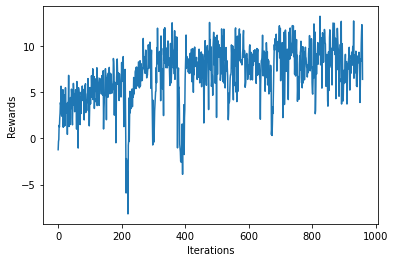

 96%|██████████████████████████████████████████████████████████████████████▏  | 96107/100000 [1:05:03<02:52, 22.57it/s]

Updated Weights
Mean Reward = 4.52
22


 96%|██████████████████████████████████████████████████████████████████████▏  | 96203/100000 [1:05:07<03:17, 19.26it/s]

Updated Weights
Mean Reward = 10.76
52


 96%|██████████████████████████████████████████████████████████████████████▎  | 96303/100000 [1:05:12<02:54, 21.16it/s]

Updated Weights
Mean Reward = 10.76
46


 96%|██████████████████████████████████████████████████████████████████████▍  | 96406/100000 [1:05:16<02:41, 22.20it/s]

Updated Weights
Mean Reward = 9.31
35


 96%|██████████████████████████████████████████████████████████████████████▍  | 96500/100000 [1:05:21<02:38, 22.07it/s]

Updated Weights
Mean Reward = 10.2
44


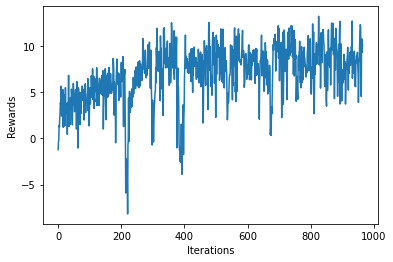

 97%|██████████████████████████████████████████████████████████████████████▌  | 96605/100000 [1:05:25<02:25, 23.41it/s]

Updated Weights
Mean Reward = 10.77
52


 97%|██████████████████████████████████████████████████████████████████████▌  | 96703/100000 [1:05:29<02:29, 22.08it/s]

Updated Weights
Mean Reward = 10.38
48


 97%|██████████████████████████████████████████████████████████████████████▋  | 96805/100000 [1:05:34<02:39, 20.01it/s]

Updated Weights
Mean Reward = 9.05
33


 97%|██████████████████████████████████████████████████████████████████████▋  | 96903/100000 [1:05:38<02:16, 22.66it/s]

Updated Weights
Mean Reward = 10.98
53


 97%|██████████████████████████████████████████████████████████████████████▊  | 96998/100000 [1:05:42<02:28, 20.16it/s]

Updated Weights
Mean Reward = 11.22
52


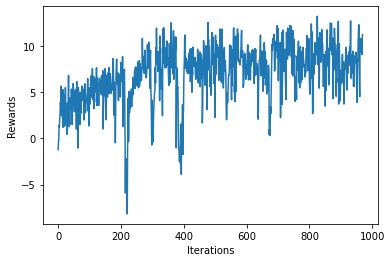

 97%|██████████████████████████████████████████████████████████████████████▉  | 97104/100000 [1:05:47<02:00, 24.00it/s]

Updated Weights
Mean Reward = 10.42
44


 97%|██████████████████████████████████████████████████████████████████████▉  | 97204/100000 [1:05:51<02:22, 19.64it/s]

Updated Weights
Mean Reward = 12.31
66


 97%|███████████████████████████████████████████████████████████████████████  | 97304/100000 [1:05:56<02:25, 18.57it/s]

Updated Weights
Mean Reward = 5.08
16


 97%|███████████████████████████████████████████████████████████████████████  | 97403/100000 [1:06:01<01:35, 27.09it/s]

Updated Weights
Mean Reward = 8.22
30


 97%|███████████████████████████████████████████████████████████████████████▏ | 97499/100000 [1:06:05<01:53, 22.04it/s]

Updated Weights
Mean Reward = 10.14
50


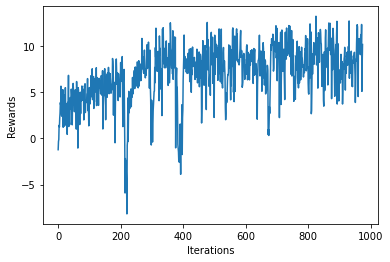

 98%|███████████████████████████████████████████████████████████████████████▎ | 97603/100000 [1:06:09<01:41, 23.63it/s]

Updated Weights
Mean Reward = 10.87
55


 98%|███████████████████████████████████████████████████████████████████████▎ | 97702/100000 [1:06:13<01:55, 19.97it/s]

Updated Weights
Mean Reward = 9.57
46


 98%|███████████████████████████████████████████████████████████████████████▍ | 97803/100000 [1:06:17<01:39, 22.05it/s]

Updated Weights
Mean Reward = 9.68
53


 98%|███████████████████████████████████████████████████████████████████████▍ | 97902/100000 [1:06:21<01:11, 29.40it/s]

Updated Weights
Mean Reward = 9.94
53


 98%|███████████████████████████████████████████████████████████████████████▌ | 98000/100000 [1:06:24<01:08, 29.16it/s]

Updated Weights
Mean Reward = 11.95
62


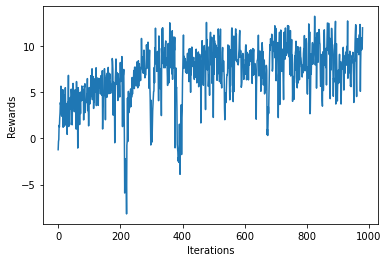

 98%|███████████████████████████████████████████████████████████████████████▌ | 98107/100000 [1:06:28<01:00, 31.30it/s]

Updated Weights
Mean Reward = 12.8
70


 98%|███████████████████████████████████████████████████████████████████████▋ | 98204/100000 [1:06:32<01:22, 21.87it/s]

Updated Weights
Mean Reward = 10.64
55


 98%|███████████████████████████████████████████████████████████████████████▊ | 98304/100000 [1:06:36<01:13, 23.07it/s]

Updated Weights
Mean Reward = 10.11
57


 98%|███████████████████████████████████████████████████████████████████████▊ | 98406/100000 [1:06:40<00:58, 27.26it/s]

Updated Weights
Mean Reward = 12.27
60


 98%|███████████████████████████████████████████████████████████████████████▉ | 98498/100000 [1:06:43<00:59, 25.32it/s]

Updated Weights
Mean Reward = 12.07
64


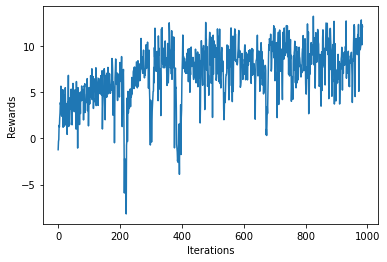

 99%|███████████████████████████████████████████████████████████████████████▉ | 98605/100000 [1:06:48<01:06, 20.85it/s]

Updated Weights
Mean Reward = 10.02
56


 99%|████████████████████████████████████████████████████████████████████████ | 98703/100000 [1:06:53<01:05, 19.86it/s]

Updated Weights
Mean Reward = 10.32
56


 99%|████████████████████████████████████████████████████████████████████████▏| 98804/100000 [1:06:58<00:52, 22.66it/s]

Updated Weights
Mean Reward = 8.66
50


 99%|████████████████████████████████████████████████████████████████████████▏| 98904/100000 [1:07:02<00:44, 24.61it/s]

Updated Weights
Mean Reward = 11.14
54


 99%|████████████████████████████████████████████████████████████████████████▎| 98998/100000 [1:07:05<00:35, 28.48it/s]

Updated Weights
Mean Reward = 12.24
64


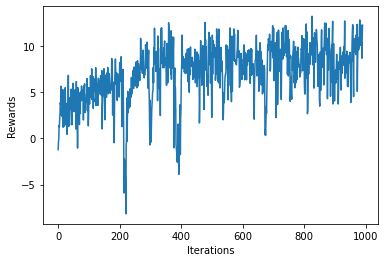

 99%|████████████████████████████████████████████████████████████████████████▎| 99103/100000 [1:07:09<00:36, 24.71it/s]

Updated Weights
Mean Reward = 9.88
56


 99%|████████████████████████████████████████████████████████████████████████▍| 99204/100000 [1:07:13<00:29, 27.35it/s]

Updated Weights
Mean Reward = 9.63
56


 99%|████████████████████████████████████████████████████████████████████████▍| 99302/100000 [1:07:17<00:25, 26.91it/s]

Updated Weights
Mean Reward = 10.76
58


 99%|████████████████████████████████████████████████████████████████████████▌| 99403/100000 [1:07:21<00:28, 21.21it/s]

Updated Weights
Mean Reward = 7.58
55


100%|████████████████████████████████████████████████████████████████████████▋| 99500/100000 [1:07:26<00:25, 19.33it/s]

Updated Weights
Mean Reward = 4.11
30


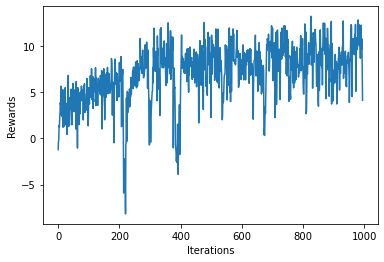

100%|████████████████████████████████████████████████████████████████████████▋| 99604/100000 [1:07:32<00:22, 17.90it/s]

Updated Weights
Mean Reward = 5.6
41


100%|████████████████████████████████████████████████████████████████████████▊| 99704/100000 [1:07:36<00:11, 26.91it/s]

Updated Weights
Mean Reward = 11.02
54


100%|████████████████████████████████████████████████████████████████████████▊| 99801/100000 [1:07:40<00:10, 19.90it/s]

Updated Weights
Mean Reward = 7.9
46


100%|████████████████████████████████████████████████████████████████████████▉| 99905/100000 [1:07:44<00:04, 22.69it/s]

Updated Weights
Mean Reward = 11.43
57


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:07:48<00:00, 24.58it/s]


In [6]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()

    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        print('Updated Weights')

       
    if epoch>50 and epoch%250==0:
        user_agent.epsilon*=0.9
        user_agent.epsilon = max(user_agent.epsilon, 0.1)

    mean_rewards.append(episode_reward)
    if epoch%100==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [7]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
while not done and step<max_steps:
    print(state)
    state = np.array(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1


[0.6, 0.0, 0.3, 0.0]
[0.5, 0.0, 0.3, 0.0]
[0.4, 0.0, 0.3, 0.0]


In [8]:
print(done)

1
